# train

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
from rl_env_inc_skip import TrajComp
from rl_brain import PolicyGradient
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

def run_online(env, RL, ratio, elist): # Validation
    eva = []
    skip_pts = 0
    step_pts = 0
    for episode in elist:
        buffer_size = int(ratio*len(env.ori_traj_set[episode]))
        if buffer_size < 3:
            continue
        steps, observation = env.reset(episode, buffer_size)
        step_pts = step_pts + steps
        for index in range(buffer_size, steps):
            if index == steps - 1:
                done = True
            else:
                done = False
            if index < env.INX:
                #print('test skip')
                skip_pts = skip_pts + 1
                continue
            action = RL.pro_choose_action(observation)
            observation_, _ = env.step(episode, action, index, done, 'V') #'T' means Training, and 'V' means Validation
            observation = observation_
        eva.append(env.output(episode, 'V')) #'T' means Training, 'V' means Validation, and 'V-VIS' for visualization on Validation
    return eva
        
def run_comp(env, RL, Round, traj_amount, valid_amount, show_time, ratio): #Training
    check = 999999
    tra_av_errs = []#放的是每50回合训练集上的平均误差
    val_av_errs = []#放的是每50回合验证集上的平均误差
    for r in range(Round):
        env.shuffle()
        episode = 0
        for i in range(0, traj_amount, show_time):
            train_ep_errs = []
            start_t = time.time()
            for _ in tqdm(range(show_time), desc="[{}/{}]".format(min(i+show_time,traj_amount),traj_amount),ncols=100):
                buffer_size = int(ratio*len(env.ori_traj_set[episode]))
                # extreme cases
                if buffer_size < 3:
                    episode += 1
                    continue
                steps, state = env.reset(episode, buffer_size)#初始化状态值，返回轨迹点数和有序列表前k个状态值
                for index in range(buffer_size, steps):#从第一次缓存外第一个点遍历到最后一个点
                    if index == steps - 1:#如果已经是轨迹最后一个点
                        done = True
                    else:
                        done = False
                    if index < env.INX:
                        #print('train skip')
                        continue
                    action = RL.pro_choose_action(state)#状态输出到神经网络输出动作的概率分布，按概率采样一个动作
                    new_state, reward = env.step(episode, action, index, done, 'T') #'T' means Training, and 'V' means Validation                   
                    RL.store_transition(state, action, reward)
                    if done:
                        RL.learn()#回合结束开始策略梯度算法学习参数
                        break
                    state = new_state
                train_e = env.output(episode, 'T') #'T' means Training, 'V' means Validation, and 'V-VIS' for visualization on Validation
                train_ep_errs.append(train_e)
                episode += 1
            
            val_ep_errs = run_online(env, RL, ratio, [i for i in range(traj_amount, traj_amount + valid_amount)])
            val_av_err = sum(val_ep_errs)/len(val_ep_errs)
            val_av_errs.append(val_av_err)
            tra_av_err = sum(train_ep_errs)/len(train_ep_errs)
            tra_av_errs.append(tra_av_err)
            print('round {} episode {}: Training error: {}, Validation error: {}'.format(r, episode, tra_av_err, val_av_err))
            if val_av_err < check:
                check = val_av_err
                RL.save('./save_skip/'+ str(val_av_err) + '_ratio_' + str(ratio) + '_' + env.label + '/trained_model.ckpt')
                print('Save model with error {}'.format(val_av_err))
            print('==>current best model is {} with ratio {}'.format(check, ratio))
            print('It costs {}s'.format(time.time()-start_t))
    return tra_av_errs, val_av_errs

def train(traj_amount, valid_amount, Round, show_time, ratio, a_size, s_size, skip_size, label):
    traj_path = '../trajData/Geolife_out/'
    env = TrajComp(a_size + skip_size, s_size)
    env.load_train_data(traj_path, traj_amount, valid_amount)
    env.set_error_type(label)
    RL = PolicyGradient(env.n_features, env.n_actions)
    start = time.time()
    tra_av_errs, val_av_errs = run_comp(env, RL, Round, traj_amount, valid_amount, show_time, ratio)
    print("Training elapsed time = %s", float(time.time() - start))
    with open('errors_records.txt', 'a') as f:
        f.write('\nTraining errors and validation errors (' + label + ')\n')
        for i in range(len(tra_av_errs)):
            f.write(str(tra_av_errs[i])+' ')
        f.write('\n')
        for i in range(len(val_av_errs)):
            f.write(str(val_av_errs[i])+' ')
    plt.figure()
    plt.title("Average errors of training and validation:")
    plt.xlabel("training process / "+str(show_time)+" episodes")
    plt.ylabel(label+" error")
    x = range(len(tra_av_errs))
    plt.plot(x, tra_av_errs, "r", label="training" )
    plt.plot(x, val_av_errs, "b", label="validation")
    plt.legend()
    plt.figure()
    plt.title("Average errors of validation:")
    plt.xlabel("training process / "+str(show_time)+" episodes")
    plt.ylabel(label+" error")
    x = range(len(tra_av_errs))
    plt.plot(x, val_av_errs, "b", label="validation")
    plt.legend()
    plt.show()

def retrain(model_path, traj_amount, valid_amount, Round, show_time, ratio, a_size, s_size, skip_size, label):
    traj_path = '../trajData/Geolife_out/'
    env = TrajComp(a_size + skip_size, s_size)
    env.load_train_data(traj_path, traj_amount, valid_amount)
    env.set_error_type(label)
    RL = PolicyGradient(env.n_features, env.n_actions)
    RL.load(model_path)
    start = time.time()
    tra_av_errs, val_av_errs = run_comp(env, RL, Round, traj_amount, valid_amount, show_time, ratio)
    print("Training elapsed time = %s", float(time.time() - start))
    with open('errors_records.txt', 'a') as f:
        f.write('\nTraining errors and validation errors (' + label + ')\n')
        for i in range(len(tra_av_errs)):
            f.write(str(tra_av_errs[i])+' ')
        f.write('\n')
        for i in range(len(val_av_errs)):
            f.write(str(val_av_errs[i])+' ')
    plt.figure()
    plt.title("Average errors of training and validation:")
    plt.xlabel("training process / "+str(show_time)+" episodes")
    plt.ylabel(label+" error")
    x = range(len(tra_av_errs))
    plt.plot(x, tra_av_errs, "r", label="training" )
    plt.plot(x, val_av_errs, "b", label="validation")
    plt.legend()
    plt.figure()
    plt.title("Average errors of validation:")
    plt.xlabel("training process / "+str(show_time)+" episodes")
    plt.ylabel(label+" error")
    x = range(len(tra_av_errs))
    plt.plot(x, val_av_errs, "b", label="validation")
    plt.legend()
    plt.show()
    

# test

In [3]:
from rl_env_inc_skip import TrajComp
from rl_brain import PolicyGradient
import data_utils as F
import time

def evaluate(env, RL, ratio, elist): # Evaluation
    eva = []
    skip_pts = 0
    step_pts = 0
    for episode in elist:
        buffer_size = int(ratio*len(env.ori_traj_set[episode]))
        if buffer_size < 3:
            continue
        steps, observation = env.reset(episode, buffer_size)
        step_pts = step_pts + steps
        for index in range(buffer_size, steps):
            if index == steps - 1:
                done = True
            else:
                done = False
            if index < env.INX:
                #print('test skip')
                skip_pts = skip_pts + 1
                continue
            action = RL.quick_time_action(observation)
            observation_, _ = env.step(episode, action, index, done, 'V') #'T' means Training, and 'V' means Validation
            observation = observation_
        eva.append(env.output(episode, 'V')) #'T' means Training, 'V' means Validation, and 'V-VIS' for visualization on Validation
    return sum(eva)/len(eva)

def test(model_path, amount, ratio, a_size, s_size, skip_size, label):
    print("======Start testing the model at'{}======'".format(model_path))
    traj_path = '../trajData/Geolife_out/'
    env = TrajComp(a_size + skip_size, s_size)
    env.load_test_data(traj_path, amount)
    env.set_error_type(label)
    rl = PolicyGradient(env.n_features, env.n_actions)
    rl.load(model_path) #your_trained_model your_trained_model_skip
    for _ in range(3):
        start = time.time()
        effectiveness = evaluate(env, rl, ratio, range(amount))
        print("Effectiveness: {:.4f}".format(effectiveness))
        print("Training elapsed time = {:.4f}s".format(float(time.time() - start)))   

def test_err(model_path, amount, ratio, a_size, s_size, skip_size):
    print("======Start testing the model at'{}======'".format(model_path))
    traj_path = '../trajData/Geolife_out/'
    env = TrajComp(a_size + skip_size, s_size)
    env.load_test_data(traj_path, amount)
    rl = PolicyGradient(env.n_features, env.n_actions)
    rl.load(model_path) #your_trained_model your_trained_model_skip
    for _ in range(3):
        errs = []
        t = []
        for type in ['sed','ped','dad','sad']:
            env.set_error_type(type)
            st = time.time()
            err = evaluate(env, rl, ratio, range(amount))
            t.append(time.time()-st)
            errs.append(err)
        print("Effectiveness of different errors: sed:{:.4f}, ped:{:.4f}, dad:{:.4f}, sad:{:.4f}"\
              .format(errs[0],errs[1],errs[2],errs[3]))
        print("Testing elapsed time = {:.4f}s, {:.4f}s, {:.4f}s, {:.4f}s".format(t[0],t[1],t[2],t[3]))
        
def test_ratio(model_path, amount, a_size, s_size, skip_size, label):
    print("======Start testing the model at'{}======'".format(model_path))
    traj_path = '../trajData/Geolife_out/'
    env = TrajComp(a_size + skip_size, s_size)
    env.load_test_data(traj_path, amount)
    rl = PolicyGradient(env.n_features, env.n_actions)
    rl.load(model_path) #your_trained_model your_trained_model_skip
    for _ in range(3):
        errs = []
        t = []
        for r in [0.1,0.2,0.3,0.4,0.5]:
            env.set_error_type(label)
            st = time.time()
            err = evaluate(env, rl, r, range(amount))
            t.append(time.time()-st)
            errs.append(err)
        print("Effectiveness of different ratios: 0.1:{:.4f}, 0.2:{:.4f}, 0.3:{:.4f}, 0.4:{:.4f}, 0.5:{:.4f}"\
              .format(errs[0],errs[1],errs[2],errs[3],errs[4]))
        print("Testing elapsed time = {:.4f}s, {:.4f}s, {:.4f}s, {:.4f}s, {:.4f}s".format(t[0],t[1],t[2],t[3],t[4]))

def test_one_sample(model_path, index, ratio, a_size, s_size, skip_size, label):
    print("======Start testing the model at'{}======'".format(model_path))
    traj_path = '../trajData/Geolife_out/'
    env = TrajComp(a_size + skip_size, s_size)
    env.load_one_sample(traj_path, index)
    env.set_error_type(label)
    rl = PolicyGradient(env.n_features, env.n_actions)
    rl.load(model_path) #your_trained_model your_trained_model_skip
    
    net_time = 0
    step_time = 0
    start_ = time.time()
    eva = []
    buffer_size = int(ratio*len(env.ori_traj_set[0]))
    if buffer_size < 3:
        return
    steps, observation = env.reset(0, buffer_size)
    for index in range(buffer_size, steps):
        if index == steps - 1:
            done = True
        else:
            done = False
        start = time.time()
        action = rl.quick_time_action(observation)
        net_time += float(time.time()-start)
        start = time.time()
        observation_, _ = env.step(0, action, index, done, 'V') #'T' means Training, and 'V' means Validation
        step_time += float(time.time()-start)
        observation = observation_
    eva=env.output(0, 'V') #'T' means Training, 'V' means Validation, and 'V-VIS' for visualization on Validation
    print("Effectiveness: %e" %eva)
    print("Training elapsed time = %s", float(time.time() - start_))
    print("net_time:",net_time)
    print("step_time:",step_time)   

## train and test

======loading train data======
It cost 5.848829030990601s.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.






[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.88it/s]


round 0 episode 100: Training error: 214.54298852335648, Validation error: 168.08965048842717

Save model with error 168.08965048842717
==>current best model is 168.08965048842717 with ratio 0.1
It costs 108.07211565971375s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.43it/s]


round 0 episode 200: Training error: 167.95011393265332, Validation error: 183.0299613242409
==>current best model is 168.08965048842717 with ratio 0.1
It costs 131.14987468719482s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


round 1 episode 100: Training error: 139.74385970245427, Validation error: 166.4439695326254
Save model with error 166.4439695326254
==>current best model is 166.4439695326254 with ratio 0.1
It costs 137.0107901096344s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.99it/s]


round 1 episode 200: Training error: 227.63882209590437, Validation error: 186.03860939664554
==>current best model is 166.4439695326254 with ratio 0.1
It costs 109.42281889915466s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.56it/s]


round 2 episode 100: Training error: 296.612982890355, Validation error: 181.49114826394506
==>current best model is 166.4439695326254 with ratio 0.1
It costs 122.6730489730835s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.56it/s]


round 2 episode 200: Training error: 160.74580079148697, Validation error: 198.9702830912873
==>current best model is 166.4439695326254 with ratio 0.1
It costs 125.63616514205933s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s]


round 3 episode 100: Training error: 278.30407972325804, Validation error: 164.27428851839196
Save model with error 164.27428851839196
==>current best model is 164.27428851839196 with ratio 0.1
It costs 122.04172825813293s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


round 3 episode 200: Training error: 201.97064619815825, Validation error: 176.0923855077864
==>current best model is 164.27428851839196 with ratio 0.1
It costs 132.97329449653625s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


round 4 episode 100: Training error: 164.14883718998058, Validation error: 144.67232923628873
Save model with error 144.67232923628873
==>current best model is 144.67232923628873 with ratio 0.1
It costs 148.32762598991394s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]


round 4 episode 200: Training error: 260.2707937702087, Validation error: 175.9719029506947
==>current best model is 144.67232923628873 with ratio 0.1
It costs 132.60967421531677s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


round 5 episode 100: Training error: 148.24697057928554, Validation error: 141.82871365039549
Save model with error 141.82871365039549
==>current best model is 141.82871365039549 with ratio 0.1
It costs 159.91754603385925s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


round 5 episode 200: Training error: 182.34508911679538, Validation error: 130.24366939627188
Save model with error 130.24366939627188
==>current best model is 130.24366939627188 with ratio 0.1
It costs 158.71198749542236s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


round 6 episode 100: Training error: 139.0196243480798, Validation error: 133.47391239870785
==>current best model is 130.24366939627188 with ratio 0.1
It costs 176.26027369499207s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.12it/s]


round 6 episode 200: Training error: 115.07195104394235, Validation error: 134.57932507305992
==>current best model is 130.24366939627188 with ratio 0.1
It costs 169.37780094146729s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


round 7 episode 100: Training error: 98.80379562579452, Validation error: 120.64532320610707
Save model with error 120.64532320610707
==>current best model is 120.64532320610707 with ratio 0.1
It costs 170.1203281879425s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


round 7 episode 200: Training error: 125.6129573317319, Validation error: 113.59532766404831
Save model with error 113.59532766404831
==>current best model is 113.59532766404831 with ratio 0.1
It costs 179.16914057731628s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.05s/it]


round 8 episode 100: Training error: 110.31695193028625, Validation error: 110.15016840116361
Save model with error 110.15016840116361
==>current best model is 110.15016840116361 with ratio 0.1
It costs 194.75739121437073s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


round 8 episode 200: Training error: 109.71205373422555, Validation error: 120.55208769146071
==>current best model is 110.15016840116361 with ratio 0.1
It costs 182.48853373527527s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


round 9 episode 100: Training error: 112.17334326479222, Validation error: 130.88790365516263
==>current best model is 110.15016840116361 with ratio 0.1
It costs 175.63751888275146s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


round 9 episode 200: Training error: 122.43005179978945, Validation error: 112.9774673000305
==>current best model is 110.15016840116361 with ratio 0.1
It costs 190.90850400924683s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:53<00:00,  1.14s/it]


round 10 episode 100: Training error: 120.05640098644932, Validation error: 114.66933142744327
==>current best model is 110.15016840116361 with ratio 0.1
It costs 199.26016449928284s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


round 10 episode 200: Training error: 153.55917829035906, Validation error: 114.24736948553405
==>current best model is 110.15016840116361 with ratio 0.1
It costs 166.81929063796997s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/it]


round 11 episode 100: Training error: 119.10741645152018, Validation error: 122.64125910004243
==>current best model is 110.15016840116361 with ratio 0.1
It costs 191.42739844322205s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


round 11 episode 200: Training error: 142.30270904208047, Validation error: 124.4373049537469
==>current best model is 110.15016840116361 with ratio 0.1
It costs 186.72881627082825s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:53<00:00,  1.14s/it]


round 12 episode 100: Training error: 117.59781265875932, Validation error: 106.33838449325556
Save model with error 106.33838449325556
==>current best model is 106.33838449325556 with ratio 0.1
It costs 205.42069506645203s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.11it/s]


round 12 episode 200: Training error: 96.43184747667303, Validation error: 125.82902125267948
==>current best model is 106.33838449325556 with ratio 0.1
It costs 179.46374464035034s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


round 13 episode 100: Training error: 85.78732883589184, Validation error: 104.27355521237858
Save model with error 104.27355521237858
==>current best model is 104.27355521237858 with ratio 0.1
It costs 210.41571879386902s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


round 13 episode 200: Training error: 126.76323764298351, Validation error: 115.07888367144633
==>current best model is 104.27355521237858 with ratio 0.1
It costs 179.51997208595276s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


round 14 episode 100: Training error: 94.11670152729747, Validation error: 111.22154531880932
==>current best model is 104.27355521237858 with ratio 0.1
It costs 179.23067426681519s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:01<00:00,  1.21s/it]


round 14 episode 200: Training error: 94.62436800551164, Validation error: 108.34268328708772
==>current best model is 104.27355521237858 with ratio 0.1
It costs 215.0471658706665s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.00it/s]


round 15 episode 100: Training error: 94.76870637373108, Validation error: 106.87441451888044
==>current best model is 104.27355521237858 with ratio 0.1
It costs 193.16006922721863s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.10s/it]


round 15 episode 200: Training error: 85.37819947840853, Validation error: 106.18703897462454
==>current best model is 104.27355521237858 with ratio 0.1
It costs 203.1153690814972s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


round 16 episode 100: Training error: 122.77203230930783, Validation error: 96.29282506590306
Save model with error 96.29282506590306
==>current best model is 96.29282506590306 with ratio 0.1
It costs 204.9895007610321s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


round 16 episode 200: Training error: 66.16227414575594, Validation error: 122.80216295292726
==>current best model is 96.29282506590306 with ratio 0.1
It costs 187.83881640434265s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.19it/s]


round 17 episode 100: Training error: 201.7917383637296, Validation error: 106.56103604852233
==>current best model is 96.29282506590306 with ratio 0.1
It costs 197.30393719673157s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


round 17 episode 200: Training error: 90.41350119157867, Validation error: 97.90334298308125
==>current best model is 96.29282506590306 with ratio 0.1
It costs 282.61060786247253s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it]


round 18 episode 100: Training error: 137.8202524461763, Validation error: 96.91578150057288
==>current best model is 96.29282506590306 with ratio 0.1
It costs 228.8889126777649s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]


round 18 episode 200: Training error: 62.0942272651289, Validation error: 105.24705860060635
==>current best model is 96.29282506590306 with ratio 0.1
It costs 265.493350982666s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.00s/it]


round 19 episode 100: Training error: 81.44002485181997, Validation error: 110.72887216032117
==>current best model is 96.29282506590306 with ratio 0.1
It costs 196.3047480583191s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


round 19 episode 200: Training error: 107.32015546527442, Validation error: 93.05443233504492
Save model with error 93.05443233504492
==>current best model is 93.05443233504492 with ratio 0.1
It costs 208.07407999038696s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.12it/s]


round 20 episode 100: Training error: 88.06467334702411, Validation error: 97.64491129687707
==>current best model is 93.05443233504492 with ratio 0.1
It costs 185.49963355064392s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.22s/it]


round 20 episode 200: Training error: 101.50692299391238, Validation error: 95.95953409350022
==>current best model is 93.05443233504492 with ratio 0.1
It costs 218.0910828113556s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


round 21 episode 100: Training error: 86.20369601931294, Validation error: 94.16929486197907
==>current best model is 93.05443233504492 with ratio 0.1
It costs 204.222514629364s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.19s/it]


round 21 episode 200: Training error: 101.46382408634119, Validation error: 93.29297486466552
==>current best model is 93.05443233504492 with ratio 0.1
It costs 215.94754457473755s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.15s/it]


round 22 episode 100: Training error: 105.31644993360236, Validation error: 99.44365259874439
==>current best model is 93.05443233504492 with ratio 0.1
It costs 213.06705379486084s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


round 22 episode 200: Training error: 64.6555970215919, Validation error: 109.91681224790825
==>current best model is 93.05443233504492 with ratio 0.1
It costs 198.80027413368225s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.26s/it]


round 23 episode 100: Training error: 66.2001016865344, Validation error: 92.9542006768548
Save model with error 92.9542006768548
==>current best model is 92.9542006768548 with ratio 0.1
It costs 224.2462010383606s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


round 23 episode 200: Training error: 117.49343244086926, Validation error: 99.87017596533447
==>current best model is 92.9542006768548 with ratio 0.1
It costs 190.17206478118896s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


round 24 episode 100: Training error: 75.34163065087989, Validation error: 92.22268159834623
Save model with error 92.22268159834623
==>current best model is 92.22268159834623 with ratio 0.1
It costs 202.30624127388s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.15s/it]


round 24 episode 200: Training error: 113.24776672953232, Validation error: 110.28803639485578
==>current best model is 92.22268159834623 with ratio 0.1
It costs 213.44657945632935s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


round 25 episode 100: Training error: 74.67794467150705, Validation error: 97.5363240811262
==>current best model is 92.22268159834623 with ratio 0.1
It costs 215.71440243721008s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.01s/it]


round 25 episode 200: Training error: 101.34449801492805, Validation error: 90.09990893485946
Save model with error 90.09990893485946
==>current best model is 90.09990893485946 with ratio 0.1
It costs 200.15005731582642s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:01<00:00,  1.22s/it]


round 26 episode 100: Training error: 89.1812445698773, Validation error: 90.24229665841854
==>current best model is 90.09990893485946 with ratio 0.1
It costs 221.22643208503723s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.00s/it]


round 26 episode 200: Training error: 80.81566812547035, Validation error: 92.37825335902917
==>current best model is 90.09990893485946 with ratio 0.1
It costs 198.77628564834595s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


round 27 episode 100: Training error: 98.6510183189448, Validation error: 92.10744119500733
==>current best model is 90.09990893485946 with ratio 0.1
It costs 207.61655521392822s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.15s/it]


round 27 episode 200: Training error: 80.49464128179791, Validation error: 100.49693391604062
==>current best model is 90.09990893485946 with ratio 0.1
It costs 213.9653124809265s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


round 28 episode 100: Training error: 85.08993292439726, Validation error: 98.26536962443943
==>current best model is 90.09990893485946 with ratio 0.1
It costs 192.8771107196808s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]


round 28 episode 200: Training error: 89.31165065450251, Validation error: 88.0509018211904
Save model with error 88.0509018211904
==>current best model is 88.0509018211904 with ratio 0.1
It costs 224.33816289901733s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.47s/it]


round 29 episode 100: Training error: 76.51328698768432, Validation error: 87.58164834675303
Save model with error 87.58164834675303
==>current best model is 87.58164834675303 with ratio 0.1
It costs 246.5985803604126s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]


round 29 episode 200: Training error: 86.52229657014938, Validation error: 82.85171469141463
Save model with error 82.85171469141463
==>current best model is 82.85171469141463 with ratio 0.1
It costs 186.544264793396s
Training elapsed time = %s 11281.991731643677


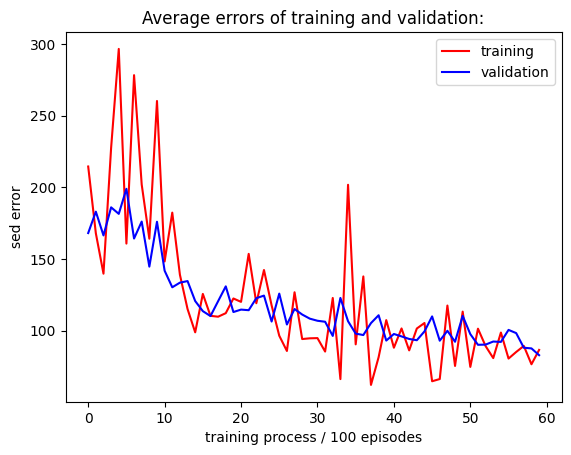

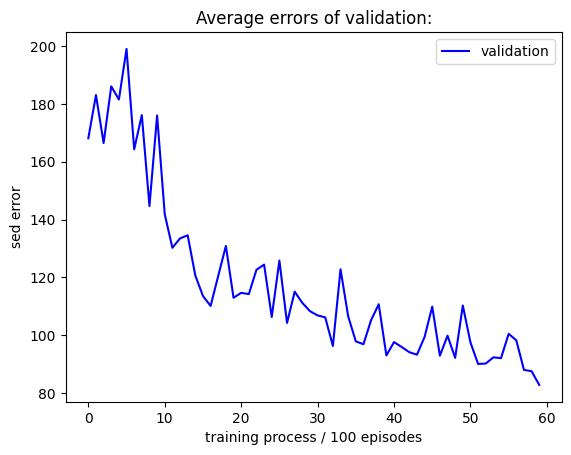

In [4]:
train(traj_amount=200, valid_amount=70, Round=30, show_time=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='sed')#main

In [9]:
test_all(model_path='save_skip/82.85171469141463_ratio_0.1_sed/', amount=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='sed')

======Start testing the model at'save_skip/82.85171469141463_ratio_0.1_sed/======'
======loading test data======
It cost 3.3599157333374023s
training from last checkpoint save_skip/82.85171469141463_ratio_0.1_sed/
INFO:tensorflow:Restoring parameters from save_skip/82.85171469141463_ratio_0.1_sed/trained_model.ckpt
Effectiveness of different errors: sed:80.5305, ped:26.0581, dad:2.3366, sad:10.3625
Testing elapsed time = 19.4296s, 13.6260s, 13.7604s, 31.8097s
Effectiveness of different ratios: 0.1:76.7861, 0.2:27.5672, 0.3:19.9394, 0.4:11.8162, 0.5:11.6257
Testing elapsed time = 18.7153s, 17.2114s, 15.7100s, 14.2502s, 12.0925s


======loading train data======
It cost 6.840389966964722s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


round 0 episode 100: Training error: 73.74075665302196, Validation error: 112.88800412681357
Save model with error 112.88800412681357
==>current best model is 112.88800412681357 with ratio 0.1
It costs 145.76307940483093s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48it/s]


round 0 episode 200: Training error: 54.99486384012646, Validation error: 90.02285413266547
Save model with error 90.02285413266547
==>current best model is 90.02285413266547 with ratio 0.1
It costs 134.4384217262268s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


round 1 episode 100: Training error: 61.89655769074355, Validation error: 91.57474782045063
==>current best model is 90.02285413266547 with ratio 0.1
It costs 144.32361602783203s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


round 1 episode 200: Training error: 80.17866716092354, Validation error: 72.77253972635228
Save model with error 72.77253972635228
==>current best model is 72.77253972635228 with ratio 0.1
It costs 166.5430610179901s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s]


round 2 episode 100: Training error: 48.30902096309358, Validation error: 64.49064823567177
Save model with error 64.49064823567177
==>current best model is 64.49064823567177 with ratio 0.1
It costs 166.44558215141296s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


round 2 episode 200: Training error: 91.75030376276898, Validation error: 77.88146791518288
==>current best model is 64.49064823567177 with ratio 0.1
It costs 176.24998378753662s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.15s/it]


round 3 episode 100: Training error: 64.18053200282003, Validation error: 61.68101995672606
Save model with error 61.68101995672606
==>current best model is 61.68101995672606 with ratio 0.1
It costs 243.24875688552856s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


round 3 episode 200: Training error: 45.20628575446355, Validation error: 56.8891769126815
Save model with error 56.8891769126815
==>current best model is 56.8891769126815 with ratio 0.1
It costs 264.1920380592346s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


round 4 episode 100: Training error: 43.52338822148864, Validation error: 87.25880972825276
==>current best model is 56.8891769126815 with ratio 0.1
It costs 315.8224198818207s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:59<00:00,  1.79s/it]


round 4 episode 200: Training error: 64.30995598391767, Validation error: 69.1517278443465
==>current best model is 56.8891769126815 with ratio 0.1
It costs 294.8659620285034s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15it/s]


round 5 episode 100: Training error: 51.91684779543779, Validation error: 57.82629687887329
==>current best model is 56.8891769126815 with ratio 0.1
It costs 173.33825540542603s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


round 5 episode 200: Training error: 62.45336252395665, Validation error: 67.09632287146142
==>current best model is 56.8891769126815 with ratio 0.1
It costs 186.37533116340637s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


round 6 episode 100: Training error: 35.38113806140189, Validation error: 61.194658904462926
==>current best model is 56.8891769126815 with ratio 0.1
It costs 178.15765357017517s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.08s/it]


round 6 episode 200: Training error: 53.252097152853075, Validation error: 72.30888640249115
==>current best model is 56.8891769126815 with ratio 0.1
It costs 201.3729372024536s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.15s/it]


round 7 episode 100: Training error: 39.98166958367585, Validation error: 61.03290350701191
==>current best model is 56.8891769126815 with ratio 0.1
It costs 206.93466329574585s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


round 7 episode 200: Training error: 41.37556115768688, Validation error: 61.59738172912587
==>current best model is 56.8891769126815 with ratio 0.1
It costs 174.46455144882202s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


round 8 episode 100: Training error: 48.460599984394364, Validation error: 70.61224355945345
==>current best model is 56.8891769126815 with ratio 0.1
It costs 194.88749146461487s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/it]


round 8 episode 200: Training error: 53.977351877236266, Validation error: 53.060087388905536
Save model with error 53.060087388905536
==>current best model is 53.060087388905536 with ratio 0.1
It costs 206.14078426361084s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.04it/s]


round 9 episode 100: Training error: 62.57910746447234, Validation error: 54.978818879151056
==>current best model is 53.060087388905536 with ratio 0.1
It costs 193.26386094093323s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


round 9 episode 200: Training error: 30.31452654599748, Validation error: 50.39286103960069
Save model with error 50.39286103960069
==>current best model is 50.39286103960069 with ratio 0.1
It costs 211.04828262329102s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15it/s]


round 10 episode 100: Training error: 38.87234907940171, Validation error: 80.09059404438891
==>current best model is 50.39286103960069 with ratio 0.1
It costs 186.95960116386414s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]


round 10 episode 200: Training error: 49.076020582567, Validation error: 60.87086653199356
==>current best model is 50.39286103960069 with ratio 0.1
It costs 223.46550989151s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.00it/s]


round 11 episode 100: Training error: 32.47467451677357, Validation error: 54.30131865677721
==>current best model is 50.39286103960069 with ratio 0.1
It costs 201.13349223136902s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.10s/it]


round 11 episode 200: Training error: 45.11447231086401, Validation error: 47.88464125172601
Save model with error 47.88464125172601
==>current best model is 47.88464125172601 with ratio 0.1
It costs 213.70179200172424s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.16s/it]


round 12 episode 100: Training error: 38.89700302097718, Validation error: 64.72819063114035
==>current best model is 47.88464125172601 with ratio 0.1
It costs 220.01392245292664s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.11s/it]


round 12 episode 200: Training error: 67.09138089322998, Validation error: 58.92280059920496
==>current best model is 47.88464125172601 with ratio 0.1
It costs 219.17277479171753s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


round 13 episode 100: Training error: 68.2453577888051, Validation error: 57.05457228607033
==>current best model is 47.88464125172601 with ratio 0.1
It costs 222.4158787727356s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.05s/it]


round 13 episode 200: Training error: 22.92392607738751, Validation error: 54.49368801525169
==>current best model is 47.88464125172601 with ratio 0.1
It costs 206.80367517471313s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.00s/it]


round 14 episode 100: Training error: 38.67333878272383, Validation error: 52.760102660968464
==>current best model is 47.88464125172601 with ratio 0.1
It costs 202.41789555549622s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.22s/it]


round 14 episode 200: Training error: 32.93396987122262, Validation error: 52.92539231326635
==>current best model is 47.88464125172601 with ratio 0.1
It costs 225.09583020210266s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


round 15 episode 100: Training error: 42.374960421893554, Validation error: 41.104960483618804
Save model with error 41.104960483618804
==>current best model is 41.104960483618804 with ratio 0.1
It costs 220.87978315353394s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.07s/it]


round 15 episode 200: Training error: 33.25113088231164, Validation error: 47.631034730095976
==>current best model is 41.104960483618804 with ratio 0.1
It costs 210.9999225139618s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


round 16 episode 100: Training error: 40.732043080187616, Validation error: 46.825632939179734
==>current best model is 41.104960483618804 with ratio 0.1
It costs 203.08629727363586s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.27s/it]


round 16 episode 200: Training error: 21.68272021254757, Validation error: 38.45956284555599
Save model with error 38.45956284555599
==>current best model is 38.45956284555599 with ratio 0.1
It costs 232.27622365951538s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


round 17 episode 100: Training error: 23.040976588213447, Validation error: 53.85209849832211
==>current best model is 38.45956284555599 with ratio 0.1
It costs 224.91673111915588s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/it]


round 17 episode 200: Training error: 34.74995907783684, Validation error: 52.72283442717562
==>current best model is 38.45956284555599 with ratio 0.1
It costs 213.8316674232483s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]


round 18 episode 100: Training error: 43.29592308549965, Validation error: 40.47001291070615
==>current best model is 38.45956284555599 with ratio 0.1
It costs 232.29685378074646s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.05s/it]


round 18 episode 200: Training error: 24.63450086378539, Validation error: 40.593397423459564
==>current best model is 38.45956284555599 with ratio 0.1
It costs 211.73862552642822s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


round 19 episode 100: Training error: 61.525059732093744, Validation error: 38.019102836003995
Save model with error 38.019102836003995
==>current best model is 38.019102836003995 with ratio 0.1
It costs 221.93946313858032s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.15s/it]


round 19 episode 200: Training error: 24.050023699030547, Validation error: 45.4910848513941
==>current best model is 38.019102836003995 with ratio 0.1
It costs 223.88957500457764s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


round 20 episode 100: Training error: 51.73179649009113, Validation error: 42.73252666512855
==>current best model is 38.019102836003995 with ratio 0.1
It costs 201.1058225631714s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]


round 20 episode 200: Training error: 30.51090052165118, Validation error: 51.45029984538662
==>current best model is 38.019102836003995 with ratio 0.1
It costs 246.5074028968811s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:01<00:00,  1.21s/it]


round 21 episode 100: Training error: 35.594548118432925, Validation error: 41.508225653342414
==>current best model is 38.019102836003995 with ratio 0.1
It costs 230.6342432498932s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.10s/it]


round 21 episode 200: Training error: 24.943572008738343, Validation error: 41.630846056700854
==>current best model is 38.019102836003995 with ratio 0.1
It costs 219.21473932266235s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.23s/it]


round 22 episode 100: Training error: 34.54816383037673, Validation error: 43.688961465965235
==>current best model is 38.019102836003995 with ratio 0.1
It costs 231.97087955474854s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.08s/it]


round 22 episode 200: Training error: 38.92932812089995, Validation error: 41.28811375135637
==>current best model is 38.019102836003995 with ratio 0.1
It costs 215.88514065742493s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:20<00:00,  1.40s/it]


round 23 episode 100: Training error: 56.218352795842996, Validation error: 47.07242019296885
==>current best model is 38.019102836003995 with ratio 0.1
It costs 259.4966812133789s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.02it/s]


round 23 episode 200: Training error: 22.137117790960566, Validation error: 51.9789825650922
==>current best model is 38.019102836003995 with ratio 0.1
It costs 205.79970264434814s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.10s/it]


round 24 episode 100: Training error: 31.185540600289826, Validation error: 51.30520511872061
==>current best model is 38.019102836003995 with ratio 0.1
It costs 218.31701111793518s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:01<00:00,  1.21s/it]


round 24 episode 200: Training error: 25.808251163585787, Validation error: 50.710993305896444
==>current best model is 38.019102836003995 with ratio 0.1
It costs 230.00394463539124s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.21s/it]


round 25 episode 100: Training error: 33.46033382743563, Validation error: 43.68068339197691
==>current best model is 38.019102836003995 with ratio 0.1
It costs 231.99008011817932s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.23s/it]


round 25 episode 200: Training error: 21.40852969515779, Validation error: 39.56816080740405
==>current best model is 38.019102836003995 with ratio 0.1
It costs 241.82910013198853s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.66s/it]


round 26 episode 100: Training error: 32.45173293769453, Validation error: 42.861214258832284
==>current best model is 38.019102836003995 with ratio 0.1
It costs 283.77724742889404s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


round 26 episode 200: Training error: 28.325687412001226, Validation error: 43.07963123394134
==>current best model is 38.019102836003995 with ratio 0.1
It costs 223.41353702545166s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.43s/it]


round 27 episode 100: Training error: 22.597041492514872, Validation error: 50.87037475442894
==>current best model is 38.019102836003995 with ratio 0.1
It costs 264.97980999946594s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.00s/it]


round 27 episode 200: Training error: 36.16862487606201, Validation error: 44.54524996889358
==>current best model is 38.019102836003995 with ratio 0.1
It costs 211.0798304080963s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.34s/it]


round 28 episode 100: Training error: 25.992955694883584, Validation error: 51.760040890862555
==>current best model is 38.019102836003995 with ratio 0.1
It costs 246.80780005455017s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.07s/it]


round 28 episode 200: Training error: 41.28189933920312, Validation error: 50.76461033340937
==>current best model is 38.019102836003995 with ratio 0.1
It costs 217.58062553405762s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]


round 29 episode 100: Training error: 32.61909597651756, Validation error: 45.036928879418504
==>current best model is 38.019102836003995 with ratio 0.1
It costs 237.74917936325073s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.19s/it]


round 29 episode 200: Training error: 50.61437000442112, Validation error: 47.334275660137685
==>current best model is 38.019102836003995 with ratio 0.1
It costs 228.63321018218994s
Training elapsed time = %s 12941.693534851074


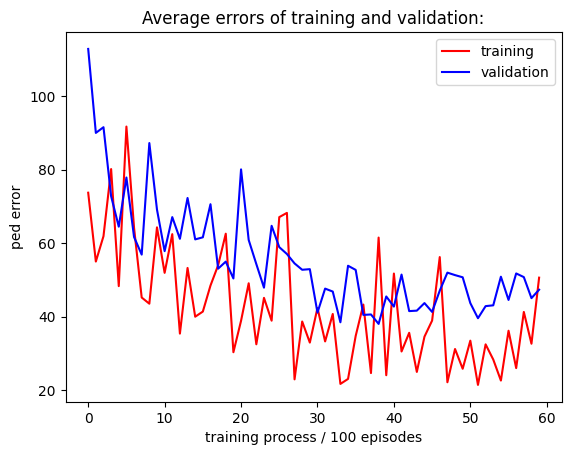

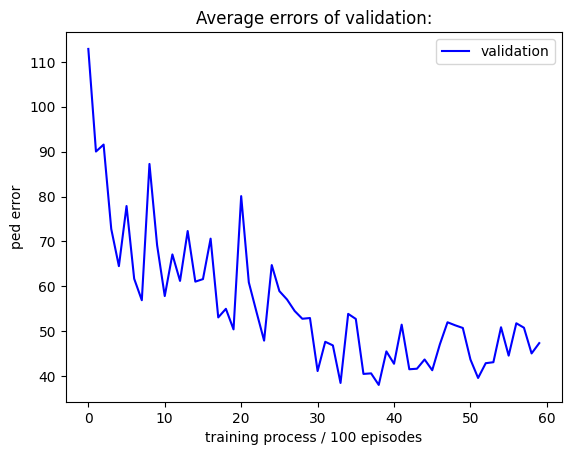

In [10]:
train(traj_amount=200, valid_amount=70, Round=30, show_time=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='ped')#main

In [4]:
test_all(model_path='save_skip/38.019102836003995_ratio_0.1_ped/', amount=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='ped')

======Start testing the model at'save_skip/38.019102836003995_ratio_0.1_ped/======'
======loading test data======
It cost 3.240588426589966s

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.





training from last checkpoint save_skip/38.019102836003995_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save_skip/38.019102836003995_ratio_0.1_ped/trained_model.ckpt
Effectiveness of different errors: sed:78.9061, ped:31.0178, dad:2.3478, sad:9.3380
Testing elapsed time = 19.5701s, 14.0261s, 13.7718s, 31.8181s
Effectiveness of different ratios: 0.1:33.1185, 0.2:13.8428, 0.3:8.4795, 0.4:8.3081, 0.5:7.8622
Testing elapsed time = 14.0055s, 13.2814s, 11.6531s, 10.3103s, 8.8288s
Effectiveness of different errors: sed:84.8605, ped:30.5345, dad:2.3478, sad:10.4060
Testing elapsed time = 18.9690s, 13.7973s, 13.8986s, 32.2073s
Effectiveness of different ratios: 0.1:29.0490, 0.2:15.6752, 0.3:11.9501, 0.4:8.8808,

======loading train data======
It cost 6.899095058441162s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


round 0 episode 100: Training error: 2.8681828292000087, Validation error: 2.7450935934773346
Save model with error 2.7450935934773346
==>current best model is 2.7450935934773346 with ratio 0.1
It costs 172.82504725456238s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


round 0 episode 200: Training error: 2.6473597998764804, Validation error: 2.7304646353155975
Save model with error 2.7304646353155975
==>current best model is 2.7304646353155975 with ratio 0.1
It costs 159.0988748073578s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.05it/s]


round 1 episode 100: Training error: 2.7997070313775407, Validation error: 2.7611744662786313
==>current best model is 2.7304646353155975 with ratio 0.1
It costs 176.2211356163025s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


round 1 episode 200: Training error: 2.647887562073845, Validation error: 2.6590811464232234
Save model with error 2.6590811464232234
==>current best model is 2.6590811464232234 with ratio 0.1
It costs 161.5163516998291s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.04s/it]


round 2 episode 100: Training error: 2.5755410690928056, Validation error: 2.733917074448784
==>current best model is 2.6590811464232234 with ratio 0.1
It costs 185.28655862808228s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.37it/s]


round 2 episode 200: Training error: 2.7326895193023932, Validation error: 2.6373701878068156
Save model with error 2.6373701878068156
==>current best model is 2.6373701878068156 with ratio 0.1
It costs 158.96184420585632s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


round 3 episode 100: Training error: 2.6631942429925077, Validation error: 2.4879743637372576
Save model with error 2.4879743637372576
==>current best model is 2.4879743637372576 with ratio 0.1
It costs 185.76307821273804s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


round 3 episode 200: Training error: 2.662760598866612, Validation error: 2.5603844685823836
==>current best model is 2.4879743637372576 with ratio 0.1
It costs 178.1367654800415s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


round 4 episode 100: Training error: 2.6622619722207657, Validation error: 2.5132144267633794
==>current best model is 2.4879743637372576 with ratio 0.1
It costs 194.3760643005371s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


round 4 episode 200: Training error: 2.4423999840235893, Validation error: 2.404709758941257
Save model with error 2.404709758941257
==>current best model is 2.404709758941257 with ratio 0.1
It costs 190.51862835884094s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.04s/it]


round 5 episode 100: Training error: 2.506561308874323, Validation error: 2.4942944504131788
==>current best model is 2.404709758941257 with ratio 0.1
It costs 201.34093189239502s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/it]


round 5 episode 200: Training error: 2.5287860070569628, Validation error: 2.441128327471934
==>current best model is 2.404709758941257 with ratio 0.1
It costs 202.3498876094818s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.00it/s]


round 6 episode 100: Training error: 2.433332191431626, Validation error: 2.344788737259984
Save model with error 2.344788737259984
==>current best model is 2.344788737259984 with ratio 0.1
It costs 205.48827052116394s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.26s/it]


round 6 episode 200: Training error: 2.3187732322696446, Validation error: 2.2244522580851953
Save model with error 2.2244522580851953
==>current best model is 2.2244522580851953 with ratio 0.1
It costs 233.52475452423096s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.22s/it]


round 7 episode 100: Training error: 2.3823282306012126, Validation error: 2.103424729397594
Save model with error 2.103424729397594
==>current best model is 2.103424729397594 with ratio 0.1
It costs 225.51391887664795s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


round 7 episode 200: Training error: 2.1695205311080294, Validation error: 2.1957886068190673
==>current best model is 2.103424729397594 with ratio 0.1
It costs 206.09150886535645s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.02it/s]


round 8 episode 100: Training error: 2.171292116921041, Validation error: 2.089317456138593
Save model with error 2.089317456138593
==>current best model is 2.089317456138593 with ratio 0.1
It costs 203.722562789917s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.30s/it]


round 8 episode 200: Training error: 2.3125056862548887, Validation error: 1.9767626554016504
Save model with error 1.9767626554016504
==>current best model is 1.9767626554016504 with ratio 0.1
It costs 237.33055973052979s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


round 9 episode 100: Training error: 2.0659102531037767, Validation error: 1.9979789593383304
==>current best model is 1.9767626554016504 with ratio 0.1
It costs 221.1979558467865s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


round 9 episode 200: Training error: 2.1118883837536915, Validation error: 1.891029814876945
Save model with error 1.891029814876945
==>current best model is 1.891029814876945 with ratio 0.1
It costs 223.534024477005s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.20s/it]


round 10 episode 100: Training error: 2.0772759894159827, Validation error: 1.9632927327537821
==>current best model is 1.891029814876945 with ratio 0.1
It costs 228.50913953781128s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.13s/it]


round 10 episode 200: Training error: 2.0486553033194452, Validation error: 1.9305651582384737
==>current best model is 1.891029814876945 with ratio 0.1
It costs 225.96376085281372s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.07s/it]


round 11 episode 100: Training error: 2.0922581056860143, Validation error: 1.8898382950453652
Save model with error 1.8898382950453652
==>current best model is 1.8898382950453652 with ratio 0.1
It costs 217.0137267112732s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


round 11 episode 200: Training error: 1.965015411804379, Validation error: 1.8714419732427643
Save model with error 1.8714419732427643
==>current best model is 1.8714419732427643 with ratio 0.1
It costs 239.58279514312744s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.35s/it]


round 12 episode 100: Training error: 1.9160929965880265, Validation error: 1.9074650876947685
==>current best model is 1.8714419732427643 with ratio 0.1
It costs 245.46274065971375s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


round 12 episode 200: Training error: 1.9808179625931612, Validation error: 1.892822848758965
==>current best model is 1.8714419732427643 with ratio 0.1
It costs 211.62128114700317s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.24s/it]


round 13 episode 100: Training error: 2.0041176474107885, Validation error: 1.8657737406848554
Save model with error 1.8657737406848554
==>current best model is 1.8657737406848554 with ratio 0.1
It costs 234.9265034198761s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


round 13 episode 200: Training error: 1.962682617900241, Validation error: 1.8216847982613213
Save model with error 1.8216847982613213
==>current best model is 1.8216847982613213 with ratio 0.1
It costs 221.94046235084534s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:01<00:00,  1.21s/it]


round 14 episode 100: Training error: 1.978393380805448, Validation error: 1.8244166918022864
==>current best model is 1.8216847982613213 with ratio 0.1
It costs 230.92428827285767s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.15s/it]


round 14 episode 200: Training error: 1.9164030763385442, Validation error: 1.7951856445788685
Save model with error 1.7951856445788685
==>current best model is 1.7951856445788685 with ratio 0.1
It costs 226.0628855228424s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.34s/it]


round 15 episode 100: Training error: 2.001383362017907, Validation error: 1.7551091020355198
Save model with error 1.7551091020355198
==>current best model is 1.7551091020355198 with ratio 0.1
It costs 245.36539363861084s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


round 15 episode 200: Training error: 1.894986452815166, Validation error: 1.8104097731163145
==>current best model is 1.7551091020355198 with ratio 0.1
It costs 219.94657492637634s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.20s/it]


round 16 episode 100: Training error: 1.8721334800358125, Validation error: 1.780492179933114
==>current best model is 1.7551091020355198 with ratio 0.1
It costs 286.5364742279053s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:46<00:00,  2.27s/it]


round 16 episode 200: Training error: 1.9572126122823539, Validation error: 1.7651902019650458
==>current best model is 1.7551091020355198 with ratio 0.1
It costs 432.24661445617676s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [04:16<00:00,  2.57s/it]


round 17 episode 100: Training error: 1.9189350026390428, Validation error: 1.7347405242977614
Save model with error 1.7347405242977614
==>current best model is 1.7347405242977614 with ratio 0.1
It costs 400.0204772949219s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.00it/s]


round 17 episode 200: Training error: 1.87208347448223, Validation error: 1.767609912375038
==>current best model is 1.7347405242977614 with ratio 0.1
It costs 210.2448751926422s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


round 18 episode 100: Training error: 1.854548812731767, Validation error: 1.7912259611546772
==>current best model is 1.7347405242977614 with ratio 0.1
It costs 208.3049499988556s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.39s/it]


round 18 episode 200: Training error: 1.8713284858348131, Validation error: 1.7377115037160837
==>current best model is 1.7347405242977614 with ratio 0.1
It costs 251.67492604255676s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


round 19 episode 100: Training error: 1.9807598643557482, Validation error: 1.724949049498422
Save model with error 1.724949049498422
==>current best model is 1.724949049498422 with ratio 0.1
It costs 240.3945746421814s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


round 19 episode 200: Training error: 1.852424272621701, Validation error: 1.801407340917597
==>current best model is 1.724949049498422 with ratio 0.1
It costs 216.3668713569641s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


round 20 episode 100: Training error: 1.914675343797231, Validation error: 1.763793941768191
==>current best model is 1.724949049498422 with ratio 0.1
It costs 208.42669987678528s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.37s/it]


round 20 episode 200: Training error: 1.8088334721385093, Validation error: 1.704711859596618
Save model with error 1.704711859596618
==>current best model is 1.704711859596618 with ratio 0.1
It costs 247.76150059700012s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.12s/it]


round 21 episode 100: Training error: 1.7755425032338803, Validation error: 1.7538104366809941
==>current best model is 1.704711859596618 with ratio 0.1
It costs 223.28421878814697s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.28s/it]


round 21 episode 200: Training error: 1.9254096634806503, Validation error: 1.6904936607982026
Save model with error 1.6904936607982026
==>current best model is 1.6904936607982026 with ratio 0.1
It costs 242.69101285934448s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.23s/it]


round 22 episode 100: Training error: 1.8318124732834522, Validation error: 1.7216968466123417
==>current best model is 1.6904936607982026 with ratio 0.1
It costs 232.81344628334045s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.13s/it]


round 22 episode 200: Training error: 1.910097278407043, Validation error: 1.7123938509000447
==>current best model is 1.6904936607982026 with ratio 0.1
It costs 221.39580655097961s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.15s/it]


round 23 episode 100: Training error: 1.929336498692133, Validation error: 1.7016345156704618
==>current best model is 1.6904936607982026 with ratio 0.1
It costs 223.91793417930603s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]


round 23 episode 200: Training error: 1.7714930720457647, Validation error: 1.687268880133019
Save model with error 1.687268880133019
==>current best model is 1.687268880133019 with ratio 0.1
It costs 228.0369107723236s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.30s/it]


round 24 episode 100: Training error: 1.853821885402218, Validation error: 1.7325475251818738
==>current best model is 1.687268880133019 with ratio 0.1
It costs 238.38504719734192s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it]


round 24 episode 200: Training error: 1.8686786411862102, Validation error: 1.6929067345179056
==>current best model is 1.687268880133019 with ratio 0.1
It costs 214.03789854049683s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/it]


round 25 episode 100: Training error: 1.8863216068851045, Validation error: 1.6721235185041117
Save model with error 1.6721235185041117
==>current best model is 1.6721235185041117 with ratio 0.1
It costs 218.31496620178223s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:07<00:00,  1.28s/it]


round 25 episode 200: Training error: 1.7621524050521333, Validation error: 1.7030868757483741
==>current best model is 1.6721235185041117 with ratio 0.1
It costs 238.02519130706787s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.13s/it]


round 26 episode 100: Training error: 1.731047946004074, Validation error: 1.7019687011940194
==>current best model is 1.6721235185041117 with ratio 0.1
It costs 222.8832175731659s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.23s/it]


round 26 episode 200: Training error: 1.9416168086914194, Validation error: 1.6752805601071508
==>current best model is 1.6721235185041117 with ratio 0.1
It costs 233.32094264030457s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


round 27 episode 100: Training error: 1.8714862975486406, Validation error: 1.6905569572779893
==>current best model is 1.6721235185041117 with ratio 0.1
It costs 226.3915627002716s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.24s/it]


round 27 episode 200: Training error: 1.8189276268142485, Validation error: 1.6555875820671595
Save model with error 1.6555875820671595
==>current best model is 1.6555875820671595 with ratio 0.1
It costs 235.70732378959656s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:01<00:00,  1.21s/it]


round 28 episode 100: Training error: 1.8260023576756068, Validation error: 1.661999416611176
==>current best model is 1.6555875820671595 with ratio 0.1
It costs 230.60019826889038s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:53<00:00,  1.13s/it]


round 28 episode 200: Training error: 1.827176947530986, Validation error: 1.6626949439823573
==>current best model is 1.6555875820671595 with ratio 0.1
It costs 221.60155034065247s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


round 29 episode 100: Training error: 1.9073369094417012, Validation error: 1.7339665496574022
==>current best model is 1.6555875820671595 with ratio 0.1
It costs 209.82117819786072s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.33s/it]


round 29 episode 200: Training error: 1.7313021910963624, Validation error: 1.6459629475394306
Save model with error 1.6459629475394306
==>current best model is 1.6459629475394306 with ratio 0.1
It costs 242.7111895084381s
Training elapsed time = %s 13476.04196858406


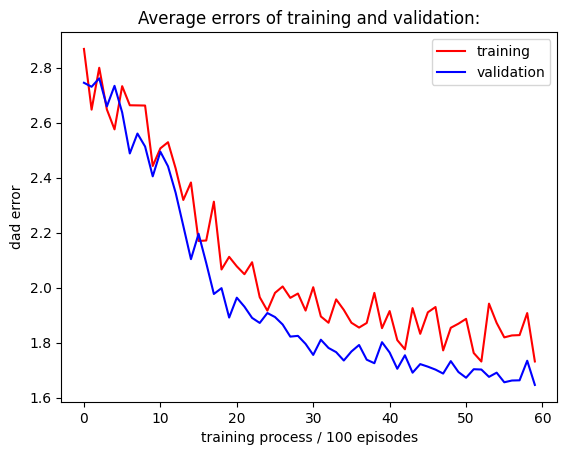

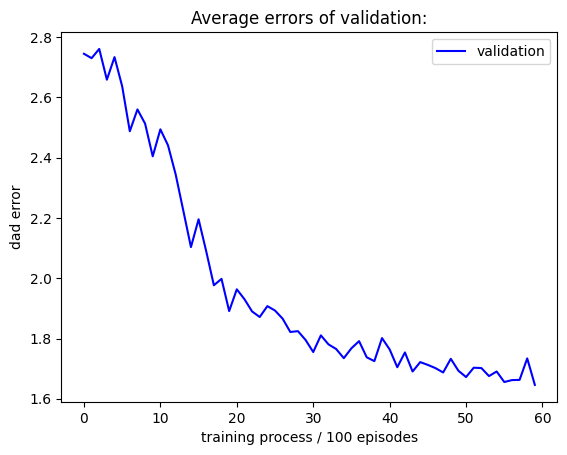

In [5]:
train(traj_amount=200, valid_amount=70, Round=30, show_time=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='dad')#main

======loading train data======
It cost 5.766041994094849s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


round 0 episode 100: Training error: 18.423214186031814, Validation error: 19.221600913713395
Save model with error 19.221600913713395
==>current best model is 19.221600913713395 with ratio 0.1
It costs 179.9243085384369s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]


round 0 episode 200: Training error: 21.200416284882866, Validation error: 20.859383827539432
==>current best model is 19.221600913713395 with ratio 0.1
It costs 205.94549870491028s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


round 1 episode 100: Training error: 21.13145991451038, Validation error: 19.60492362305361
==>current best model is 19.221600913713395 with ratio 0.1
It costs 223.84267568588257s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


round 1 episode 200: Training error: 17.145575280973873, Validation error: 22.53986158846817
==>current best model is 19.221600913713395 with ratio 0.1
It costs 190.5220010280609s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.23s/it]


round 2 episode 100: Training error: 22.11269686921209, Validation error: 17.600117254574016
Save model with error 17.600117254574016
==>current best model is 17.600117254574016 with ratio 0.1
It costs 219.58728575706482s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.07s/it]


round 2 episode 200: Training error: 18.411915856779398, Validation error: 16.416524906596273
Save model with error 16.416524906596273
==>current best model is 16.416524906596273 with ratio 0.1
It costs 205.79132342338562s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:07<00:00,  1.27s/it]


round 3 episode 100: Training error: 18.532110822075385, Validation error: 15.5862823628405
Save model with error 15.5862823628405
==>current best model is 15.5862823628405 with ratio 0.1
It costs 229.23488926887512s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.24s/it]


round 3 episode 200: Training error: 15.81664598380675, Validation error: 14.260077182243636
Save model with error 14.260077182243636
==>current best model is 14.260077182243636 with ratio 0.1
It costs 230.61251664161682s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.35s/it]


round 4 episode 100: Training error: 14.654514900821798, Validation error: 13.819899714186324
Save model with error 13.819899714186324
==>current best model is 13.819899714186324 with ratio 0.1
It costs 243.77981734275818s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.28s/it]


round 4 episode 200: Training error: 13.719662360540886, Validation error: 14.74686833777209
==>current best model is 13.819899714186324 with ratio 0.1
It costs 239.8974962234497s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.25s/it]


round 5 episode 100: Training error: 11.789960928160372, Validation error: 15.853589021200683
==>current best model is 13.819899714186324 with ratio 0.1
It costs 238.08769488334656s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.48s/it]


round 5 episode 200: Training error: 11.05737306201204, Validation error: 11.77080820900389
Save model with error 11.77080820900389
==>current best model is 11.77080820900389 with ratio 0.1
It costs 263.7096767425537s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.41s/it]


round 6 episode 100: Training error: 11.959103839760447, Validation error: 12.468256909926485
==>current best model is 11.77080820900389 with ratio 0.1
It costs 256.9171726703644s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]


round 6 episode 200: Training error: 10.635211307830378, Validation error: 9.37723544329124
Save model with error 9.37723544329124
==>current best model is 9.37723544329124 with ratio 0.1
It costs 258.20949244499207s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.37s/it]


round 7 episode 100: Training error: 9.940883975856524, Validation error: 10.585428628947188
==>current best model is 9.37723544329124 with ratio 0.1
It costs 257.6322627067566s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.53s/it]


round 7 episode 200: Training error: 10.010421062605683, Validation error: 10.54560213092818
==>current best model is 9.37723544329124 with ratio 0.1
It costs 278.56571984291077s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.53s/it]


round 8 episode 100: Training error: 9.871603186243803, Validation error: 14.838418271571422
==>current best model is 9.37723544329124 with ratio 0.1
It costs 275.7451515197754s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.42s/it]


round 8 episode 200: Training error: 9.025739680615292, Validation error: 11.258993510282117
==>current best model is 9.37723544329124 with ratio 0.1
It costs 264.72521448135376s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.65s/it]


round 9 episode 100: Training error: 9.324122570077387, Validation error: 9.970686523321142
==>current best model is 9.37723544329124 with ratio 0.1
It costs 289.69663548469543s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


round 9 episode 200: Training error: 9.07323180484095, Validation error: 9.773908175387602
==>current best model is 9.37723544329124 with ratio 0.1
It costs 255.1697223186493s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.62s/it]


round 10 episode 100: Training error: 8.162201463251444, Validation error: 9.818387735200744
==>current best model is 9.37723544329124 with ratio 0.1
It costs 287.55079102516174s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.37s/it]


round 10 episode 200: Training error: 9.79682093074014, Validation error: 9.0747184097481
Save model with error 9.0747184097481
==>current best model is 9.0747184097481 with ratio 0.1
It costs 263.1428198814392s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:20<00:00,  1.41s/it]


round 11 episode 100: Training error: 8.676952803335283, Validation error: 8.220524378892549
Save model with error 8.220524378892549
==>current best model is 8.220524378892549 with ratio 0.1
It costs 266.48393177986145s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.58s/it]


round 11 episode 200: Training error: 8.01847084465817, Validation error: 8.665532531846631
==>current best model is 8.220524378892549 with ratio 0.1
It costs 282.92909955978394s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


round 12 episode 100: Training error: 7.199862120951586, Validation error: 9.168501035100936
==>current best model is 8.220524378892549 with ratio 0.1
It costs 284.76534032821655s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:20<00:00,  1.41s/it]


round 12 episode 200: Training error: 9.115508871280745, Validation error: 8.383778372498798
==>current best model is 8.220524378892549 with ratio 0.1
It costs 267.80794644355774s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:53<00:00,  1.73s/it]


round 13 episode 100: Training error: 8.157208930883995, Validation error: 8.931181095177928
==>current best model is 8.220524378892549 with ratio 0.1
It costs 300.7741024494171s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.32s/it]


round 13 episode 200: Training error: 8.561485195988562, Validation error: 8.678134655227419
==>current best model is 8.220524378892549 with ratio 0.1
It costs 258.8782033920288s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.46s/it]


round 14 episode 100: Training error: 8.322991417065182, Validation error: 8.88665173560678
==>current best model is 8.220524378892549 with ratio 0.1
It costs 273.13244009017944s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.62s/it]


round 14 episode 200: Training error: 8.086827129061332, Validation error: 7.987539608139293
Save model with error 7.987539608139293
==>current best model is 7.987539608139293 with ratio 0.1
It costs 290.9877119064331s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:03<00:00,  1.83s/it]


round 15 episode 100: Training error: 9.92307608998817, Validation error: 10.982792435671762
==>current best model is 7.987539608139293 with ratio 0.1
It costs 311.0469901561737s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:01<00:00,  1.21s/it]


round 15 episode 200: Training error: 7.503995672088458, Validation error: 8.56147109225419
==>current best model is 7.987539608139293 with ratio 0.1
It costs 246.3013813495636s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.67s/it]


round 16 episode 100: Training error: 7.660512475189665, Validation error: 7.895321638960762
Save model with error 7.895321638960762
==>current best model is 7.895321638960762 with ratio 0.1
It costs 295.2306339740753s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.40s/it]


round 16 episode 200: Training error: 7.886012856758604, Validation error: 8.03633801034717
==>current best model is 7.895321638960762 with ratio 0.1
It costs 268.2763578891754s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.51s/it]


round 17 episode 100: Training error: 7.843766493978203, Validation error: 8.135663186366854
==>current best model is 7.895321638960762 with ratio 0.1
It costs 279.3059837818146s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.57s/it]


round 17 episode 200: Training error: 7.230543723010394, Validation error: 7.934886627194066
==>current best model is 7.895321638960762 with ratio 0.1
It costs 286.00881457328796s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:50<00:00,  1.71s/it]


round 18 episode 100: Training error: 7.689230021746811, Validation error: 7.950660062618454
==>current best model is 7.895321638960762 with ratio 0.1
It costs 298.1976490020752s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.34s/it]


round 18 episode 200: Training error: 7.689785325400993, Validation error: 8.103933804265855
==>current best model is 7.895321638960762 with ratio 0.1
It costs 261.33920097351074s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.58s/it]


round 19 episode 100: Training error: 8.516066320172554, Validation error: 8.152224850281183
==>current best model is 7.895321638960762 with ratio 0.1
It costs 285.7049775123596s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.46s/it]


round 19 episode 200: Training error: 6.958953347759412, Validation error: 8.245194137199986
==>current best model is 7.895321638960762 with ratio 0.1
It costs 275.2381765842438s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.43s/it]


round 20 episode 100: Training error: 7.774903673853041, Validation error: 7.775406258095255
Save model with error 7.775406258095255
==>current best model is 7.775406258095255 with ratio 0.1
It costs 271.23131823539734s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.67s/it]


round 20 episode 200: Training error: 7.616717135689286, Validation error: 8.327774445370999
==>current best model is 7.775406258095255 with ratio 0.1
It costs 294.8316786289215s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:58<00:00,  1.79s/it]


round 21 episode 100: Training error: 6.755413664688574, Validation error: 8.214993326809315
==>current best model is 7.775406258095255 with ratio 0.1
It costs 306.8949646949768s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:07<00:00,  1.28s/it]


round 21 episode 200: Training error: 8.746108581589423, Validation error: 7.791543077157179
==>current best model is 7.775406258095255 with ratio 0.1
It costs 256.3206522464752s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:51<00:00,  1.72s/it]


round 22 episode 100: Training error: 7.567279137443929, Validation error: 7.816241203384952
==>current best model is 7.775406258095255 with ratio 0.1
It costs 300.49297642707825s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


round 22 episode 200: Training error: 7.763736714865864, Validation error: 8.355230280841877
==>current best model is 7.775406258095255 with ratio 0.1
It costs 264.83647179603577s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:20<00:00,  1.41s/it]


round 23 episode 100: Training error: 7.925990072404636, Validation error: 7.79402395522166
==>current best model is 7.775406258095255 with ratio 0.1
It costs 269.4080250263214s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.64s/it]


round 23 episode 200: Training error: 7.182101484837, Validation error: 7.896346407321793
==>current best model is 7.775406258095255 with ratio 0.1
It costs 291.48836970329285s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/it]


round 24 episode 100: Training error: 8.04587509824109, Validation error: 7.8632008393737545
==>current best model is 7.775406258095255 with ratio 0.1
It costs 274.24956727027893s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


round 24 episode 200: Training error: 7.633438194373964, Validation error: 8.024860574063345
==>current best model is 7.775406258095255 with ratio 0.1
It costs 285.91472721099854s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.44s/it]


round 25 episode 100: Training error: 7.098753223292615, Validation error: 7.991877804219575
==>current best model is 7.775406258095255 with ratio 0.1
It costs 272.138818025589s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]


round 25 episode 200: Training error: 7.737765946279658, Validation error: 7.961641374035531
==>current best model is 7.775406258095255 with ratio 0.1
It costs 287.18217492103577s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.48s/it]


round 26 episode 100: Training error: 7.84356949931778, Validation error: 7.938230933686855
==>current best model is 7.775406258095255 with ratio 0.1
It costs 277.888685464859s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


round 26 episode 200: Training error: 7.268997903826312, Validation error: 7.944583311671844
==>current best model is 7.775406258095255 with ratio 0.1
It costs 284.3090193271637s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:07<00:00,  1.27s/it]


round 27 episode 100: Training error: 6.8372769638951025, Validation error: 7.661226444250019
Save model with error 7.661226444250019
==>current best model is 7.661226444250019 with ratio 0.1
It costs 255.61052823066711s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:58<00:00,  1.79s/it]


round 27 episode 200: Training error: 8.052767363112498, Validation error: 7.720290724510715
==>current best model is 7.661226444250019 with ratio 0.1
It costs 307.0441575050354s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.21s/it]


round 28 episode 100: Training error: 7.835410282771136, Validation error: 7.683890984367362
==>current best model is 7.661226444250019 with ratio 0.1
It costs 248.86606359481812s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:01<00:00,  1.81s/it]


round 28 episode 200: Training error: 6.91568054031569, Validation error: 7.700773308289215
==>current best model is 7.661226444250019 with ratio 0.1
It costs 308.95944809913635s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.65s/it]


round 29 episode 100: Training error: 8.155041126460077, Validation error: 7.736349136244467
==>current best model is 7.661226444250019 with ratio 0.1
It costs 293.19495701789856s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.39s/it]


round 29 episode 200: Training error: 6.518903352417135, Validation error: 7.6422476838531805
Save model with error 7.6422476838531805
==>current best model is 7.6422476838531805 with ratio 0.1
It costs 267.9345781803131s
Training elapsed time = %s 16009.499103307724


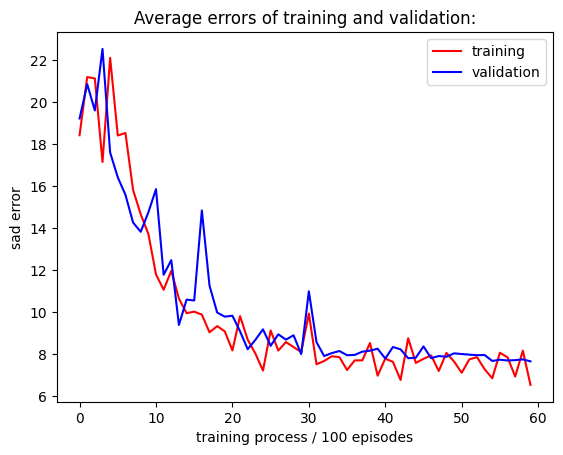

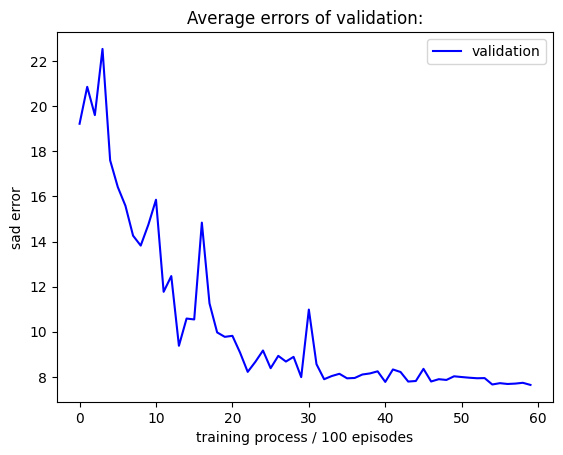

In [6]:
train(traj_amount=200, valid_amount=70, Round=30, show_time=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='sad')#main

======loading train data======
It cost 6.743560552597046s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


round 0 episode 100: Training error: 240.94033588859645, Validation error: 141.13383395449213
Save model with error 141.13383395449213
==>current best model is 141.13383395449213 with ratio 0.2
It costs 137.26099944114685s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.82it/s]


round 0 episode 200: Training error: 188.1524284444114, Validation error: 123.70562010859088
Save model with error 123.70562010859088
==>current best model is 123.70562010859088 with ratio 0.2
It costs 117.86728167533875s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]


round 1 episode 100: Training error: 100.52256816227853, Validation error: 111.46009709981256
Save model with error 111.46009709981256
==>current best model is 111.46009709981256 with ratio 0.2
It costs 126.92709183692932s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


round 1 episode 200: Training error: 191.536436193003, Validation error: 151.9373919866664
==>current best model is 111.46009709981256 with ratio 0.2
It costs 147.22070622444153s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.49it/s]


round 2 episode 100: Training error: 115.42253909550722, Validation error: 100.11924735776878
Save model with error 100.11924735776878
==>current best model is 100.11924735776878 with ratio 0.2
It costs 133.63099765777588s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.28it/s]


round 2 episode 200: Training error: 195.99783536414193, Validation error: 100.69491658316937
==>current best model is 100.11924735776878 with ratio 0.2
It costs 145.73742604255676s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


round 3 episode 100: Training error: 137.50300999576555, Validation error: 127.48778701729648
==>current best model is 100.11924735776878 with ratio 0.2
It costs 148.7833914756775s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


round 3 episode 200: Training error: 177.76475504283187, Validation error: 88.60070801469821
Save model with error 88.60070801469821
==>current best model is 88.60070801469821 with ratio 0.2
It costs 148.90305423736572s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


round 4 episode 100: Training error: 186.50053825439556, Validation error: 114.03272007715262
==>current best model is 88.60070801469821 with ratio 0.2
It costs 151.02596163749695s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


round 4 episode 200: Training error: 98.23542018929233, Validation error: 79.58748869048824
Save model with error 79.58748869048824
==>current best model is 79.58748869048824 with ratio 0.2
It costs 162.28261995315552s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


round 5 episode 100: Training error: 59.159538857645536, Validation error: 88.03038763207627
==>current best model is 79.58748869048824 with ratio 0.2
It costs 167.4309582710266s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.25it/s]


round 5 episode 200: Training error: 189.515896343337, Validation error: 67.60817534176113
Save model with error 67.60817534176113
==>current best model is 67.60817534176113 with ratio 0.2
It costs 161.20350003242493s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


round 6 episode 100: Training error: 74.33777080005547, Validation error: 79.44198579669121
==>current best model is 67.60817534176113 with ratio 0.2
It costs 174.46878838539124s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


round 6 episode 200: Training error: 59.129273529232144, Validation error: 77.17382005222727
==>current best model is 67.60817534176113 with ratio 0.2
It costs 178.4155032634735s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


round 7 episode 100: Training error: 51.56129121123072, Validation error: 47.596614529967546
Save model with error 47.596614529967546
==>current best model is 47.596614529967546 with ratio 0.2
It costs 182.84079432487488s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.06s/it]


round 7 episode 200: Training error: 46.56735807805576, Validation error: 36.122527801640665
Save model with error 36.122527801640665
==>current best model is 36.122527801640665 with ratio 0.2
It costs 198.91712164878845s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


round 8 episode 100: Training error: 40.679031965983825, Validation error: 34.52358322660188
Save model with error 34.52358322660188
==>current best model is 34.52358322660188 with ratio 0.2
It costs 197.66905546188354s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.05s/it]


round 8 episode 200: Training error: 87.60767122379485, Validation error: 42.95891868469775
==>current best model is 34.52358322660188 with ratio 0.2
It costs 199.19797539710999s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


round 9 episode 100: Training error: 39.6575411584428, Validation error: 43.26191317169907
==>current best model is 34.52358322660188 with ratio 0.2
It costs 188.30427169799805s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


round 9 episode 200: Training error: 48.57327776249963, Validation error: 50.92157314964257
==>current best model is 34.52358322660188 with ratio 0.2
It costs 211.78083419799805s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.11it/s]


round 10 episode 100: Training error: 35.50564953556446, Validation error: 48.630633615950956
==>current best model is 34.52358322660188 with ratio 0.2
It costs 186.67846298217773s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.23s/it]


round 10 episode 200: Training error: 30.326975261371036, Validation error: 41.71900648740546
==>current best model is 34.52358322660188 with ratio 0.2
It costs 219.71713042259216s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


round 11 episode 100: Training error: 31.04015939851838, Validation error: 35.137680180493255
==>current best model is 34.52358322660188 with ratio 0.2
It costs 188.27728605270386s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.23s/it]


round 11 episode 200: Training error: 25.699812799971323, Validation error: 35.2683498952669
==>current best model is 34.52358322660188 with ratio 0.2
It costs 220.70239973068237s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


round 12 episode 100: Training error: 23.783778505742795, Validation error: 35.106793489304806
==>current best model is 34.52358322660188 with ratio 0.2
It costs 191.7563328742981s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.24s/it]


round 12 episode 200: Training error: 33.654520525325815, Validation error: 32.95682297426615
Save model with error 32.95682297426615
==>current best model is 32.95682297426615 with ratio 0.2
It costs 224.33372020721436s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


round 13 episode 100: Training error: 31.429705506975676, Validation error: 40.91946076231004
==>current best model is 32.95682297426615 with ratio 0.2
It costs 193.86755466461182s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.25s/it]


round 13 episode 200: Training error: 28.47523586894347, Validation error: 30.35826902884711
Save model with error 30.35826902884711
==>current best model is 30.35826902884711 with ratio 0.2
It costs 224.6827311515808s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.11s/it]


round 14 episode 100: Training error: 23.882639114963272, Validation error: 27.956426829182483
Save model with error 27.956426829182483
==>current best model is 27.956426829182483 with ratio 0.2
It costs 212.11446332931519s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.10s/it]


round 14 episode 200: Training error: 28.052442260374338, Validation error: 34.641066032653825
==>current best model is 27.956426829182483 with ratio 0.2
It costs 210.1381266117096s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.23s/it]


round 15 episode 100: Training error: 21.921186209408024, Validation error: 30.62938970128083
==>current best model is 27.956426829182483 with ratio 0.2
It costs 228.51263284683228s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


round 15 episode 200: Training error: 27.659892563037992, Validation error: 32.818101767449996
==>current best model is 27.956426829182483 with ratio 0.2
It costs 198.87830471992493s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.08s/it]


round 16 episode 100: Training error: 31.84273741871405, Validation error: 28.687320343703608
==>current best model is 27.956426829182483 with ratio 0.2
It costs 209.88608574867249s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


round 16 episode 200: Training error: 17.274924506772727, Validation error: 35.2658986764296
==>current best model is 27.956426829182483 with ratio 0.2
It costs 215.64117884635925s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.03s/it]


round 17 episode 100: Training error: 30.865920512033817, Validation error: 31.164771211868757
==>current best model is 27.956426829182483 with ratio 0.2
It costs 203.30244302749634s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


round 17 episode 200: Training error: 21.362108097760277, Validation error: 26.766196374325
Save model with error 26.766196374325
==>current best model is 26.766196374325 with ratio 0.2
It costs 218.31031584739685s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


round 18 episode 100: Training error: 25.2408499867706, Validation error: 27.39364372420168
==>current best model is 26.766196374325 with ratio 0.2
It costs 204.34656977653503s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


round 18 episode 200: Training error: 26.720551146369495, Validation error: 26.27663815759755
Save model with error 26.27663815759755
==>current best model is 26.27663815759755 with ratio 0.2
It costs 238.88886737823486s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.03s/it]


round 19 episode 100: Training error: 21.766796092563105, Validation error: 26.067475087793156
Save model with error 26.067475087793156
==>current best model is 26.067475087793156 with ratio 0.2
It costs 205.21152186393738s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.20s/it]


round 19 episode 200: Training error: 24.88237071775563, Validation error: 29.59720213326417
==>current best model is 26.067475087793156 with ratio 0.2
It costs 221.5242702960968s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


round 20 episode 100: Training error: 26.143465730712823, Validation error: 28.66944091700877
==>current best model is 26.067475087793156 with ratio 0.2
It costs 207.42844986915588s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:53<00:00,  1.13s/it]


round 20 episode 200: Training error: 20.34101694914519, Validation error: 26.561739517251855
==>current best model is 26.067475087793156 with ratio 0.2
It costs 214.27383875846863s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.13s/it]


round 21 episode 100: Training error: 22.672579996986688, Validation error: 28.55005302614609
==>current best model is 26.067475087793156 with ratio 0.2
It costs 213.81255555152893s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/it]


round 21 episode 200: Training error: 22.183285805935594, Validation error: 26.974531328959987
==>current best model is 26.067475087793156 with ratio 0.2
It costs 209.977632522583s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


round 22 episode 100: Training error: 19.370601193492888, Validation error: 27.32107369117841
==>current best model is 26.067475087793156 with ratio 0.2
It costs 199.95852851867676s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.24s/it]


round 22 episode 200: Training error: 26.39529482715873, Validation error: 26.16803423425112
==>current best model is 26.067475087793156 with ratio 0.2
It costs 226.84639048576355s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]


round 23 episode 100: Training error: 16.083370840327063, Validation error: 28.837585171602164
==>current best model is 26.067475087793156 with ratio 0.2
It costs 220.41020154953003s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


round 23 episode 200: Training error: 29.02148941211911, Validation error: 27.4217382116453
==>current best model is 26.067475087793156 with ratio 0.2
It costs 211.42549800872803s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/it]


round 24 episode 100: Training error: 18.020547830955643, Validation error: 27.795882249639888
==>current best model is 26.067475087793156 with ratio 0.2
It costs 206.73233127593994s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]


round 24 episode 200: Training error: 26.71437513404858, Validation error: 29.222980796329562
==>current best model is 26.067475087793156 with ratio 0.2
It costs 219.65584349632263s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


round 25 episode 100: Training error: 20.78836538182054, Validation error: 26.826249740615857
==>current best model is 26.067475087793156 with ratio 0.2
It costs 213.63797402381897s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.10s/it]


round 25 episode 200: Training error: 24.215998913554824, Validation error: 27.978609269912237
==>current best model is 26.067475087793156 with ratio 0.2
It costs 213.0498402118683s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.10s/it]


round 26 episode 100: Training error: 17.76004950799056, Validation error: 25.40605788755389
Save model with error 25.40605788755389
==>current best model is 25.40605788755389 with ratio 0.2
It costs 213.08380103111267s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.12s/it]


round 26 episode 200: Training error: 27.953245384707106, Validation error: 27.548020767210332
==>current best model is 25.40605788755389 with ratio 0.2
It costs 214.63487076759338s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.13s/it]


round 27 episode 100: Training error: 29.427674532865048, Validation error: 27.640578786929606
==>current best model is 25.40605788755389 with ratio 0.2
It costs 216.90005207061768s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.11s/it]


round 27 episode 200: Training error: 18.223912796900283, Validation error: 27.544222182370294
==>current best model is 25.40605788755389 with ratio 0.2
It costs 213.20224380493164s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.23s/it]


round 28 episode 100: Training error: 20.082767574697183, Validation error: 26.29172403994761
==>current best model is 25.40605788755389 with ratio 0.2
It costs 225.57445430755615s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


round 28 episode 200: Training error: 26.086527865479596, Validation error: 27.443930276278294
==>current best model is 25.40605788755389 with ratio 0.2
It costs 203.16214847564697s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/it]


round 29 episode 100: Training error: 21.788727920777742, Validation error: 26.688988917205496
==>current best model is 25.40605788755389 with ratio 0.2
It costs 206.56048846244812s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.19s/it]


round 29 episode 200: Training error: 24.186835802308106, Validation error: 26.14597489314707
==>current best model is 25.40605788755389 with ratio 0.2
It costs 221.11010098457336s
Training elapsed time = %s 11768.082392692566


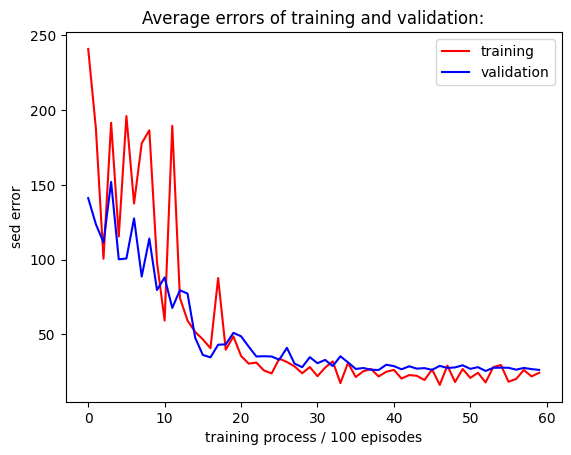

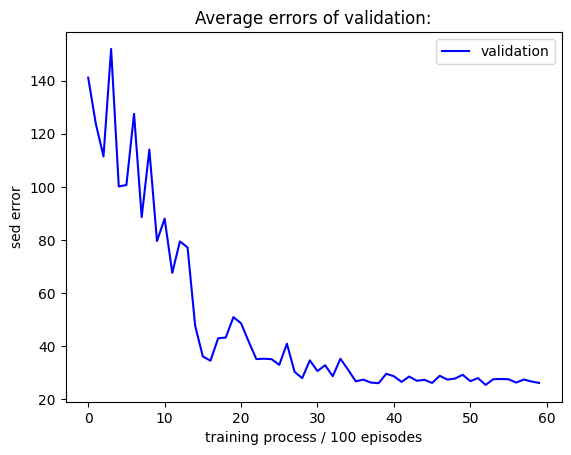

In [7]:
train(traj_amount=200, valid_amount=70, Round=30, show_time=100, ratio=0.2, a_size=3, s_size=3, skip_size=2, label='sed')

======loading train data======
It cost 5.7724573612213135s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.75it/s]


round 0 episode 100: Training error: 150.8577087454312, Validation error: 103.24530971402919
Save model with error 103.24530971402919
==>current best model is 103.24530971402919 with ratio 0.3
It costs 114.70431017875671s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.58it/s]


round 0 episode 200: Training error: 204.9136549369509, Validation error: 121.91296823660281
==>current best model is 103.24530971402919 with ratio 0.3
It costs 119.27515506744385s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


round 1 episode 100: Training error: 153.67931879479377, Validation error: 108.7001754650853
==>current best model is 103.24530971402919 with ratio 0.3
It costs 127.52172207832336s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.95it/s]


round 1 episode 200: Training error: 125.1454005134591, Validation error: 110.6390369774348
==>current best model is 103.24530971402919 with ratio 0.3
It costs 109.53621912002563s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s]


round 2 episode 100: Training error: 132.52709131291275, Validation error: 85.8602949501566
Save model with error 85.8602949501566
==>current best model is 85.8602949501566 with ratio 0.3
It costs 123.74497652053833s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


round 2 episode 200: Training error: 115.37085073709824, Validation error: 79.43081250659598
Save model with error 79.43081250659598
==>current best model is 79.43081250659598 with ratio 0.3
It costs 139.88274097442627s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


round 3 episode 100: Training error: 155.99996023762586, Validation error: 80.62027244414233
==>current best model is 79.43081250659598 with ratio 0.3
It costs 141.0670416355133s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.39it/s]


round 3 episode 200: Training error: 64.42001337254362, Validation error: 64.21179716928575
Save model with error 64.21179716928575
==>current best model is 64.21179716928575 with ratio 0.3
It costs 140.5277500152588s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.25it/s]


round 4 episode 100: Training error: 132.44890776549343, Validation error: 59.29224038650635
Save model with error 59.29224038650635
==>current best model is 59.29224038650635 with ratio 0.3
It costs 153.3902440071106s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


round 4 episode 200: Training error: 152.87770797112844, Validation error: 80.6553358537345
==>current best model is 59.29224038650635 with ratio 0.3
It costs 153.08990859985352s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


round 5 episode 100: Training error: 56.17630535261557, Validation error: 38.470315719317306
Save model with error 38.470315719317306
==>current best model is 38.470315719317306 with ratio 0.3
It costs 155.42705607414246s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


round 5 episode 200: Training error: 45.74399907844772, Validation error: 40.0191008759712
==>current best model is 38.470315719317306 with ratio 0.3
It costs 169.3517029285431s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


round 6 episode 100: Training error: 21.305001877060736, Validation error: 34.60186683736902
Save model with error 34.60186683736902
==>current best model is 34.60186683736902 with ratio 0.3
It costs 164.4479944705963s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.03it/s]


round 6 episode 200: Training error: 28.12965384679691, Validation error: 27.843923510183053
Save model with error 27.843923510183053
==>current best model is 27.843923510183053 with ratio 0.3
It costs 179.38429737091064s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


round 7 episode 100: Training error: 29.845875062865474, Validation error: 28.382430734230365
==>current best model is 27.843923510183053 with ratio 0.3
It costs 168.00308442115784s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


round 7 episode 200: Training error: 17.555765013541713, Validation error: 32.262024822391076
==>current best model is 27.843923510183053 with ratio 0.3
It costs 187.29579091072083s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


round 8 episode 100: Training error: 24.421821845175906, Validation error: 22.47242664030774
Save model with error 22.47242664030774
==>current best model is 22.47242664030774 with ratio 0.3
It costs 193.99016547203064s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


round 8 episode 200: Training error: 27.022316129791083, Validation error: 20.90416988629825
Save model with error 20.90416988629825
==>current best model is 20.90416988629825 with ratio 0.3
It costs 169.8437418937683s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


round 9 episode 100: Training error: 12.895903719168246, Validation error: 19.11199586994524
Save model with error 19.11199586994524
==>current best model is 19.11199586994524 with ratio 0.3
It costs 182.76096057891846s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


round 9 episode 200: Training error: 25.979153228923114, Validation error: 16.201773847520123
Save model with error 16.201773847520123
==>current best model is 16.201773847520123 with ratio 0.3
It costs 188.0509684085846s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


round 10 episode 100: Training error: 56.963560505696776, Validation error: 18.741157922092896
==>current best model is 16.201773847520123 with ratio 0.3
It costs 204.62790989875793s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


round 10 episode 200: Training error: 19.10561632312966, Validation error: 16.776905144731824
==>current best model is 16.201773847520123 with ratio 0.3
It costs 193.57636952400208s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.10s/it]


round 11 episode 100: Training error: 12.014908493510836, Validation error: 16.54948427928027
==>current best model is 16.201773847520123 with ratio 0.3
It costs 206.6957197189331s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


round 11 episode 200: Training error: 17.33575380683552, Validation error: 18.648520224959853
==>current best model is 16.201773847520123 with ratio 0.3
It costs 185.33470821380615s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.10it/s]


round 12 episode 100: Training error: 14.713697272769341, Validation error: 18.112695046627646
==>current best model is 16.201773847520123 with ratio 0.3
It costs 184.23918795585632s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


round 12 episode 200: Training error: 12.63026621518634, Validation error: 15.825549068070424
Save model with error 15.825549068070424
==>current best model is 15.825549068070424 with ratio 0.3
It costs 199.38776993751526s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


round 13 episode 100: Training error: 12.980057590187805, Validation error: 16.34761226699561
==>current best model is 15.825549068070424 with ratio 0.3
It costs 204.00902390480042s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


round 13 episode 200: Training error: 17.775785273344304, Validation error: 17.90772063180833
==>current best model is 15.825549068070424 with ratio 0.3
It costs 180.56814002990723s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


round 14 episode 100: Training error: 16.83615515814725, Validation error: 19.517906888697336
==>current best model is 15.825549068070424 with ratio 0.3
It costs 184.6797022819519s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


round 14 episode 200: Training error: 9.976712649525409, Validation error: 15.518299773248533
Save model with error 15.518299773248533
==>current best model is 15.518299773248533 with ratio 0.3
It costs 187.41370224952698s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]


round 15 episode 100: Training error: 11.971378684226249, Validation error: 16.307712212351408
==>current best model is 15.518299773248533 with ratio 0.3
It costs 165.76090025901794s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]


round 15 episode 200: Training error: 14.229733997452366, Validation error: 15.651891300903811
==>current best model is 15.518299773248533 with ratio 0.3
It costs 208.13815307617188s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


round 16 episode 100: Training error: 8.69642255339177, Validation error: 15.540549223618592
==>current best model is 15.518299773248533 with ratio 0.3
It costs 187.25151920318604s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


round 16 episode 200: Training error: 16.47077921623341, Validation error: 15.101586928860684
Save model with error 15.101586928860684
==>current best model is 15.101586928860684 with ratio 0.3
It costs 186.42957186698914s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.06s/it]


round 17 episode 100: Training error: 17.356511931613475, Validation error: 15.48738054882078
==>current best model is 15.101586928860684 with ratio 0.3
It costs 196.7984654903412s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


round 17 episode 200: Training error: 9.976862686903162, Validation error: 15.266696888776485
==>current best model is 15.101586928860684 with ratio 0.3
It costs 179.50530457496643s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


round 18 episode 100: Training error: 10.897063006681071, Validation error: 14.233601441992281
Save model with error 14.233601441992281
==>current best model is 14.233601441992281 with ratio 0.3
It costs 187.35644340515137s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


round 18 episode 200: Training error: 14.58629584188038, Validation error: 15.119646662883152
==>current best model is 14.233601441992281 with ratio 0.3
It costs 188.680193901062s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15it/s]


round 19 episode 100: Training error: 13.612428319197747, Validation error: 14.554862500656753
==>current best model is 14.233601441992281 with ratio 0.3
It costs 176.80007338523865s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.07s/it]


round 19 episode 200: Training error: 10.968103806593467, Validation error: 15.06416634153295
==>current best model is 14.233601441992281 with ratio 0.3
It costs 197.65454506874084s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


round 20 episode 100: Training error: 15.563502025436224, Validation error: 15.51591309827853
==>current best model is 14.233601441992281 with ratio 0.3
It costs 175.6772346496582s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.08s/it]


round 20 episode 200: Training error: 9.657881692412909, Validation error: 15.334940872270854
==>current best model is 14.233601441992281 with ratio 0.3
It costs 198.64918494224548s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


round 21 episode 100: Training error: 15.007815070247215, Validation error: 15.596973430176256
==>current best model is 14.233601441992281 with ratio 0.3
It costs 175.1536419391632s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


round 21 episode 200: Training error: 10.952619753154853, Validation error: 15.879586950353886
==>current best model is 14.233601441992281 with ratio 0.3
It costs 198.99829840660095s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.03it/s]


round 22 episode 100: Training error: 11.426309116102225, Validation error: 15.365526138448809
==>current best model is 14.233601441992281 with ratio 0.3
It costs 187.57639455795288s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


round 22 episode 200: Training error: 13.788559656055929, Validation error: 14.811272781385833
==>current best model is 14.233601441992281 with ratio 0.3
It costs 186.9899661540985s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.11it/s]


round 23 episode 100: Training error: 10.93061697550934, Validation error: 15.552409014460672
==>current best model is 14.233601441992281 with ratio 0.3
It costs 183.54778170585632s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.04s/it]


round 23 episode 200: Training error: 15.209273271392766, Validation error: 15.702981522404441
==>current best model is 14.233601441992281 with ratio 0.3
It costs 193.7895381450653s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.04it/s]


round 24 episode 100: Training error: 10.127881980308016, Validation error: 15.598421442247728
==>current best model is 14.233601441992281 with ratio 0.3
It costs 184.92245721817017s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.02it/s]


round 24 episode 200: Training error: 14.428515442677629, Validation error: 17.101730002016534
==>current best model is 14.233601441992281 with ratio 0.3
It costs 183.82651615142822s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.09it/s]


round 25 episode 100: Training error: 11.413604112478403, Validation error: 14.749410414137284
==>current best model is 14.233601441992281 with ratio 0.3
It costs 181.6180453300476s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.01s/it]


round 25 episode 200: Training error: 13.327267960968696, Validation error: 15.290873984889744
==>current best model is 14.233601441992281 with ratio 0.3
It costs 190.47524690628052s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


round 26 episode 100: Training error: 12.928892150991931, Validation error: 15.04035165139292
==>current best model is 14.233601441992281 with ratio 0.3
It costs 191.9156928062439s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


round 26 episode 200: Training error: 12.562111438227989, Validation error: 15.759106298782598
==>current best model is 14.233601441992281 with ratio 0.3
It costs 179.9846818447113s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


round 27 episode 100: Training error: 12.244190540254191, Validation error: 15.77186089852163
==>current best model is 14.233601441992281 with ratio 0.3
It costs 201.60180592536926s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


round 27 episode 200: Training error: 12.917587461904242, Validation error: 15.119777708907193
==>current best model is 14.233601441992281 with ratio 0.3
It costs 172.25667309761047s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


round 28 episode 100: Training error: 14.511168778445928, Validation error: 14.883328415422978
==>current best model is 14.233601441992281 with ratio 0.3
It costs 179.09105038642883s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/it]


round 28 episode 200: Training error: 10.757272384872033, Validation error: 15.555888229674949
==>current best model is 14.233601441992281 with ratio 0.3
It costs 196.5748209953308s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


round 29 episode 100: Training error: 9.487700575761012, Validation error: 14.427451784388198
==>current best model is 14.233601441992281 with ratio 0.3
It costs 209.93882298469543s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.35it/s]


round 29 episode 200: Training error: 15.483831632679745, Validation error: 15.631860950937721
==>current best model is 14.233601441992281 with ratio 0.3
It costs 163.71368432044983s
Training elapsed time = %s 10622.508443832397


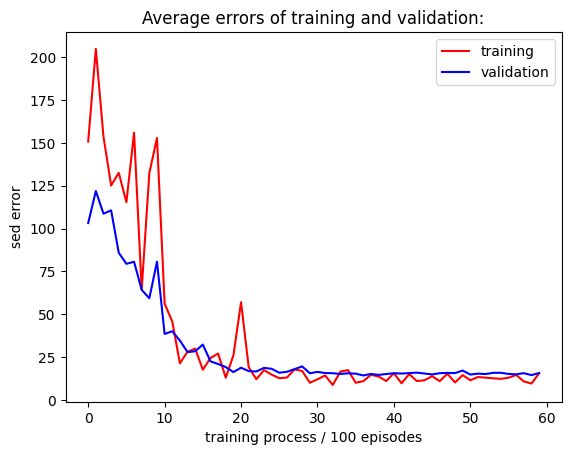

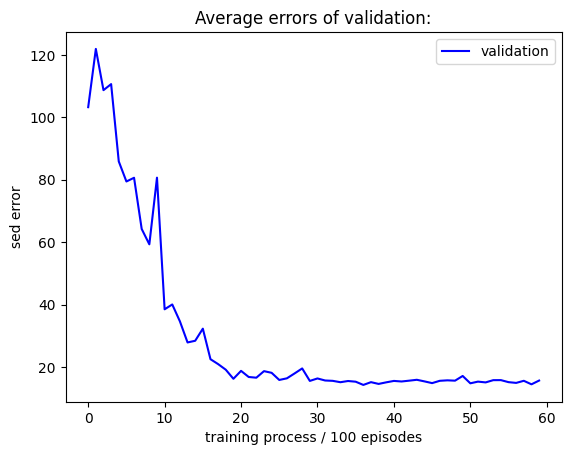

In [8]:
train(traj_amount=200, valid_amount=70, Round=30, show_time=100, ratio=0.3, a_size=3, s_size=3, skip_size=2, label='sed')

======loading train data======
It cost 11.490972518920898s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.58it/s]


round 0 episode 100: Training error: 117.69980601211486, Validation error: 48.55371243678844
Save model with error 48.55371243678844
==>current best model is 48.55371243678844 with ratio 0.4
It costs 122.35361242294312s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.50it/s]


round 0 episode 200: Training error: 39.686549813881825, Validation error: 51.74432738460076
==>current best model is 48.55371243678844 with ratio 0.4
It costs 129.36717867851257s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.67it/s]


round 1 episode 100: Training error: 63.69675531947651, Validation error: 58.19884860854116
==>current best model is 48.55371243678844 with ratio 0.4
It costs 124.15439462661743s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


round 1 episode 200: Training error: 25.374162440106325, Validation error: 30.804352679357823
Save model with error 30.804352679357823
==>current best model is 30.804352679357823 with ratio 0.4
It costs 150.93436932563782s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


round 2 episode 100: Training error: 27.741698696902496, Validation error: 23.062267798000626
Save model with error 23.062267798000626
==>current best model is 23.062267798000626 with ratio 0.4
It costs 151.54339599609375s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.05it/s]


round 2 episode 200: Training error: 15.500077697506363, Validation error: 28.32527925129695
==>current best model is 23.062267798000626 with ratio 0.4
It costs 182.4707863330841s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.10it/s]


round 3 episode 100: Training error: 15.453380652703702, Validation error: 16.98092962497385
Save model with error 16.98092962497385
==>current best model is 16.98092962497385 with ratio 0.4
It costs 170.69625282287598s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


round 3 episode 200: Training error: 13.834269989643756, Validation error: 14.50237510906823
Save model with error 14.50237510906823
==>current best model is 14.50237510906823 with ratio 0.4
It costs 178.84213042259216s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


round 4 episode 100: Training error: 11.349688626513707, Validation error: 11.793184856186034
Save model with error 11.793184856186034
==>current best model is 11.793184856186034 with ratio 0.4
It costs 181.36859726905823s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


round 4 episode 200: Training error: 9.880010962086754, Validation error: 13.978387843519373
==>current best model is 11.793184856186034 with ratio 0.4
It costs 170.4778275489807s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


round 5 episode 100: Training error: 9.161618661675812, Validation error: 11.548939225961485
Save model with error 11.548939225961485
==>current best model is 11.548939225961485 with ratio 0.4
It costs 169.0666699409485s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


round 5 episode 200: Training error: 8.143261596087642, Validation error: 10.656840874004306
Save model with error 10.656840874004306
==>current best model is 10.656840874004306 with ratio 0.4
It costs 181.8955397605896s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


round 6 episode 100: Training error: 8.704261263929657, Validation error: 14.586666287906382
==>current best model is 10.656840874004306 with ratio 0.4
It costs 168.6387128829956s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it]


round 6 episode 200: Training error: 7.737973543547414, Validation error: 9.471201732268021
Save model with error 9.471201732268021
==>current best model is 9.471201732268021 with ratio 0.4
It costs 188.7068693637848s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.00s/it]


round 7 episode 100: Training error: 8.25039147872781, Validation error: 10.722669854781563
==>current best model is 9.471201732268021 with ratio 0.4
It costs 179.52055597305298s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


round 7 episode 200: Training error: 6.773588235091147, Validation error: 9.685624059804516
==>current best model is 9.471201732268021 with ratio 0.4
It costs 158.40555548667908s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


round 8 episode 100: Training error: 5.708288870026322, Validation error: 9.876288815872217
==>current best model is 9.471201732268021 with ratio 0.4
It costs 167.69423627853394s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.27it/s]


round 8 episode 200: Training error: 8.873121034845157, Validation error: 9.224388029599314
Save model with error 9.224388029599314
==>current best model is 9.224388029599314 with ratio 0.4
It costs 157.5368058681488s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.00it/s]


round 9 episode 100: Training error: 9.757588436676098, Validation error: 9.425060216763285
==>current best model is 9.224388029599314 with ratio 0.4
It costs 177.03873133659363s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.49it/s]


round 9 episode 200: Training error: 5.872714206526811, Validation error: 8.83089588921232
Save model with error 8.83089588921232
==>current best model is 8.83089588921232 with ratio 0.4
It costs 144.55800223350525s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


round 10 episode 100: Training error: 5.859024150504105, Validation error: 8.90875312598118
==>current best model is 8.83089588921232 with ratio 0.4
It costs 155.64885354042053s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


round 10 episode 200: Training error: 7.8457049633547635, Validation error: 9.202199709604992
==>current best model is 8.83089588921232 with ratio 0.4
It costs 163.6299798488617s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


round 11 episode 100: Training error: 5.759878462101059, Validation error: 8.953462493143425
==>current best model is 8.83089588921232 with ratio 0.4
It costs 160.99122166633606s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s]


round 11 episode 200: Training error: 8.167428040434256, Validation error: 8.378675478189008
Save model with error 8.378675478189008
==>current best model is 8.378675478189008 with ratio 0.4
It costs 160.09249091148376s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


round 12 episode 100: Training error: 7.673732869314149, Validation error: 8.598258769478742
==>current best model is 8.378675478189008 with ratio 0.4
It costs 153.8079798221588s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


round 12 episode 200: Training error: 6.354216461278464, Validation error: 8.943264330845063
==>current best model is 8.378675478189008 with ratio 0.4
It costs 175.73485946655273s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


round 13 episode 100: Training error: 6.753194697525134, Validation error: 8.673342689484219
==>current best model is 8.378675478189008 with ratio 0.4
It costs 160.57920169830322s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


round 13 episode 200: Training error: 6.596896572675402, Validation error: 8.78995606198
==>current best model is 8.378675478189008 with ratio 0.4
It costs 171.5975878238678s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


round 14 episode 100: Training error: 6.890010993664797, Validation error: 8.450843998129331
==>current best model is 8.378675478189008 with ratio 0.4
It costs 167.00500202178955s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


round 14 episode 200: Training error: 6.346228229664104, Validation error: 8.643973673432594
==>current best model is 8.378675478189008 with ratio 0.4
It costs 172.1759889125824s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


round 15 episode 100: Training error: 6.685138892643871, Validation error: 8.648229461173802
==>current best model is 8.378675478189008 with ratio 0.4
It costs 178.43425273895264s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.43it/s]


round 15 episode 200: Training error: 6.567248564572995, Validation error: 8.702850082620838
==>current best model is 8.378675478189008 with ratio 0.4
It costs 185.01037430763245s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:50<00:00,  1.70s/it]


round 16 episode 100: Training error: 7.2260214679554124, Validation error: 8.329748634549512
Save model with error 8.329748634549512
==>current best model is 8.329748634549512 with ratio 0.4
It costs 324.73286724090576s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.52s/it]


round 16 episode 200: Training error: 6.303364547392326, Validation error: 9.740795604185747
==>current best model is 8.329748634549512 with ratio 0.4
It costs 302.3846299648285s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.35s/it]


round 17 episode 100: Training error: 6.295761245408605, Validation error: 8.693581911857796
==>current best model is 8.329748634549512 with ratio 0.4
It costs 288.6296353340149s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:10<00:00,  1.90s/it]


round 17 episode 200: Training error: 7.112040803171737, Validation error: 8.688849243903475
==>current best model is 8.329748634549512 with ratio 0.4
It costs 342.9936418533325s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.55s/it]


round 18 episode 100: Training error: 7.972576030012591, Validation error: 8.213430747552852
Save model with error 8.213430747552852
==>current best model is 8.213430747552852 with ratio 0.4
It costs 308.33854937553406s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:48<00:00,  1.68s/it]


round 18 episode 200: Training error: 5.618583609092066, Validation error: 8.470254142387185
==>current best model is 8.213430747552852 with ratio 0.4
It costs 319.1071677207947s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


round 19 episode 100: Training error: 7.489976353032115, Validation error: 8.477346337484875
==>current best model is 8.213430747552852 with ratio 0.4
It costs 310.33079624176025s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.65s/it]


round 19 episode 200: Training error: 6.189985033448215, Validation error: 8.662165800614176
==>current best model is 8.213430747552852 with ratio 0.4
It costs 324.52310585975647s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:47<00:00,  2.27s/it]


round 20 episode 100: Training error: 6.741782893895899, Validation error: 8.58479308466459
==>current best model is 8.213430747552852 with ratio 0.4
It costs 417.3476765155792s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:05<00:00,  1.86s/it]


round 20 episode 200: Training error: 6.411436600927024, Validation error: 8.230528646917271
==>current best model is 8.213430747552852 with ratio 0.4
It costs 376.5096502304077s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:07<00:00,  1.87s/it]


round 21 episode 100: Training error: 7.892343714280888, Validation error: 8.486461633581015
==>current best model is 8.213430747552852 with ratio 0.4
It costs 377.778048992157s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:42<00:00,  2.22s/it]


round 21 episode 200: Training error: 5.485315428243707, Validation error: 8.32156606498123
==>current best model is 8.213430747552852 with ratio 0.4
It costs 411.8857090473175s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:10<00:00,  1.91s/it]


round 22 episode 100: Training error: 6.656745331494434, Validation error: 8.549413530229467
==>current best model is 8.213430747552852 with ratio 0.4
It costs 382.66661500930786s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:38<00:00,  2.18s/it]


round 22 episode 200: Training error: 6.395728398933483, Validation error: 8.399808017368661
==>current best model is 8.213430747552852 with ratio 0.4
It costs 417.3444027900696s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:39<00:00,  2.19s/it]


round 23 episode 100: Training error: 6.4167545746830195, Validation error: 8.490410923283937
==>current best model is 8.213430747552852 with ratio 0.4
It costs 417.3618052005768s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:24<00:00,  2.04s/it]


round 23 episode 200: Training error: 6.81849092253996, Validation error: 8.361995227152049
==>current best model is 8.213430747552852 with ratio 0.4
It costs 401.77874851226807s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:28<00:00,  2.09s/it]


round 24 episode 100: Training error: 7.890268797785163, Validation error: 8.454487487360801
==>current best model is 8.213430747552852 with ratio 0.4
It costs 406.95182847976685s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.11s/it]


round 24 episode 200: Training error: 5.685703407846212, Validation error: 8.517848470896
==>current best model is 8.213430747552852 with ratio 0.4
It costs 335.20326566696167s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.13s/it]


round 25 episode 100: Training error: 8.626650437143468, Validation error: 8.489597849929869
==>current best model is 8.213430747552852 with ratio 0.4
It costs 222.84333443641663s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.26s/it]


round 25 episode 200: Training error: 5.0187441122636205, Validation error: 8.472069990194418
==>current best model is 8.213430747552852 with ratio 0.4
It costs 238.8866012096405s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:01<00:00,  1.22s/it]


round 26 episode 100: Training error: 6.812608722392024, Validation error: 8.811547957044526
==>current best model is 8.213430747552852 with ratio 0.4
It costs 231.70633673667908s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:01<00:00,  1.21s/it]


round 26 episode 200: Training error: 6.94965366712606, Validation error: 8.732683991988205
==>current best model is 8.213430747552852 with ratio 0.4
It costs 233.05699563026428s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it]


round 27 episode 100: Training error: 6.878989428151323, Validation error: 8.764526281227838
==>current best model is 8.213430747552852 with ratio 0.4
It costs 215.95827507972717s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.37s/it]


round 27 episode 200: Training error: 6.618254878339754, Validation error: 8.293452726577401
==>current best model is 8.213430747552852 with ratio 0.4
It costs 246.93274879455566s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.22s/it]


round 28 episode 100: Training error: 5.590815082228534, Validation error: 8.667705313931714
==>current best model is 8.213430747552852 with ratio 0.4
It costs 233.63646912574768s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.20s/it]


round 28 episode 200: Training error: 7.5981369432414985, Validation error: 8.42325121308371
==>current best model is 8.213430747552852 with ratio 0.4
It costs 234.08148336410522s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:07<00:00,  1.27s/it]


round 29 episode 100: Training error: 8.526492394184968, Validation error: 8.400879141435626
==>current best model is 8.213430747552852 with ratio 0.4
It costs 237.51416516304016s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


round 29 episode 200: Training error: 5.044328442858196, Validation error: 8.396467440236986
==>current best model is 8.213430747552852 with ratio 0.4
It costs 230.27512121200562s
Training elapsed time = %s 14050.743842124939


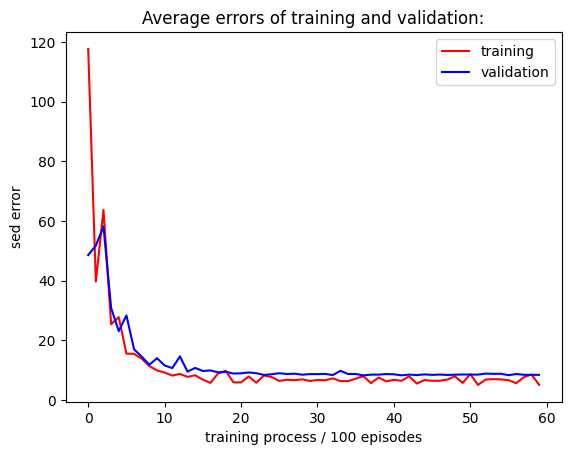

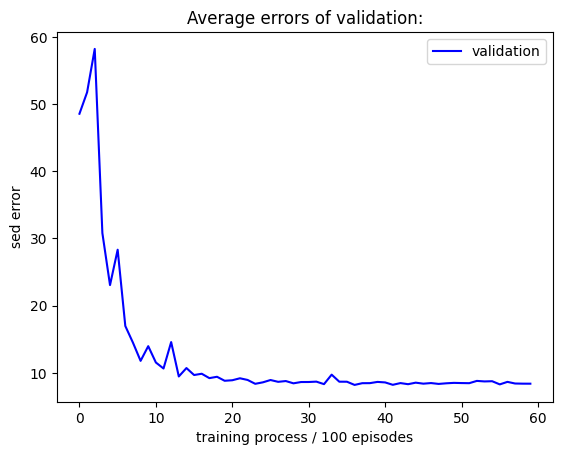

In [9]:
train(traj_amount=200, valid_amount=70, Round=30, show_time=100, ratio=0.4, a_size=3, s_size=3, skip_size=2, label='sed')

======loading train data======
It cost 13.739331007003784s.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.






[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.65it/s]


round 0 episode 100: Training error: 107.24590999900303, Validation error: 97.29392940310473

Save model with error 97.29392940310473
==>current best model is 97.29392940310473 with ratio 0.5
It costs 121.50844478607178s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.39it/s]


round 0 episode 200: Training error: 103.68034140424633, Validation error: 107.23690047849527
==>current best model is 97.29392940310473 with ratio 0.5
It costs 132.20473504066467s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s]


round 1 episode 100: Training error: 66.59986087164165, Validation error: 106.93658623930628
==>current best model is 97.29392940310473 with ratio 0.5
It costs 133.8866753578186s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]


round 1 episode 200: Training error: 103.76759949392842, Validation error: 70.47419955043681
Save model with error 70.47419955043681
==>current best model is 70.47419955043681 with ratio 0.5
It costs 162.96615433692932s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s]


round 2 episode 100: Training error: 66.67564792310978, Validation error: 52.30020164122316
Save model with error 52.30020164122316
==>current best model is 52.30020164122316 with ratio 0.5
It costs 140.09598803520203s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


round 2 episode 200: Training error: 79.04920210175847, Validation error: 46.29471688741497
Save model with error 46.29471688741497
==>current best model is 46.29471688741497 with ratio 0.5
It costs 171.13075304031372s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


round 3 episode 100: Training error: 32.38271101056764, Validation error: 47.57476540795153
==>current best model is 46.29471688741497 with ratio 0.5
It costs 153.5174458026886s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.08it/s]


round 3 episode 200: Training error: 97.80595205444921, Validation error: 34.67643597170695
Save model with error 34.67643597170695
==>current best model is 34.67643597170695 with ratio 0.5
It costs 166.3302822113037s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.35it/s]


round 4 episode 100: Training error: 42.90619249881982, Validation error: 31.68918559676941
Save model with error 31.68918559676941
==>current best model is 31.68918559676941 with ratio 0.5
It costs 151.40409874916077s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


round 4 episode 200: Training error: 90.1983818450443, Validation error: 24.734857252262955
Save model with error 24.734857252262955
==>current best model is 24.734857252262955 with ratio 0.5
It costs 176.67130637168884s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


round 5 episode 100: Training error: 35.6350534516167, Validation error: 25.43456610357618
==>current best model is 24.734857252262955 with ratio 0.5
It costs 174.30274772644043s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


round 5 episode 200: Training error: 28.37629905138879, Validation error: 18.513643009611318
Save model with error 18.513643009611318
==>current best model is 18.513643009611318 with ratio 0.5
It costs 162.3511016368866s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.25it/s]


round 6 episode 100: Training error: 17.318782534458133, Validation error: 21.039845252905767
==>current best model is 18.513643009611318 with ratio 0.5
It costs 162.31722927093506s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.03it/s]


round 6 episode 200: Training error: 14.975049967470989, Validation error: 25.809091817036457
==>current best model is 18.513643009611318 with ratio 0.5
It costs 178.92062401771545s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


round 7 episode 100: Training error: 13.039095689487397, Validation error: 13.099184733160468
Save model with error 13.099184733160468
==>current best model is 13.099184733160468 with ratio 0.5
It costs 183.58085250854492s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]


round 7 episode 200: Training error: 18.550010557822123, Validation error: 16.84636380423457
==>current best model is 13.099184733160468 with ratio 0.5
It costs 168.66509890556335s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


round 8 episode 100: Training error: 7.840357308400516, Validation error: 10.385075518630316
Save model with error 10.385075518630316
==>current best model is 10.385075518630316 with ratio 0.5
It costs 180.67252898216248s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


round 8 episode 200: Training error: 14.980541907365543, Validation error: 11.22969636777774
==>current best model is 10.385075518630316 with ratio 0.5
It costs 188.72238683700562s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


round 9 episode 100: Training error: 7.373001211892824, Validation error: 8.226789588736784
Save model with error 8.226789588736784
==>current best model is 8.226789588736784 with ratio 0.5
It costs 195.42555928230286s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


round 9 episode 200: Training error: 5.950544051491854, Validation error: 10.124878474637782
==>current best model is 8.226789588736784 with ratio 0.5
It costs 171.8611056804657s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.03s/it]


round 10 episode 100: Training error: 7.133322989364083, Validation error: 8.173120747184791
Save model with error 8.173120747184791
==>current best model is 8.173120747184791 with ratio 0.5
It costs 194.71909523010254s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


round 10 episode 200: Training error: 5.755731030446387, Validation error: 6.689745560138256
Save model with error 6.689745560138256
==>current best model is 6.689745560138256 with ratio 0.5
It costs 178.8299367427826s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.01s/it]


round 11 episode 100: Training error: 6.6614495093566966, Validation error: 7.1595507941526755
==>current best model is 6.689745560138256 with ratio 0.5
It costs 190.318922996521s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.11it/s]


round 11 episode 200: Training error: 5.322589741185242, Validation error: 7.2260090843525715
==>current best model is 6.689745560138256 with ratio 0.5
It costs 178.96697902679443s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.11it/s]


round 12 episode 100: Training error: 4.987959848457606, Validation error: 6.397224187279065
Save model with error 6.397224187279065
==>current best model is 6.397224187279065 with ratio 0.5
It costs 180.31183767318726s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


round 12 episode 200: Training error: 4.900430499050037, Validation error: 6.201836688023915
Save model with error 6.201836688023915
==>current best model is 6.201836688023915 with ratio 0.5
It costs 192.89380598068237s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:53<00:00,  1.13s/it]


round 13 episode 100: Training error: 4.414369585918508, Validation error: 6.90046092857775
==>current best model is 6.201836688023915 with ratio 0.5
It costs 202.7269163131714s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


round 13 episode 200: Training error: 6.442063198067902, Validation error: 6.120680343669005
Save model with error 6.120680343669005
==>current best model is 6.120680343669005 with ratio 0.5
It costs 169.5249752998352s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


round 14 episode 100: Training error: 4.282270524538549, Validation error: 6.304554925462232
==>current best model is 6.120680343669005 with ratio 0.5
It costs 189.2372350692749s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


round 14 episode 200: Training error: 5.566481356820525, Validation error: 5.935056190393556
Save model with error 5.935056190393556
==>current best model is 5.935056190393556 with ratio 0.5
It costs 186.1109960079193s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


round 15 episode 100: Training error: 7.4990699148448785, Validation error: 5.781480196096264
Save model with error 5.781480196096264
==>current best model is 5.781480196096264 with ratio 0.5
It costs 177.3557529449463s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.05s/it]


round 15 episode 200: Training error: 3.740891182926806, Validation error: 5.837128855226275
==>current best model is 5.781480196096264 with ratio 0.5
It costs 193.38017010688782s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


round 16 episode 100: Training error: 3.8915970919533667, Validation error: 5.658857317504091
Save model with error 5.658857317504091
==>current best model is 5.658857317504091 with ratio 0.5
It costs 193.92996382713318s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


round 16 episode 200: Training error: 5.514001847763, Validation error: 5.838929599632166
==>current best model is 5.658857317504091 with ratio 0.5
It costs 180.0378167629242s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.04it/s]


round 17 episode 100: Training error: 3.488399257697848, Validation error: 5.754673100197637
==>current best model is 5.658857317504091 with ratio 0.5
It costs 185.8853142261505s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


round 17 episode 200: Training error: 5.549697655249081, Validation error: 5.928111797687946
==>current best model is 5.658857317504091 with ratio 0.5
It costs 188.5219328403473s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


round 18 episode 100: Training error: 4.06819660865181, Validation error: 5.720592829142972
==>current best model is 5.658857317504091 with ratio 0.5
It costs 173.21725487709045s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.10s/it]


round 18 episode 200: Training error: 4.776969713483803, Validation error: 5.816826407818607
==>current best model is 5.658857317504091 with ratio 0.5
It costs 200.5210223197937s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.05it/s]


round 19 episode 100: Training error: 4.442943502638625, Validation error: 5.758590978923082
==>current best model is 5.658857317504091 with ratio 0.5
It costs 185.79225945472717s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


round 19 episode 200: Training error: 4.483274033190017, Validation error: 5.6585510083936095
Save model with error 5.6585510083936095
==>current best model is 5.6585510083936095 with ratio 0.5
It costs 188.91493725776672s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


round 20 episode 100: Training error: 3.6616814884593896, Validation error: 5.7662679678983695
==>current best model is 5.6585510083936095 with ratio 0.5
It costs 180.35827541351318s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


round 20 episode 200: Training error: 5.052396891426954, Validation error: 5.818437680223073
==>current best model is 5.6585510083936095 with ratio 0.5
It costs 193.22044563293457s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


round 21 episode 100: Training error: 4.992405328117986, Validation error: 5.577801231448179
Save model with error 5.577801231448179
==>current best model is 5.577801231448179 with ratio 0.5
It costs 184.16035342216492s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.01s/it]


round 21 episode 200: Training error: 3.726712792235887, Validation error: 5.663642898041725
==>current best model is 5.577801231448179 with ratio 0.5
It costs 190.45086431503296s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.10s/it]


round 22 episode 100: Training error: 4.449475820082628, Validation error: 5.601004368283152
==>current best model is 5.577801231448179 with ratio 0.5
It costs 200.8258547782898s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


round 22 episode 200: Training error: 4.240973143085942, Validation error: 5.864312210847361
==>current best model is 5.577801231448179 with ratio 0.5
It costs 173.64452528953552s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.01s/it]


round 23 episode 100: Training error: 4.482863834724606, Validation error: 5.559059684700643
Save model with error 5.559059684700643
==>current best model is 5.559059684700643 with ratio 0.5
It costs 190.37703680992126s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


round 23 episode 200: Training error: 4.122197899103004, Validation error: 5.724010563350651
==>current best model is 5.559059684700643 with ratio 0.5
It costs 184.47285318374634s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.02it/s]


round 24 episode 100: Training error: 4.819885880607492, Validation error: 5.761177834935212
==>current best model is 5.559059684700643 with ratio 0.5
It costs 187.93169045448303s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


round 24 episode 200: Training error: 3.85697831151374, Validation error: 5.619021013213725
==>current best model is 5.559059684700643 with ratio 0.5
It costs 185.88902497291565s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.00it/s]


round 25 episode 100: Training error: 4.7016658271789336, Validation error: 5.6421376844441955
==>current best model is 5.559059684700643 with ratio 0.5
It costs 190.7428891658783s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


round 25 episode 200: Training error: 3.9519051658120254, Validation error: 5.7466680008120665
==>current best model is 5.559059684700643 with ratio 0.5
It costs 185.41329503059387s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.15s/it]


round 26 episode 100: Training error: 4.368698385954833, Validation error: 5.611493884114162
==>current best model is 5.559059684700643 with ratio 0.5
It costs 203.99784660339355s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.33it/s]


round 26 episode 200: Training error: 4.4045846067255345, Validation error: 5.626680570482264
==>current best model is 5.559059684700643 with ratio 0.5
It costs 164.86608219146729s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


round 27 episode 100: Training error: 3.4866822971830396, Validation error: 5.6194722973699545
==>current best model is 5.559059684700643 with ratio 0.5
It costs 191.1556417942047s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


round 27 episode 200: Training error: 5.140399325808718, Validation error: 5.548793856114375
Save model with error 5.548793856114375
==>current best model is 5.548793856114375 with ratio 0.5
It costs 173.63337683677673s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.06s/it]


round 28 episode 100: Training error: 4.387234575559888, Validation error: 5.633691243237025
==>current best model is 5.548793856114375 with ratio 0.5
It costs 194.6467924118042s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]


round 28 episode 200: Training error: 4.244181099280545, Validation error: 6.209964073407755
==>current best model is 5.548793856114375 with ratio 0.5
It costs 172.45599603652954s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


round 29 episode 100: Training error: 3.7177223357226814, Validation error: 5.667140255970955
==>current best model is 5.548793856114375 with ratio 0.5
It costs 182.40737581253052s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]


round 29 episode 200: Training error: 5.076679711802177, Validation error: 5.631100320635302
==>current best model is 5.548793856114375 with ratio 0.5
It costs 189.1418435573578s
Training elapsed time = %s 10727.535135507584


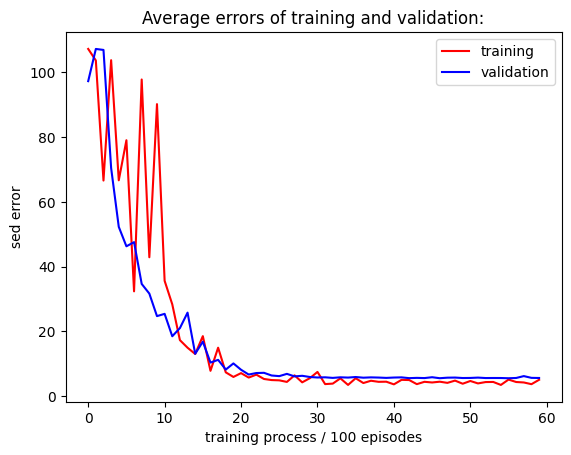

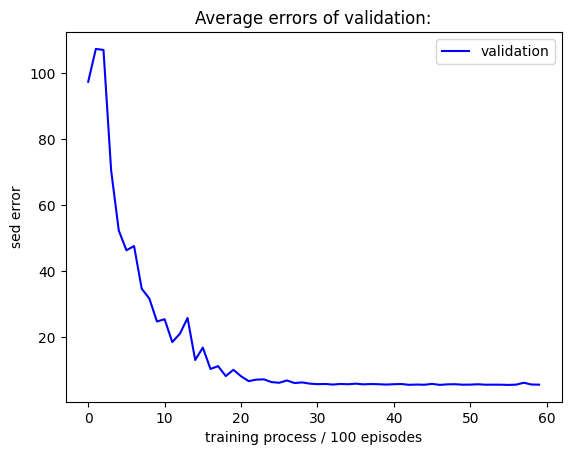

In [4]:
train(traj_amount=200, valid_amount=70, Round=30, show_time=100, ratio=0.5, a_size=3, s_size=3, skip_size=2, label='sed')

======loading train data======
It cost 6.996614217758179s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


round 0 episode 100: Training error: 127.97550438415401, Validation error: 172.09421841070176
Save model with error 172.09421841070176
==>current best model is 172.09421841070176 with ratio 0.1
It costs 233.38329982757568s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.35s/it]


round 0 episode 200: Training error: 388.66438308264236, Validation error: 166.28745447566249
Save model with error 166.28745447566249
==>current best model is 166.28745447566249 with ratio 0.1
It costs 233.40996503829956s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


round 1 episode 100: Training error: 109.30029314467016, Validation error: 188.07975170254764
==>current best model is 166.28745447566249 with ratio 0.1
It costs 222.89505624771118s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


round 1 episode 200: Training error: 197.58383749960797, Validation error: 213.08598315984415
==>current best model is 166.28745447566249 with ratio 0.1
It costs 191.08962607383728s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.19s/it]


round 2 episode 100: Training error: 125.9997986200646, Validation error: 152.83007490595733
Save model with error 152.83007490595733
==>current best model is 152.83007490595733 with ratio 0.1
It costs 228.77696824073792s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.20s/it]


round 2 episode 200: Training error: 185.50133768724808, Validation error: 159.40829501862254
==>current best model is 152.83007490595733 with ratio 0.1
It costs 228.76918268203735s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.47s/it]


round 3 episode 100: Training error: 159.55100943775966, Validation error: 169.8578477873527
==>current best model is 152.83007490595733 with ratio 0.1
It costs 254.98755550384521s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


round 3 episode 200: Training error: 233.68677558422718, Validation error: 146.5456015052613
Save model with error 146.5456015052613
==>current best model is 146.5456015052613 with ratio 0.1
It costs 208.53517985343933s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:20<00:00,  1.41s/it]


round 4 episode 100: Training error: 239.74741855550582, Validation error: 139.18044675253114
Save model with error 139.18044675253114
==>current best model is 139.18044675253114 with ratio 0.1
It costs 255.33625960350037s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.15s/it]


round 4 episode 200: Training error: 133.41688695593774, Validation error: 157.8736829061581
==>current best model is 139.18044675253114 with ratio 0.1
It costs 225.79434466362s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.37s/it]


round 5 episode 100: Training error: 134.62337944884973, Validation error: 138.9161001541538
Save model with error 138.9161001541538
==>current best model is 138.9161001541538 with ratio 0.1
It costs 251.17439198493958s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.20s/it]


round 5 episode 200: Training error: 135.24241738437485, Validation error: 141.90437927341236
==>current best model is 138.9161001541538 with ratio 0.1
It costs 240.6498098373413s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


round 6 episode 100: Training error: 123.34581631507548, Validation error: 146.8126071732241
==>current best model is 138.9161001541538 with ratio 0.1
It costs 243.64389967918396s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.26s/it]


round 6 episode 200: Training error: 186.14711039547882, Validation error: 162.89609018033005
==>current best model is 138.9161001541538 with ratio 0.1
It costs 238.72656345367432s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.43s/it]


round 7 episode 100: Training error: 130.7328458668387, Validation error: 123.68240742343288
Save model with error 123.68240742343288
==>current best model is 123.68240742343288 with ratio 0.1
It costs 259.4428346157074s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]


round 7 episode 200: Training error: 123.24234893071713, Validation error: 128.35885989434072
==>current best model is 123.68240742343288 with ratio 0.1
It costs 241.99879050254822s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.23s/it]


round 8 episode 100: Training error: 184.94485232634247, Validation error: 139.74330662943623
==>current best model is 123.68240742343288 with ratio 0.1
It costs 261.118732213974s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:02<00:00,  1.83s/it]


round 8 episode 200: Training error: 88.12902203991385, Validation error: 152.99173844904638
==>current best model is 123.68240742343288 with ratio 0.1
It costs 318.4934732913971s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.62s/it]


round 9 episode 100: Training error: 143.33855551108877, Validation error: 121.401828508935
Save model with error 121.401828508935
==>current best model is 121.401828508935 with ratio 0.1
It costs 304.18208503723145s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


round 9 episode 200: Training error: 79.83923609988571, Validation error: 121.78047402977813
==>current best model is 121.401828508935 with ratio 0.1
It costs 299.2996859550476s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:53<00:00,  1.73s/it]


round 10 episode 100: Training error: 88.98255189990185, Validation error: 128.77680906288361
==>current best model is 121.401828508935 with ratio 0.1
It costs 314.1881010532379s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.48s/it]


round 10 episode 200: Training error: 120.51651429057178, Validation error: 126.23382903336959
==>current best model is 121.401828508935 with ratio 0.1
It costs 290.80159282684326s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.66s/it]


round 11 episode 100: Training error: 91.19552753787565, Validation error: 123.66991523727793
==>current best model is 121.401828508935 with ratio 0.1
It costs 308.8867027759552s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


round 11 episode 200: Training error: 222.06180859944823, Validation error: 112.03012331208599
Save model with error 112.03012331208599
==>current best model is 112.03012331208599 with ratio 0.1
It costs 299.0156855583191s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:18<00:00,  1.99s/it]


round 12 episode 100: Training error: 84.29728824023918, Validation error: 122.72453641589841
==>current best model is 112.03012331208599 with ratio 0.1
It costs 343.35193061828613s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.24s/it]


round 12 episode 200: Training error: 129.42483925733728, Validation error: 110.22555881108707
Save model with error 110.22555881108707
==>current best model is 110.22555881108707 with ratio 0.1
It costs 270.89653062820435s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]


round 13 episode 100: Training error: 107.65339654065221, Validation error: 114.17456861201714
==>current best model is 110.22555881108707 with ratio 0.1
It costs 309.7966637611389s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:50<00:00,  1.70s/it]


round 13 episode 200: Training error: 87.00907008364894, Validation error: 115.75750492790128
==>current best model is 110.22555881108707 with ratio 0.1
It costs 319.02658438682556s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.58s/it]


round 14 episode 100: Training error: 97.424838948777, Validation error: 104.11421948477201
Save model with error 104.11421948477201
==>current best model is 104.11421948477201 with ratio 0.1
It costs 308.6479768753052s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:57<00:00,  1.78s/it]


round 14 episode 200: Training error: 82.64319032576186, Validation error: 101.65897278996349
Save model with error 101.65897278996349
==>current best model is 101.65897278996349 with ratio 0.1
It costs 328.008540391922s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:50<00:00,  1.70s/it]


round 15 episode 100: Training error: 86.9048935225862, Validation error: 107.82888578166752
==>current best model is 101.65897278996349 with ratio 0.1
It costs 320.7417652606964s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.68s/it]


round 15 episode 200: Training error: 110.84537482154283, Validation error: 104.79827252486609
==>current best model is 101.65897278996349 with ratio 0.1
It costs 318.7510063648224s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.62s/it]


round 16 episode 100: Training error: 88.04256718944347, Validation error: 108.90643418846169
==>current best model is 101.65897278996349 with ratio 0.1
It costs 311.7199332714081s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:54<00:00,  1.75s/it]


round 16 episode 200: Training error: 100.1781120050471, Validation error: 114.27155401388514
==>current best model is 101.65897278996349 with ratio 0.1
It costs 324.8785526752472s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.43s/it]


round 17 episode 100: Training error: 94.72122158021702, Validation error: 109.85655625175885
==>current best model is 101.65897278996349 with ratio 0.1
It costs 293.43892765045166s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:14<00:00,  1.95s/it]


round 17 episode 200: Training error: 88.62388754753636, Validation error: 114.36220918272875
==>current best model is 101.65897278996349 with ratio 0.1
It costs 346.77050399780273s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:19<00:00,  1.99s/it]


round 18 episode 100: Training error: 106.10411194096366, Validation error: 96.36376516078319
Save model with error 96.36376516078319
==>current best model is 96.36376516078319 with ratio 0.1
It costs 351.19406938552856s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.40s/it]


round 18 episode 200: Training error: 68.57391860314901, Validation error: 103.95484561462524
==>current best model is 96.36376516078319 with ratio 0.1
It costs 292.3258926868439s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.57s/it]


round 19 episode 100: Training error: 100.20901806722777, Validation error: 99.18769654287199
==>current best model is 96.36376516078319 with ratio 0.1
It costs 308.52667593955994s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:05<00:00,  1.85s/it]


round 19 episode 200: Training error: 71.90164264149838, Validation error: 104.80289860061066
==>current best model is 96.36376516078319 with ratio 0.1
It costs 335.4586901664734s
Training elapsed time = %s 11238.138153553009


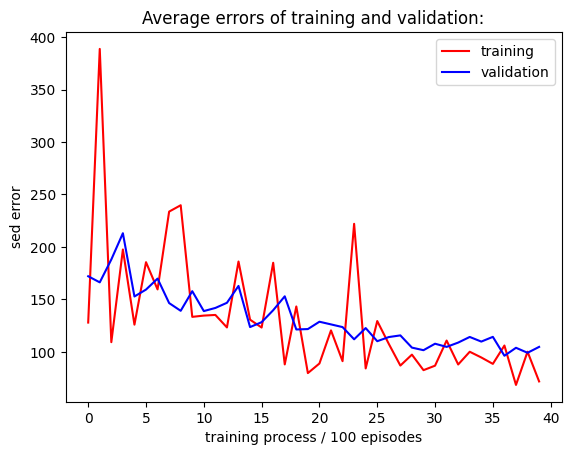

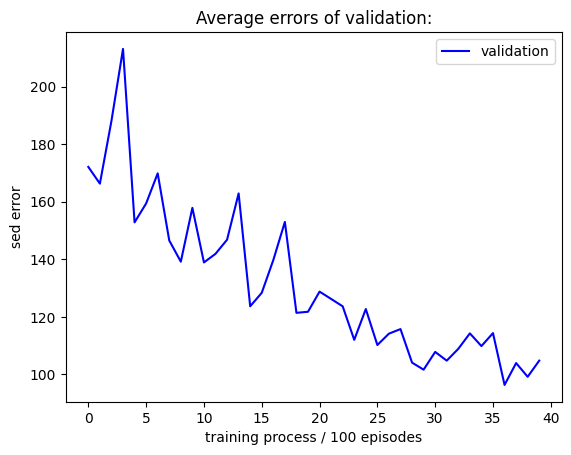

In [6]:
train(traj_amount=200, valid_amount=70, Round=20, show_time=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='sed')

======loading train data======
It cost 6.601442337036133s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


round 0 episode 100: Training error: 74.3865392424088, Validation error: 93.97947416546684
Save model with error 93.97947416546684
==>current best model is 93.97947416546684 with ratio 0.1
It costs 171.20315980911255s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


round 0 episode 200: Training error: 100.17001535398282, Validation error: 86.77113641341877
Save model with error 86.77113641341877
==>current best model is 86.77113641341877 with ratio 0.1
It costs 154.09639811515808s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


round 1 episode 100: Training error: 66.95861012169253, Validation error: 101.09237979952
==>current best model is 86.77113641341877 with ratio 0.1
It costs 154.98988246917725s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


round 1 episode 200: Training error: 61.5835977988206, Validation error: 72.17603940997633
Save model with error 72.17603940997633
==>current best model is 72.17603940997633 with ratio 0.1
It costs 182.10081911087036s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


round 2 episode 100: Training error: 73.2670759506659, Validation error: 93.05058952708713
==>current best model is 72.17603940997633 with ratio 0.1
It costs 157.66530919075012s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.06s/it]


round 2 episode 200: Training error: 75.01175432210891, Validation error: 96.97983365136889
==>current best model is 72.17603940997633 with ratio 0.1
It costs 187.5578408241272s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


round 3 episode 100: Training error: 54.99244904450964, Validation error: 106.88962111826206
==>current best model is 72.17603940997633 with ratio 0.1
It costs 177.95674681663513s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]


round 3 episode 200: Training error: 74.90791068688482, Validation error: 72.47016477329004
==>current best model is 72.17603940997633 with ratio 0.1
It costs 169.84699177742004s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


round 4 episode 100: Training error: 83.01247069945623, Validation error: 69.13934187932702
Save model with error 69.13934187932702
==>current best model is 69.13934187932702 with ratio 0.1
It costs 174.17078280448914s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


round 4 episode 200: Training error: 58.94178557549556, Validation error: 92.86939507117607
==>current best model is 69.13934187932702 with ratio 0.1
It costs 185.80355882644653s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:53<00:00,  1.13s/it]


round 5 episode 100: Training error: 47.10726342347129, Validation error: 70.42192313975254
==>current best model is 69.13934187932702 with ratio 0.1
It costs 202.48491549491882s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.25it/s]


round 5 episode 200: Training error: 57.40567814332785, Validation error: 70.58398916424079
==>current best model is 69.13934187932702 with ratio 0.1
It costs 169.4614200592041s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


round 6 episode 100: Training error: 49.45050443836678, Validation error: 78.5591052516337
==>current best model is 69.13934187932702 with ratio 0.1
It costs 181.66182041168213s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


round 6 episode 200: Training error: 57.52141998470045, Validation error: 78.59505209667584
==>current best model is 69.13934187932702 with ratio 0.1
It costs 206.89521074295044s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.04it/s]


round 7 episode 100: Training error: 64.76830932240223, Validation error: 71.09855089489298
==>current best model is 69.13934187932702 with ratio 0.1
It costs 190.34184217453003s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.05s/it]


round 7 episode 200: Training error: 47.010805747993636, Validation error: 93.96655605598355
==>current best model is 69.13934187932702 with ratio 0.1
It costs 198.59275317192078s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


round 8 episode 100: Training error: 47.432525934372705, Validation error: 64.61387498702453
Save model with error 64.61387498702453
==>current best model is 64.61387498702453 with ratio 0.1
It costs 195.72075176239014s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]


round 8 episode 200: Training error: 49.75793488959076, Validation error: 69.80020128212519
==>current best model is 64.61387498702453 with ratio 0.1
It costs 195.67016458511353s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


round 9 episode 100: Training error: 62.09715455903177, Validation error: 72.71594664972467
==>current best model is 64.61387498702453 with ratio 0.1
It costs 211.01586079597473s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


round 9 episode 200: Training error: 50.37329810054232, Validation error: 55.93664492322247
Save model with error 55.93664492322247
==>current best model is 55.93664492322247 with ratio 0.1
It costs 222.72311353683472s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:53<00:00,  1.14s/it]


round 10 episode 100: Training error: 50.85802883153461, Validation error: 58.00648392249539
==>current best model is 55.93664492322247 with ratio 0.1
It costs 228.68941712379456s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.34s/it]


round 10 episode 200: Training error: 42.79268195654243, Validation error: 49.373507371558475
Save model with error 49.373507371558475
==>current best model is 49.373507371558475 with ratio 0.1
It costs 253.0238220691681s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.36s/it]


round 11 episode 100: Training error: 43.27424399885662, Validation error: 54.84313511194923
==>current best model is 49.373507371558475 with ratio 0.1
It costs 256.97448229789734s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.26s/it]


round 11 episode 200: Training error: 31.369758182285707, Validation error: 61.62343871325251
==>current best model is 49.373507371558475 with ratio 0.1
It costs 250.58352613449097s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.37s/it]


round 12 episode 100: Training error: 42.738226061441885, Validation error: 58.12535435167844
==>current best model is 49.373507371558475 with ratio 0.1
It costs 261.86005091667175s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.33s/it]


round 12 episode 200: Training error: 26.752141795371614, Validation error: 60.16252827848961
==>current best model is 49.373507371558475 with ratio 0.1
It costs 260.8936834335327s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


round 13 episode 100: Training error: 32.42717295349456, Validation error: 48.70703119124225
Save model with error 48.70703119124225
==>current best model is 48.70703119124225 with ratio 0.1
It costs 257.58085322380066s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.49s/it]


round 13 episode 200: Training error: 32.3769591902221, Validation error: 55.97404583572505
==>current best model is 48.70703119124225 with ratio 0.1
It costs 282.21705961227417s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.25s/it]


round 14 episode 100: Training error: 42.03016482448438, Validation error: 50.08532165315032
==>current best model is 48.70703119124225 with ratio 0.1
It costs 254.5639259815216s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.58s/it]


round 14 episode 200: Training error: 25.378809477625314, Validation error: 54.047892958148516
==>current best model is 48.70703119124225 with ratio 0.1
It costs 289.22270226478577s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.29s/it]


round 15 episode 100: Training error: 23.63552673419336, Validation error: 45.29003155858036
Save model with error 45.29003155858036
==>current best model is 45.29003155858036 with ratio 0.1
It costs 258.0349934101105s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]


round 15 episode 200: Training error: 50.1569977834792, Validation error: 57.51206161087371
==>current best model is 45.29003155858036 with ratio 0.1
It costs 283.7254192829132s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.42s/it]


round 16 episode 100: Training error: 33.23221122789757, Validation error: 53.9664996514576
==>current best model is 45.29003155858036 with ratio 0.1
It costs 270.8511235713959s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]


round 16 episode 200: Training error: 44.777547324001496, Validation error: 53.46939361831994
==>current best model is 45.29003155858036 with ratio 0.1
It costs 269.0690176486969s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.27s/it]


round 17 episode 100: Training error: 27.03386651509735, Validation error: 57.45978948738238
==>current best model is 45.29003155858036 with ratio 0.1
It costs 260.70233631134033s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


round 17 episode 200: Training error: 43.26662289564816, Validation error: 52.153807245635605
==>current best model is 45.29003155858036 with ratio 0.1
It costs 292.2403292655945s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]


round 18 episode 100: Training error: 26.889666819352993, Validation error: 61.08540328296159
==>current best model is 45.29003155858036 with ratio 0.1
It costs 254.47484970092773s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:57<00:00,  1.78s/it]


round 18 episode 200: Training error: 35.67162560747089, Validation error: 42.764305274010006
Save model with error 42.764305274010006
==>current best model is 42.764305274010006 with ratio 0.1
It costs 314.1609034538269s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:05<00:00,  1.85s/it]


round 19 episode 100: Training error: 30.34295701857788, Validation error: 50.497002846159546
==>current best model is 42.764305274010006 with ratio 0.1
It costs 320.43938755989075s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.08s/it]


round 19 episode 200: Training error: 33.43621079622298, Validation error: 46.00446506324846
==>current best model is 42.764305274010006 with ratio 0.1
It costs 243.8771629333496s
Training elapsed time = %s 9053.15275812149


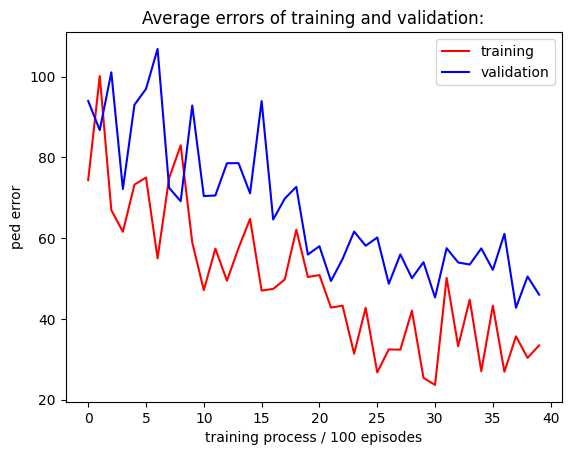

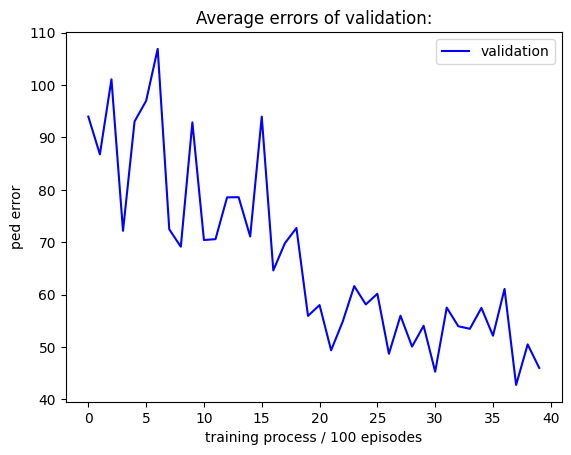

In [7]:
train(traj_amount=200, valid_amount=70, Round=20, show_time=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='ped')

======loading train data======
It cost 6.308093547821045s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.03s/it]


round 0 episode 100: Training error: 2.7029434768594074, Validation error: 2.76524617593281
Save model with error 2.76524617593281
==>current best model is 2.76524617593281 with ratio 0.1
It costs 196.17255568504333s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]


round 0 episode 200: Training error: 2.770377118570961, Validation error: 2.685576464679806
Save model with error 2.685576464679806
==>current best model is 2.685576464679806 with ratio 0.1
It costs 191.34658670425415s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


round 1 episode 100: Training error: 2.711793544204501, Validation error: 2.68228277347657
Save model with error 2.68228277347657
==>current best model is 2.68228277347657 with ratio 0.1
It costs 188.073899269104s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


round 1 episode 200: Training error: 2.7055493740911616, Validation error: 2.667279723693769
Save model with error 2.667279723693769
==>current best model is 2.667279723693769 with ratio 0.1
It costs 218.9661078453064s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.24s/it]


round 2 episode 100: Training error: 2.742860235153344, Validation error: 2.6766030336086306
==>current best model is 2.667279723693769 with ratio 0.1
It costs 229.41109371185303s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/it]


round 2 episode 200: Training error: 2.6107578817155486, Validation error: 2.7225217139920947
==>current best model is 2.667279723693769 with ratio 0.1
It costs 209.97261762619019s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


round 3 episode 100: Training error: 2.6342321988098956, Validation error: 2.615410570682428
Save model with error 2.615410570682428
==>current best model is 2.615410570682428 with ratio 0.1
It costs 211.87186336517334s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.34s/it]


round 3 episode 200: Training error: 2.7566232871119043, Validation error: 2.597972385149099
Save model with error 2.597972385149099
==>current best model is 2.597972385149099 with ratio 0.1
It costs 247.77463793754578s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.22s/it]


round 4 episode 100: Training error: 2.5765561953417886, Validation error: 2.552565694594402
Save model with error 2.552565694594402
==>current best model is 2.552565694594402 with ratio 0.1
It costs 234.61338663101196s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.25s/it]


round 4 episode 200: Training error: 2.5907483637035242, Validation error: 2.5980828950260717
==>current best model is 2.552565694594402 with ratio 0.1
It costs 240.9313690662384s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.21s/it]


round 5 episode 100: Training error: 2.6281260307771466, Validation error: 2.6345931489053473
==>current best model is 2.552565694594402 with ratio 0.1
It costs 238.7275824546814s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.36s/it]


round 5 episode 200: Training error: 2.608233286671147, Validation error: 2.529873077931307
Save model with error 2.529873077931307
==>current best model is 2.529873077931307 with ratio 0.1
It costs 256.52640295028687s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.49s/it]


round 6 episode 100: Training error: 2.597370615435303, Validation error: 2.541714606771079
==>current best model is 2.529873077931307 with ratio 0.1
It costs 271.81338334083557s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


round 6 episode 200: Training error: 2.4800544925779078, Validation error: 2.3875617487194107
Save model with error 2.3875617487194107
==>current best model is 2.3875617487194107 with ratio 0.1
It costs 241.62976574897766s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


round 7 episode 100: Training error: 2.3570391808128806, Validation error: 2.431350646220014
==>current best model is 2.3875617487194107 with ratio 0.1
It costs 264.6986610889435s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:20<00:00,  1.41s/it]


round 7 episode 200: Training error: 2.5298238885757107, Validation error: 2.336709160896552
Save model with error 2.336709160896552
==>current best model is 2.336709160896552 with ratio 0.1
It costs 282.1616005897522s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:01<00:00,  1.81s/it]


round 8 episode 100: Training error: 2.5184061966077107, Validation error: 2.326177624764749
Save model with error 2.326177624764749
==>current best model is 2.326177624764749 with ratio 0.1
It costs 330.7463924884796s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.35s/it]


round 8 episode 200: Training error: 2.2986340116678448, Validation error: 2.25488176392487
Save model with error 2.25488176392487
==>current best model is 2.25488176392487 with ratio 0.1
It costs 284.60771346092224s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.62s/it]


round 9 episode 100: Training error: 2.32404531474107, Validation error: 2.138469807327661
Save model with error 2.138469807327661
==>current best model is 2.138469807327661 with ratio 0.1
It costs 301.3479993343353s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


round 9 episode 200: Training error: 2.2026139383861785, Validation error: 2.211950280112658
==>current best model is 2.138469807327661 with ratio 0.1
It costs 207.7843554019928s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


round 10 episode 100: Training error: 2.1628940776447925, Validation error: 2.0706563923302888
Save model with error 2.0706563923302888
==>current best model is 2.0706563923302888 with ratio 0.1
It costs 190.36179757118225s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


round 10 episode 200: Training error: 2.1456489484038914, Validation error: 2.0021279585009997
Save model with error 2.0021279585009997
==>current best model is 2.0021279585009997 with ratio 0.1
It costs 199.18605422973633s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


round 11 episode 100: Training error: 2.1069010605700176, Validation error: 1.82693959331251
Save model with error 1.82693959331251
==>current best model is 1.82693959331251 with ratio 0.1
It costs 202.325204372406s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.11it/s]


round 11 episode 200: Training error: 1.9680343253568642, Validation error: 1.7413806009902477
Save model with error 1.7413806009902477
==>current best model is 1.7413806009902477 with ratio 0.1
It costs 183.8413290977478s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]


round 12 episode 100: Training error: 1.9543649232561722, Validation error: 1.723013201489083
Save model with error 1.723013201489083
==>current best model is 1.723013201489083 with ratio 0.1
It costs 211.70550394058228s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


round 12 episode 200: Training error: 1.8729136654019916, Validation error: 1.7541885809614404
==>current best model is 1.723013201489083 with ratio 0.1
It costs 184.16864657402039s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


round 13 episode 100: Training error: 1.9134757422508673, Validation error: 1.7816968508225073
==>current best model is 1.723013201489083 with ratio 0.1
It costs 208.8576946258545s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


round 13 episode 200: Training error: 1.8384547723511206, Validation error: 1.7190271636750498
Save model with error 1.7190271636750498
==>current best model is 1.7190271636750498 with ratio 0.1
It costs 210.1539695262909s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


round 14 episode 100: Training error: 1.8698388245998419, Validation error: 1.7208866084537648
==>current best model is 1.7190271636750498 with ratio 0.1
It costs 213.68362593650818s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


round 14 episode 200: Training error: 1.863818129282044, Validation error: 1.7665884661515576
==>current best model is 1.7190271636750498 with ratio 0.1
It costs 187.0288336277008s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.19s/it]


round 15 episode 100: Training error: 1.911042433003518, Validation error: 1.693470863999548
Save model with error 1.693470863999548
==>current best model is 1.693470863999548 with ratio 0.1
It costs 215.98547625541687s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


round 15 episode 200: Training error: 1.8333040510473568, Validation error: 1.6659911188492933
Save model with error 1.6659911188492933
==>current best model is 1.6659911188492933 with ratio 0.1
It costs 183.88440918922424s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


round 16 episode 100: Training error: 1.8265753808145735, Validation error: 1.6636300052402477
Save model with error 1.6636300052402477
==>current best model is 1.6636300052402477 with ratio 0.1
It costs 207.6092221736908s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


round 16 episode 200: Training error: 1.8066019698696272, Validation error: 1.7019545196516694
==>current best model is 1.6636300052402477 with ratio 0.1
It costs 205.93577361106873s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]


round 17 episode 100: Training error: 1.768260639860908, Validation error: 1.6852761570382968
==>current best model is 1.6636300052402477 with ratio 0.1
It costs 231.27024722099304s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]


round 17 episode 200: Training error: 1.9057754405891398, Validation error: 1.6894609912607599
==>current best model is 1.6636300052402477 with ratio 0.1
It costs 226.77906370162964s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


round 18 episode 100: Training error: 1.7133342681462174, Validation error: 1.6818792628864263
==>current best model is 1.6636300052402477 with ratio 0.1
It costs 192.06359457969666s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


round 18 episode 200: Training error: 1.8637843218656085, Validation error: 1.6529187481829433
Save model with error 1.6529187481829433
==>current best model is 1.6529187481829433 with ratio 0.1
It costs 235.73974299430847s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


round 19 episode 100: Training error: 1.915542250852346, Validation error: 1.6412657328849578
Save model with error 1.6412657328849578
==>current best model is 1.6412657328849578 with ratio 0.1
It costs 197.82328844070435s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.23s/it]


round 19 episode 200: Training error: 1.7327937568603853, Validation error: 1.6362231449707547
Save model with error 1.6362231449707547
==>current best model is 1.6362231449707547 with ratio 0.1
It costs 223.09424352645874s
Training elapsed time = %s 8960.680265903473


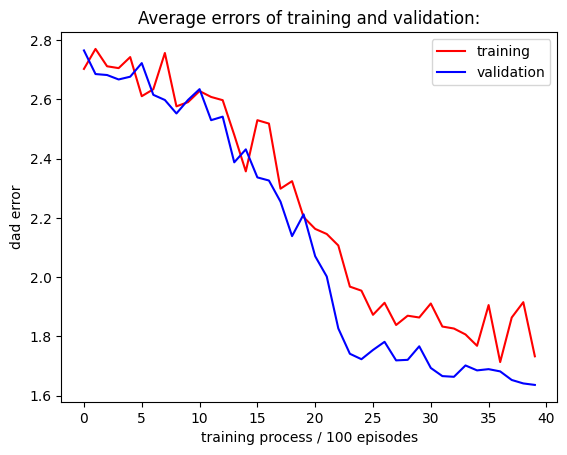

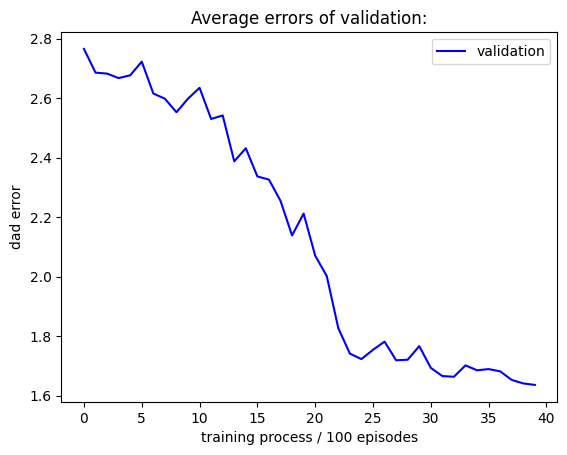

In [8]:
train(traj_amount=200, valid_amount=70, Round=20, show_time=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='dad')

======loading train data======
It cost 11.016105651855469s.


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.11s/it]


round 0 episode 100: Training error: 20.52039771450229, Validation error: 20.470191423211954
Save model with error 20.470191423211954
==>current best model is 20.470191423211954 with ratio 0.1
It costs 198.69512009620667s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it]


round 0 episode 200: Training error: 16.81578391213418, Validation error: 17.471487507736605
Save model with error 17.471487507736605
==>current best model is 17.471487507736605 with ratio 0.1
It costs 196.36208248138428s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


round 1 episode 100: Training error: 21.25644362387247, Validation error: 15.157383771845703
Save model with error 15.157383771845703
==>current best model is 15.157383771845703 with ratio 0.1
It costs 225.93936610221863s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.05s/it]


round 1 episode 200: Training error: 12.026932991129156, Validation error: 15.692367075323974
==>current best model is 15.157383771845703 with ratio 0.1
It costs 204.09569096565247s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.37s/it]


round 2 episode 100: Training error: 12.81665865173161, Validation error: 15.323484398457218
==>current best model is 15.157383771845703 with ratio 0.1
It costs 242.2405698299408s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


round 2 episode 200: Training error: 16.908173074813824, Validation error: 15.128951776834818
Save model with error 15.128951776834818
==>current best model is 15.128951776834818 with ratio 0.1
It costs 218.12871837615967s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]


round 3 episode 100: Training error: 13.97060400832148, Validation error: 14.392675894081464
Save model with error 14.392675894081464
==>current best model is 14.392675894081464 with ratio 0.1
It costs 245.04483771324158s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


round 3 episode 200: Training error: 10.225952361389785, Validation error: 14.558134985260414
==>current best model is 14.392675894081464 with ratio 0.1
It costs 251.37342357635498s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.45s/it]


round 4 episode 100: Training error: 15.077138321416458, Validation error: 12.535847849420124
Save model with error 12.535847849420124
==>current best model is 12.535847849420124 with ratio 0.1
It costs 264.75635600090027s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.33s/it]


round 4 episode 200: Training error: 9.723522924215906, Validation error: 11.555239161356772
Save model with error 11.555239161356772
==>current best model is 11.555239161356772 with ratio 0.1
It costs 238.93613624572754s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


round 5 episode 100: Training error: 9.968372783437198, Validation error: 9.620507913803621
Save model with error 9.620507913803621
==>current best model is 9.620507913803621 with ratio 0.1
It costs 259.9869863986969s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.51s/it]


round 5 episode 200: Training error: 8.617252684726806, Validation error: 10.860609393464253
==>current best model is 9.620507913803621 with ratio 0.1
It costs 285.99654507637024s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:57<00:00,  1.78s/it]


round 6 episode 100: Training error: 9.417263997945991, Validation error: 8.702215904734292
Save model with error 8.702215904734292
==>current best model is 8.702215904734292 with ratio 0.1
It costs 302.16004824638367s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.26s/it]


round 6 episode 200: Training error: 8.17776975809494, Validation error: 7.06926001112228
Save model with error 7.06926001112228
==>current best model is 7.06926001112228 with ratio 0.1
It costs 235.77701902389526s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.00it/s]


round 7 episode 100: Training error: 9.171019035716016, Validation error: 8.660898229054323
==>current best model is 7.06926001112228 with ratio 0.1
It costs 205.82516431808472s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.57s/it]


round 7 episode 200: Training error: 9.354248254681416, Validation error: 7.577650842571809
==>current best model is 7.06926001112228 with ratio 0.1
It costs 264.866916179657s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.33s/it]


round 8 episode 100: Training error: 7.393057121349144, Validation error: 7.784145257234596
==>current best model is 7.06926001112228 with ratio 0.1
It costs 241.42585396766663s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]


round 8 episode 200: Training error: 6.779021975435658, Validation error: 8.127406385104122
==>current best model is 7.06926001112228 with ratio 0.1
It costs 232.87190437316895s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:07<00:00,  1.27s/it]


round 9 episode 100: Training error: 7.187820973399637, Validation error: 6.809339849718825
Save model with error 6.809339849718825
==>current best model is 6.809339849718825 with ratio 0.1
It costs 236.06614756584167s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:52<00:00,  1.73s/it]


round 9 episode 200: Training error: 7.193569218380149, Validation error: 6.379727992317698
Save model with error 6.379727992317698
==>current best model is 6.379727992317698 with ratio 0.1
It costs 315.66016268730164s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:06<00:00,  1.86s/it]


round 10 episode 100: Training error: 6.723696629541263, Validation error: 6.629714924267422
==>current best model is 6.379727992317698 with ratio 0.1
It costs 328.7664039134979s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.51s/it]


round 10 episode 200: Training error: 7.128546600037014, Validation error: 8.016835246438548
==>current best model is 6.379727992317698 with ratio 0.1
It costs 293.81127095222473s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:55<00:00,  1.75s/it]


round 11 episode 100: Training error: 6.566428239480087, Validation error: 9.789168703466178
==>current best model is 6.379727992317698 with ratio 0.1
It costs 397.91336965560913s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [04:48<00:00,  2.89s/it]


round 11 episode 200: Training error: 7.3292616999903375, Validation error: 7.034776991190407
==>current best model is 6.379727992317698 with ratio 0.1
It costs 402.1290726661682s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.44s/it]


round 12 episode 100: Training error: 7.046844388280309, Validation error: 6.525573377353844
==>current best model is 6.379727992317698 with ratio 0.1
It costs 255.33681058883667s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:01<00:00,  1.21s/it]


round 12 episode 200: Training error: 8.840940036984811, Validation error: 6.433985869801976
==>current best model is 6.379727992317698 with ratio 0.1
It costs 232.57001495361328s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


round 13 episode 100: Training error: 6.458479481085205, Validation error: 6.448294543593942
==>current best model is 6.379727992317698 with ratio 0.1
It costs 239.98875331878662s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]


round 13 episode 200: Training error: 7.249936748253203, Validation error: 6.411454656393843
==>current best model is 6.379727992317698 with ratio 0.1
It costs 248.9319565296173s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.29s/it]


round 14 episode 100: Training error: 7.2832354643118515, Validation error: 6.478756600331877
==>current best model is 6.379727992317698 with ratio 0.1
It costs 238.38917350769043s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.39s/it]


round 14 episode 200: Training error: 7.0338762656123315, Validation error: 6.414520005197311
==>current best model is 6.379727992317698 with ratio 0.1
It costs 249.41211819648743s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.46s/it]


round 15 episode 100: Training error: 6.297327646427782, Validation error: 6.355859298204514
Save model with error 6.355859298204514
==>current best model is 6.355859298204514 with ratio 0.1
It costs 257.0159487724304s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.22s/it]


round 15 episode 200: Training error: 7.635917757210977, Validation error: 6.37778527949545
==>current best model is 6.355859298204514 with ratio 0.1
It costs 235.55902576446533s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.08s/it]


round 16 episode 100: Training error: 6.775325135056477, Validation error: 6.4111473934190535
==>current best model is 6.355859298204514 with ratio 0.1
It costs 218.6598401069641s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.61s/it]


round 16 episode 200: Training error: 7.352931392589321, Validation error: 6.374047660619556
==>current best model is 6.355859298204514 with ratio 0.1
It costs 271.62500286102295s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.40s/it]


round 17 episode 100: Training error: 7.257430290679498, Validation error: 6.759576494268018
==>current best model is 6.355859298204514 with ratio 0.1
It costs 250.8890824317932s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.30s/it]


round 17 episode 200: Training error: 6.581449596583747, Validation error: 6.421195518303614
==>current best model is 6.355859298204514 with ratio 0.1
It costs 240.83429622650146s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.58s/it]


round 18 episode 100: Training error: 6.243064823716399, Validation error: 6.41539934079575
==>current best model is 6.355859298204514 with ratio 0.1
It costs 268.6545171737671s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


round 18 episode 200: Training error: 7.3367766558315655, Validation error: 6.220953541685593
Save model with error 6.220953541685593
==>current best model is 6.220953541685593 with ratio 0.1
It costs 222.6123526096344s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.54s/it]


round 19 episode 100: Training error: 7.03426267269779, Validation error: 6.360852164393354
==>current best model is 6.220953541685593 with ratio 0.1
It costs 264.036536693573s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]


round 19 episode 200: Training error: 6.72993077476193, Validation error: 6.375519084754645
==>current best model is 6.220953541685593 with ratio 0.1
It costs 228.33428359031677s
Training elapsed time = %s 10211.681766271591


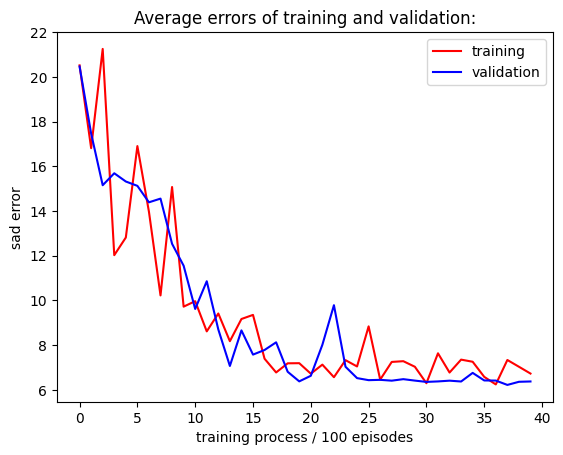

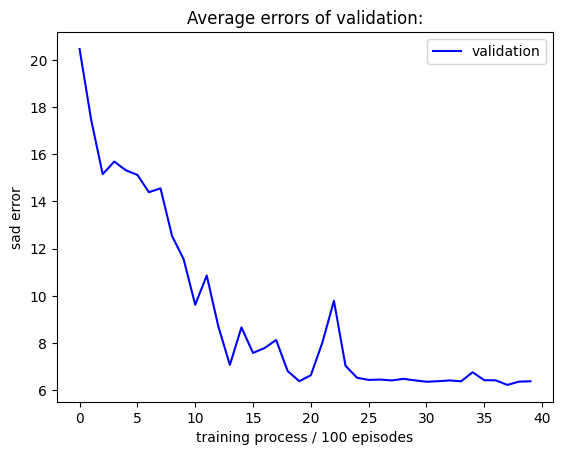

In [9]:
train(traj_amount=200, valid_amount=70, Round=20, show_time=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='sad')

In [5]:
test_all(model_path='save_skip/1.6459629475394306_ratio_0.1_dad/', amount=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='dad')

======Start testing the model at'save_skip/1.6459629475394306_ratio_0.1_dad/======'
======loading test data======
It cost 12.138863563537598s

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.





training from last checkpoint save_skip/1.6459629475394306_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save_skip/1.6459629475394306_ratio_0.1_dad/trained_model.ckpt
Effectiveness of different errors: sed:88.1978, ped:34.3507, dad:1.9531, sad:7.5744
Testing elapsed time = 19.9543s, 14.5672s, 15.0031s, 34.4870s
Effectiveness of different ratios: 0.1:1.9689, 0.2:1.1124, 0.3:0.6727, 0.4:0.5028, 0.5:0.3300
Testing elapsed time = 14.0115s, 13.2642s, 12.0427s, 10.5715s, 9.5227s
Effectiveness of different errors: sed:96.2381, ped:27.6524, dad:1.9987, sad:7.0719
Testing elapsed time = 19.9479s, 14.8184s, 16.7163s, 38.7940s
Effectiveness of different ratios: 0.1:1.9538, 0.2:1.0919, 0.3:0.6784, 0.4:0.4287, 0.5:

In [6]:
test_all(model_path='save_skip/7.6422476838531805_ratio_0.1_sad/', amount=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='sad')

======Start testing the model at'save_skip/7.6422476838531805_ratio_0.1_sad/======'
======loading test data======
It cost 3.117770195007324s
training from last checkpoint save_skip/7.6422476838531805_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save_skip/7.6422476838531805_ratio_0.1_sad/trained_model.ckpt
Effectiveness of different errors: sed:100.9711, ped:32.3153, dad:2.0746, sad:7.5982
Testing elapsed time = 19.0880s, 15.6601s, 16.4115s, 37.4291s
Effectiveness of different ratios: 0.1:7.8138, 0.2:3.9845, 0.3:2.7559, 0.4:2.2470, 0.5:2.5863
Testing elapsed time = 35.4898s, 31.9465s, 29.5636s, 27.8411s, 24.5063s
Effectiveness of different errors: sed:94.4299, ped:34.1604, dad:2.0730, sad:7.7891
Testing elapsed time = 20.3485s, 14.7564s, 14.8936s, 34.6341s
Effectiveness of different ratios: 0.1:7.7224, 0.2:4.3861, 0.3:2.7758, 0.4:2.1417, 0.5:2.1406
Testing elapsed time = 34.5761s, 34.8722s, 31.0798s, 27.6881s, 24.5825s
Effectiveness of different errors: sed:109.5350, ped:34.

In [4]:
test_ratio(model_path='save_skip/25.40605788755389_ratio_0.2_sed/', amount=100, a_size=3, s_size=3, skip_size=2, label='sed')

======Start testing the model at'save_skip/25.40605788755389_ratio_0.2_sed/======'
======loading test data======
It cost 3.16507625579834s

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.





training from last checkpoint save_skip/25.40605788755389_ratio_0.2_sed/
INFO:tensorflow:Restoring parameters from save_skip/25.40605788755389_ratio_0.2_sed/trained_model.ckpt
Effectiveness of different ratios: 0.1:70.5955, 0.2:25.7770, 0.3:16.0486, 0.4:9.0636, 0.5:11.4907
Testing elapsed time = 20.2899s, 19.4907s, 17.2497s, 14.7783s, 13.4349s
Effectiveness of different ratios: 0.1:80.6431, 0.2:26.4393, 0.3:14.4352, 0.4:9.0985, 0.5:6.7126
Testing elapsed time = 19.6681s, 18.7018s, 16.6719s, 15.5898s, 13.0039s
Effectiveness of different ratios: 0.1:75.3037, 0.2:27.6583, 0.3:14.7051, 0.4:9.1362, 0.5:6.2255
Testing elapsed time = 18.4186s, 19.6157s, 16.3254s, 13.4471s, 11.9172s


In [5]:
test_ratio(model_path='save_skip/14.233601441992281_ratio_0.3_sed/', amount=100, a_size=3, s_size=3, skip_size=2, label='sed')

======Start testing the model at'save_skip/14.233601441992281_ratio_0.3_sed/======'
======loading test data======
It cost 0.471865177154541s
training from last checkpoint save_skip/14.233601441992281_ratio_0.3_sed/
INFO:tensorflow:Restoring parameters from save_skip/14.233601441992281_ratio_0.3_sed/trained_model.ckpt
Effectiveness of different ratios: 0.1:109.1743, 0.2:27.7923, 0.3:17.9903, 0.4:9.9659, 0.5:7.6701
Testing elapsed time = 21.5357s, 19.6233s, 17.4540s, 16.1553s, 12.9370s
Effectiveness of different ratios: 0.1:113.8482, 0.2:30.4403, 0.3:17.3887, 0.4:10.0213, 0.5:7.5594
Testing elapsed time = 20.2691s, 20.1950s, 17.9255s, 16.1746s, 13.2498s
Effectiveness of different ratios: 0.1:107.3824, 0.2:29.8748, 0.3:16.0423, 0.4:9.5984, 0.5:9.0866
Testing elapsed time = 20.4365s, 19.4749s, 17.5269s, 15.9358s, 12.1704s


In [6]:
test_ratio(model_path='save_skip/8.213430747552852_ratio_0.4_sed/', amount=100, a_size=3, s_size=3, skip_size=2, label='sed')

======Start testing the model at'save_skip/8.213430747552852_ratio_0.4_sed/======'
======loading test data======
It cost 0.5285229682922363s
training from last checkpoint save_skip/8.213430747552852_ratio_0.4_sed/
INFO:tensorflow:Restoring parameters from save_skip/8.213430747552852_ratio_0.4_sed/trained_model.ckpt
Effectiveness of different ratios: 0.1:82.2708, 0.2:26.8316, 0.3:14.1850, 0.4:9.0954, 0.5:5.6710
Testing elapsed time = 18.1169s, 18.0559s, 17.6813s, 15.2926s, 14.5438s
Effectiveness of different ratios: 0.1:115.1308, 0.2:29.1160, 0.3:14.9726, 0.4:9.0726, 0.5:5.4915
Testing elapsed time = 19.4815s, 17.2132s, 17.1772s, 14.9852s, 13.4097s
Effectiveness of different ratios: 0.1:91.7197, 0.2:28.6554, 0.3:14.2550, 0.4:8.9622, 0.5:6.0358
Testing elapsed time = 20.2053s, 18.8476s, 15.6270s, 13.6861s, 11.7248s


In [7]:
test_ratio(model_path='save_skip/5.548793856114375_ratio_0.5_sed/', amount=100, a_size=3, s_size=3, skip_size=2, label='sed')

======Start testing the model at'save_skip/5.548793856114375_ratio_0.5_sed/======'
======loading test data======
It cost 0.4488651752471924s
training from last checkpoint save_skip/5.548793856114375_ratio_0.5_sed/
INFO:tensorflow:Restoring parameters from save_skip/5.548793856114375_ratio_0.5_sed/trained_model.ckpt
Effectiveness of different ratios: 0.1:107.4210, 0.2:29.4977, 0.3:15.6456, 0.4:9.3440, 0.5:5.6617
Testing elapsed time = 17.7277s, 17.0223s, 16.8168s, 15.5122s, 13.5581s
Effectiveness of different ratios: 0.1:106.5887, 0.2:29.3971, 0.3:15.6070, 0.4:9.2825, 0.5:5.5801
Testing elapsed time = 20.6605s, 17.5845s, 16.3931s, 15.0931s, 13.8616s
Effectiveness of different ratios: 0.1:109.6869, 0.2:30.0370, 0.3:15.4989, 0.4:9.1767, 0.5:5.6500
Testing elapsed time = 19.6883s, 18.4557s, 18.4971s, 14.1141s, 12.7991s


## retrain

======loading train data======
It cost 9.785012006759644s.
training from last checkpoint save_skip/96.36376516078319_ratio_0.1_sed/
INFO:tensorflow:Restoring parameters from save_skip/96.36376516078319_ratio_0.1_sed/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]


round 0 episode 100: Training error: 53.91474167439762, Validation error: 63.819241568025504
Save model with error 63.819241568025504
==>current best model is 63.819241568025504 with ratio 0.1
It costs 255.59632682800293s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.15s/it]


round 0 episode 200: Training error: 34.59589525794343, Validation error: 51.357754160795906
Save model with error 51.357754160795906
==>current best model is 51.357754160795906 with ratio 0.1
It costs 236.3902633190155s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.26s/it]


round 1 episode 100: Training error: 32.48360323691345, Validation error: 54.531224567636265
==>current best model is 51.357754160795906 with ratio 0.1
It costs 277.13300371170044s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:50<00:00,  1.71s/it]


round 1 episode 200: Training error: 32.011844690034316, Validation error: 56.590852646805544
==>current best model is 51.357754160795906 with ratio 0.1
It costs 278.2129979133606s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


round 2 episode 100: Training error: 41.08451634178979, Validation error: 53.46957253920887
==>current best model is 51.357754160795906 with ratio 0.1
It costs 209.71013379096985s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


round 2 episode 200: Training error: 20.18145306948174, Validation error: 45.921103051748034
Save model with error 45.921103051748034
==>current best model is 45.921103051748034 with ratio 0.1
It costs 238.37385511398315s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.15s/it]


round 3 episode 100: Training error: 32.631670267914856, Validation error: 56.1458139633878
==>current best model is 45.921103051748034 with ratio 0.1
It costs 223.12785029411316s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.19s/it]


round 3 episode 200: Training error: 26.7628119079739, Validation error: 52.79525975941046
==>current best model is 45.921103051748034 with ratio 0.1
It costs 226.50033521652222s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.15s/it]


round 4 episode 100: Training error: 28.14846453413702, Validation error: 54.68541806627854
==>current best model is 45.921103051748034 with ratio 0.1
It costs 223.36775827407837s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.19s/it]


round 4 episode 200: Training error: 31.58851924033664, Validation error: 58.806623265212146
==>current best model is 45.921103051748034 with ratio 0.1
It costs 227.49867796897888s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.10s/it]


round 5 episode 100: Training error: 27.58481629497119, Validation error: 54.853008560750055
==>current best model is 45.921103051748034 with ratio 0.1
It costs 219.35772681236267s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.24s/it]


round 5 episode 200: Training error: 42.242409006792144, Validation error: 55.279729260810555
==>current best model is 45.921103051748034 with ratio 0.1
It costs 232.03884053230286s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it]


round 6 episode 100: Training error: 40.76047928293189, Validation error: 48.43901096538162
==>current best model is 45.921103051748034 with ratio 0.1
It costs 213.86662936210632s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.29s/it]


round 6 episode 200: Training error: 22.48689221680092, Validation error: 48.63644690960978
==>current best model is 45.921103051748034 with ratio 0.1
It costs 237.65562415122986s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


round 7 episode 100: Training error: 31.524652979469284, Validation error: 44.19909936991496
Save model with error 44.19909936991496
==>current best model is 44.19909936991496 with ratio 0.1
It costs 225.95492386817932s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


round 7 episode 200: Training error: 27.22267877455631, Validation error: 52.19162425507743
==>current best model is 44.19909936991496 with ratio 0.1
It costs 226.1467297077179s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.11s/it]


round 8 episode 100: Training error: 30.753477506533287, Validation error: 44.500085663689575
==>current best model is 44.19909936991496 with ratio 0.1
It costs 218.83449149131775s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.26s/it]


round 8 episode 200: Training error: 32.54536289528161, Validation error: 54.05983863879181
==>current best model is 44.19909936991496 with ratio 0.1
It costs 236.06764245033264s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:07<00:00,  1.28s/it]


round 9 episode 100: Training error: 24.203041850704928, Validation error: 53.95823583888834
==>current best model is 44.19909936991496 with ratio 0.1
It costs 238.15062737464905s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.08s/it]


round 9 episode 200: Training error: 58.85450265843877, Validation error: 61.60862382069948
==>current best model is 44.19909936991496 with ratio 0.1
It costs 217.7502841949463s
Training elapsed time = %s 4661.73778963089


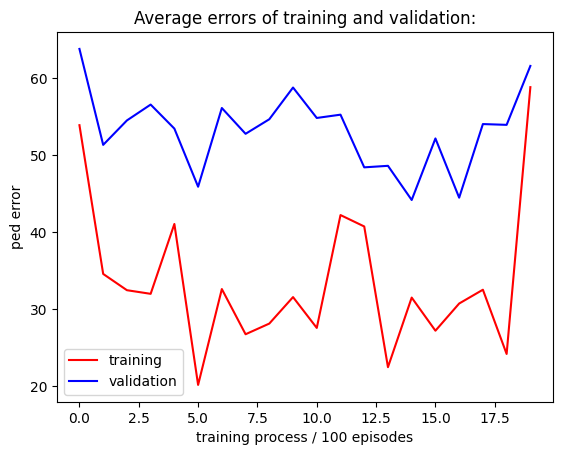

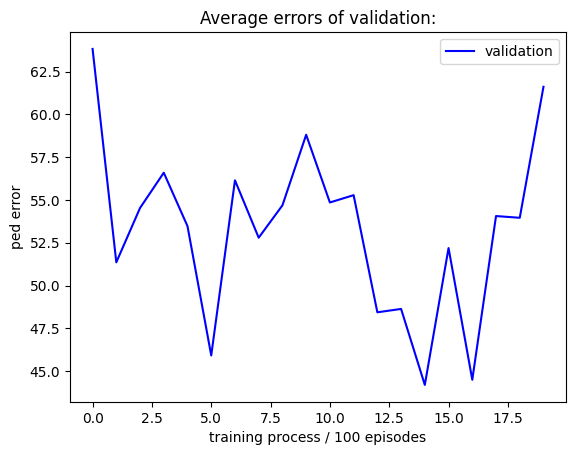

In [8]:
retrain(model_path='save_skip/96.36376516078319_ratio_0.1_sed/', traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='ped')

======loading train data======
It cost 5.934039831161499s.
training from last checkpoint save_skip/96.36376516078319_ratio_0.1_sed/
INFO:tensorflow:Restoring parameters from save_skip/96.36376516078319_ratio_0.1_sed/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.24s/it]


round 0 episode 100: Training error: 2.3640841339674745, Validation error: 2.2134468945766446
Save model with error 2.2134468945766446
==>current best model is 2.2134468945766446 with ratio 0.1
It costs 228.99768447875977s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.01s/it]


round 0 episode 200: Training error: 2.189388822555853, Validation error: 2.0788182656680747
Save model with error 2.0788182656680747
==>current best model is 2.0788182656680747 with ratio 0.1
It costs 205.88951921463013s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.15s/it]


round 1 episode 100: Training error: 2.2414458976357383, Validation error: 2.089288264835894
==>current best model is 2.0788182656680747 with ratio 0.1
It costs 221.1557354927063s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:53<00:00,  1.13s/it]


round 1 episode 200: Training error: 2.128382586632048, Validation error: 2.1405772153572866
==>current best model is 2.0788182656680747 with ratio 0.1
It costs 220.23738646507263s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.20s/it]


round 2 episode 100: Training error: 2.1666230948524174, Validation error: 2.0645827737485565
Save model with error 2.0645827737485565
==>current best model is 2.0645827737485565 with ratio 0.1
It costs 229.26173877716064s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


round 2 episode 200: Training error: 2.1641180888740523, Validation error: 1.9633679200237095
Save model with error 1.9633679200237095
==>current best model is 1.9633679200237095 with ratio 0.1
It costs 220.5107569694519s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.27s/it]


round 3 episode 100: Training error: 2.162881676938397, Validation error: 1.8767364682240737
Save model with error 1.8767364682240737
==>current best model is 1.8767364682240737 with ratio 0.1
It costs 235.75725722312927s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


round 3 episode 200: Training error: 1.9696479436818726, Validation error: 1.841986474301057
Save model with error 1.841986474301057
==>current best model is 1.841986474301057 with ratio 0.1
It costs 217.32670998573303s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.07s/it]


round 4 episode 100: Training error: 1.8780470763402701, Validation error: 1.8127493229315261
Save model with error 1.8127493229315261
==>current best model is 1.8127493229315261 with ratio 0.1
It costs 217.88541197776794s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.29s/it]


round 4 episode 200: Training error: 2.1150635720512723, Validation error: 1.853017369967661
==>current best model is 1.8127493229315261 with ratio 0.1
It costs 239.16289019584656s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.36s/it]


round 5 episode 100: Training error: 1.9627713974272687, Validation error: 1.744713174071658
Save model with error 1.744713174071658
==>current best model is 1.744713174071658 with ratio 0.1
It costs 248.1913182735443s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


round 5 episode 200: Training error: 1.809308109528346, Validation error: 1.705954331978652
Save model with error 1.705954331978652
==>current best model is 1.705954331978652 with ratio 0.1
It costs 213.81487226486206s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.31s/it]


round 6 episode 100: Training error: 1.8405260475857326, Validation error: 1.7138492191121981
==>current best model is 1.705954331978652 with ratio 0.1
It costs 240.68295812606812s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


round 6 episode 200: Training error: 1.9084581895568682, Validation error: 1.8100970711601352
==>current best model is 1.705954331978652 with ratio 0.1
It costs 219.54203605651855s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.23s/it]


round 7 episode 100: Training error: 1.879324553976713, Validation error: 1.727900348069103
==>current best model is 1.705954331978652 with ratio 0.1
It costs 233.4291868209839s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:53<00:00,  1.14s/it]


round 7 episode 200: Training error: 1.8716575401960356, Validation error: 1.7275679428048523
==>current best model is 1.705954331978652 with ratio 0.1
It costs 223.54751801490784s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.26s/it]


round 8 episode 100: Training error: 1.8100436918298772, Validation error: 1.692514236672618
Save model with error 1.692514236672618
==>current best model is 1.692514236672618 with ratio 0.1
It costs 237.1537365913391s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.12s/it]


round 8 episode 200: Training error: 1.9716862744941668, Validation error: 1.7216890253567314
==>current best model is 1.692514236672618 with ratio 0.1
It costs 223.3486487865448s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.19s/it]


round 9 episode 100: Training error: 1.894475713170617, Validation error: 1.7486668830625305
==>current best model is 1.692514236672618 with ratio 0.1
It costs 229.91178011894226s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.20s/it]


round 9 episode 200: Training error: 1.7830506780840714, Validation error: 1.7512039665621837
==>current best model is 1.692514236672618 with ratio 0.1
It costs 230.66034197807312s
Training elapsed time = %s 4536.469502210617


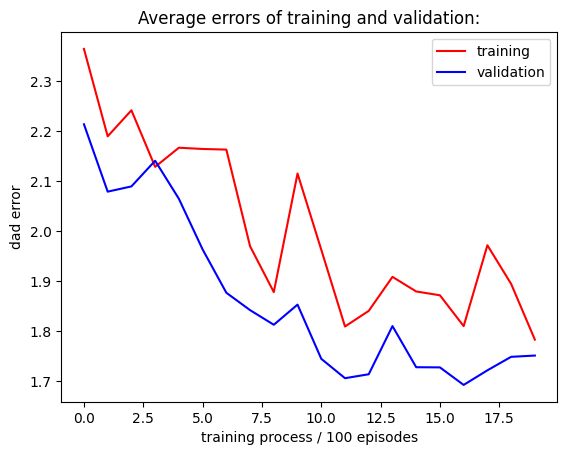

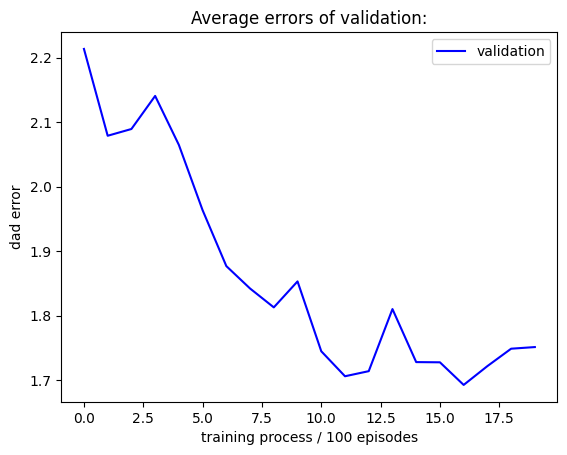

In [9]:
retrain(model_path='save_skip/96.36376516078319_ratio_0.1_sed/', traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='dad')

======loading train data======
It cost 5.434807538986206s.
training from last checkpoint save_skip/96.36376516078319_ratio_0.1_sed/
INFO:tensorflow:Restoring parameters from save_skip/96.36376516078319_ratio_0.1_sed/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/it]


round 0 episode 100: Training error: 9.19740634466083, Validation error: 9.99925557711601
Save model with error 9.99925557711601
==>current best model is 9.99925557711601 with ratio 0.1
It costs 270.95155668258667s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.51s/it]


round 0 episode 200: Training error: 8.313932771315315, Validation error: 7.616995884732803
Save model with error 7.616995884732803
==>current best model is 7.616995884732803 with ratio 0.1
It costs 277.97335982322693s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.34s/it]


round 1 episode 100: Training error: 7.360446122633253, Validation error: 7.832810084491008
==>current best model is 7.616995884732803 with ratio 0.1
It costs 260.5409126281738s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.66s/it]


round 1 episode 200: Training error: 7.2083919330490405, Validation error: 9.918201769238564
==>current best model is 7.616995884732803 with ratio 0.1
It costs 292.05029129981995s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.40s/it]


round 2 episode 100: Training error: 8.325820468523068, Validation error: 7.76352020552041
==>current best model is 7.616995884732803 with ratio 0.1
It costs 267.0702633857727s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]


round 2 episode 200: Training error: 6.518017689983266, Validation error: 7.82761682489202
==>current best model is 7.616995884732803 with ratio 0.1
It costs 289.58671617507935s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


round 3 episode 100: Training error: 6.684586546879346, Validation error: 7.329072059777175
Save model with error 7.329072059777175
==>current best model is 7.329072059777175 with ratio 0.1
It costs 286.0914559364319s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.50s/it]


round 3 episode 200: Training error: 7.997655157592606, Validation error: 6.6650845574526825
Save model with error 6.6650845574526825
==>current best model is 6.6650845574526825 with ratio 0.1
It costs 277.7194592952728s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.62s/it]


round 4 episode 100: Training error: 6.491722526561237, Validation error: 6.73651442777289
==>current best model is 6.6650845574526825 with ratio 0.1
It costs 289.47984790802s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.43s/it]


round 4 episode 200: Training error: 7.906656867314866, Validation error: 6.63308582674403
Save model with error 6.63308582674403
==>current best model is 6.63308582674403 with ratio 0.1
It costs 270.6740548610687s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:51<00:00,  1.72s/it]


round 5 episode 100: Training error: 6.787941673628524, Validation error: 7.397647707116611
==>current best model is 6.63308582674403 with ratio 0.1
It costs 300.2730760574341s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.34s/it]


round 5 episode 200: Training error: 7.7470085018687485, Validation error: 7.901160753674688
==>current best model is 6.63308582674403 with ratio 0.1
It costs 262.94651889801025s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


round 6 episode 100: Training error: 7.637299725744161, Validation error: 7.64539922566374
==>current best model is 6.63308582674403 with ratio 0.1
It costs 282.3305208683014s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.52s/it]


round 6 episode 200: Training error: 6.15855486380104, Validation error: 6.496413347457346
Save model with error 6.496413347457346
==>current best model is 6.496413347457346 with ratio 0.1
It costs 280.7643504142761s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:51<00:00,  1.71s/it]


round 7 episode 100: Training error: 7.421565256788791, Validation error: 6.633778750555613
==>current best model is 6.496413347457346 with ratio 0.1
It costs 299.86016821861267s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.35s/it]


round 7 episode 200: Training error: 6.98034256886672, Validation error: 6.925910667759839
==>current best model is 6.496413347457346 with ratio 0.1
It costs 261.76927518844604s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


round 8 episode 100: Training error: 6.561791274003902, Validation error: 7.679519486730042
==>current best model is 6.496413347457346 with ratio 0.1
It costs 262.9723448753357s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:51<00:00,  1.72s/it]


round 8 episode 200: Training error: 7.116842632289552, Validation error: 6.205896143777977
Save model with error 6.205896143777977
==>current best model is 6.205896143777977 with ratio 0.1
It costs 300.35119557380676s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.64s/it]


round 9 episode 100: Training error: 6.718875624672233, Validation error: 6.393367081393233
==>current best model is 6.205896143777977 with ratio 0.1
It costs 295.041068315506s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.45s/it]


round 9 episode 200: Training error: 7.185434754234094, Validation error: 7.60727866998182
==>current best model is 6.205896143777977 with ratio 0.1
It costs 272.66341066360474s
Training elapsed time = %s 5601.110918045044


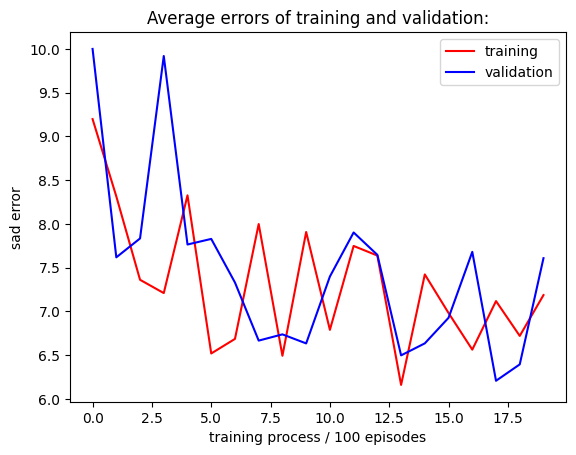

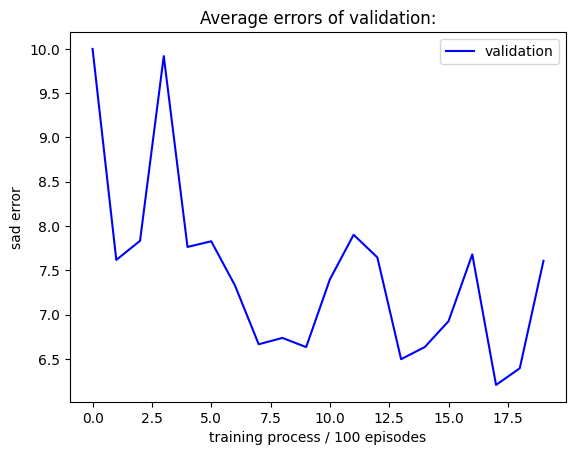

In [10]:
retrain(model_path='save_skip/96.36376516078319_ratio_0.1_sed/', traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='sad')

======loading train data======
It cost 5.64579701423645s.
training from last checkpoint save_skip/42.764305274010006_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save_skip/42.764305274010006_ratio_0.1_ped/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.30s/it]


round 0 episode 100: Training error: 89.46040990570098, Validation error: 112.71676184038051
Save model with error 112.71676184038051
==>current best model is 112.71676184038051 with ratio 0.1
It costs 242.77573537826538s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.26s/it]


round 0 episode 200: Training error: 152.19503709794466, Validation error: 110.59775468700725
Save model with error 110.59775468700725
==>current best model is 110.59775468700725 with ratio 0.1
It costs 237.61830186843872s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it]


round 1 episode 100: Training error: 92.7570669775145, Validation error: 131.89928091187136
==>current best model is 110.59775468700725 with ratio 0.1
It costs 217.3659064769745s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.48s/it]


round 1 episode 200: Training error: 117.55509540149016, Validation error: 104.3973472613898
Save model with error 104.3973472613898
==>current best model is 104.3973472613898 with ratio 0.1
It costs 259.9948983192444s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.19s/it]


round 2 episode 100: Training error: 102.27732270972487, Validation error: 96.54802397068957
Save model with error 96.54802397068957
==>current best model is 96.54802397068957 with ratio 0.1
It costs 231.9333426952362s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


round 2 episode 200: Training error: 94.72351275702138, Validation error: 103.49585086903797
==>current best model is 96.54802397068957 with ratio 0.1
It costs 241.86684036254883s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


round 3 episode 100: Training error: 107.69114156632472, Validation error: 98.58984929766487
==>current best model is 96.54802397068957 with ratio 0.1
It costs 223.3157238960266s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


round 3 episode 200: Training error: 126.6562903277122, Validation error: 97.99177807909714
==>current best model is 96.54802397068957 with ratio 0.1
It costs 241.9047131538391s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.20s/it]


round 4 episode 100: Training error: 101.66317266227752, Validation error: 116.33365669403797
==>current best model is 96.54802397068957 with ratio 0.1
It costs 236.01274037361145s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.32s/it]


round 4 episode 200: Training error: 104.13800083327706, Validation error: 105.58743341154144
==>current best model is 96.54802397068957 with ratio 0.1
It costs 244.93012237548828s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]


round 5 episode 100: Training error: 100.09416385530791, Validation error: 98.69821769738077
==>current best model is 96.54802397068957 with ratio 0.1
It costs 237.04319953918457s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.20s/it]


round 5 episode 200: Training error: 82.28233997387612, Validation error: 91.14192966629804
Save model with error 91.14192966629804
==>current best model is 91.14192966629804 with ratio 0.1
It costs 232.65072631835938s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


round 6 episode 100: Training error: 99.97275682560732, Validation error: 99.05612036011716
==>current best model is 91.14192966629804 with ratio 0.1
It costs 246.12085032463074s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:53<00:00,  1.14s/it]


round 6 episode 200: Training error: 85.85606582459182, Validation error: 89.78200366875532
Save model with error 89.78200366875532
==>current best model is 89.78200366875532 with ratio 0.1
It costs 226.9945080280304s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.27s/it]


round 7 episode 100: Training error: 82.37535151684604, Validation error: 93.02893354615435
==>current best model is 89.78200366875532 with ratio 0.1
It costs 239.66046452522278s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.24s/it]


round 7 episode 200: Training error: 90.17339524617299, Validation error: 116.03256475476314
==>current best model is 89.78200366875532 with ratio 0.1
It costs 236.9347677230835s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.26s/it]


round 8 episode 100: Training error: 77.5176927161973, Validation error: 91.15670697473743
==>current best model is 89.78200366875532 with ratio 0.1
It costs 238.86009573936462s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.20s/it]


round 8 episode 200: Training error: 101.83960774438945, Validation error: 85.49724994009317
Save model with error 85.49724994009317
==>current best model is 85.49724994009317 with ratio 0.1
It costs 235.2118215560913s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.29s/it]


round 9 episode 100: Training error: 101.86098740466363, Validation error: 93.89644437662925
==>current best model is 85.49724994009317 with ratio 0.1
It costs 241.9635534286499s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


round 9 episode 200: Training error: 84.69295910310667, Validation error: 98.61822994180119
==>current best model is 85.49724994009317 with ratio 0.1
It costs 233.2185697555542s
Training elapsed time = %s 4746.378436326981


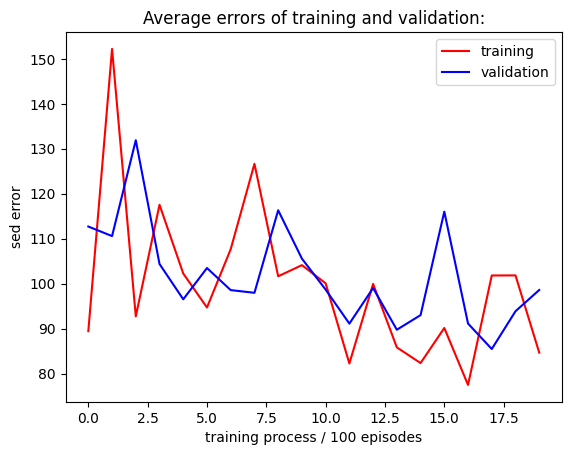

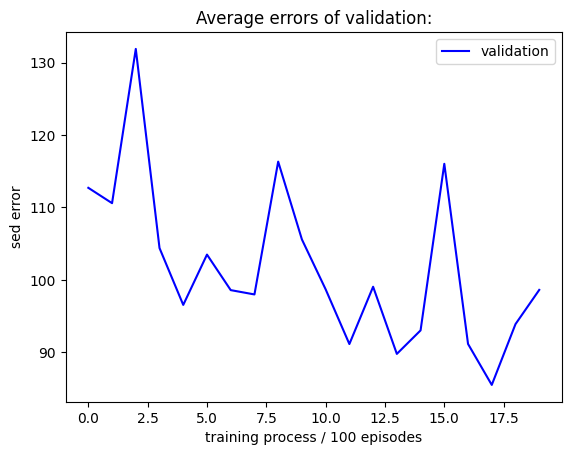

In [11]:
retrain(model_path='save_skip/42.764305274010006_ratio_0.1_ped/', traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='sed')

======loading train data======
It cost 6.008167505264282s.
training from last checkpoint save_skip/42.764305274010006_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save_skip/42.764305274010006_ratio_0.1_ped/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.07s/it]


round 0 episode 100: Training error: 2.4317263558504156, Validation error: 2.3029243807830935
Save model with error 2.3029243807830935
==>current best model is 2.3029243807830935 with ratio 0.1
It costs 211.43862891197205s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:56<00:00,  1.17s/it]


round 0 episode 200: Training error: 2.285621876370459, Validation error: 2.1808312303251087
Save model with error 2.1808312303251087
==>current best model is 2.1808312303251087 with ratio 0.1
It costs 221.14849638938904s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


round 1 episode 100: Training error: 2.2446374668919873, Validation error: 2.106895809019501
Save model with error 2.106895809019501
==>current best model is 2.106895809019501 with ratio 0.1
It costs 220.646222114563s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.15s/it]


round 1 episode 200: Training error: 2.2097484084763073, Validation error: 2.1204458827960124
==>current best model is 2.106895809019501 with ratio 0.1
It costs 220.89164757728577s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.33s/it]


round 2 episode 100: Training error: 2.2229186922170987, Validation error: 2.0695799610088064
Save model with error 2.0695799610088064
==>current best model is 2.0695799610088064 with ratio 0.1
It costs 241.8817207813263s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


round 2 episode 200: Training error: 2.0273300603307782, Validation error: 2.0550183063759495
Save model with error 2.0550183063759495
==>current best model is 2.0550183063759495 with ratio 0.1
It costs 208.81243419647217s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.08s/it]


round 3 episode 100: Training error: 2.1196041159461347, Validation error: 2.0190666668117516
Save model with error 2.0190666668117516
==>current best model is 2.0190666668117516 with ratio 0.1
It costs 217.06114149093628s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.26s/it]


round 3 episode 200: Training error: 2.126102870227969, Validation error: 1.9421008711577117
Save model with error 1.9421008711577117
==>current best model is 1.9421008711577117 with ratio 0.1
It costs 236.38207721710205s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


round 4 episode 100: Training error: 1.8888328171047886, Validation error: 1.9376833759876873
Save model with error 1.9376833759876873
==>current best model is 1.9376833759876873 with ratio 0.1
It costs 202.38695812225342s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.45s/it]


round 4 episode 200: Training error: 2.1004558068801575, Validation error: 2.006722896074976
==>current best model is 1.9376833759876873 with ratio 0.1
It costs 254.13404297828674s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


round 5 episode 100: Training error: 2.0012800040527905, Validation error: 1.850566927165863
Save model with error 1.850566927165863
==>current best model is 1.850566927165863 with ratio 0.1
It costs 243.61207842826843s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it]


round 5 episode 200: Training error: 1.9696233984206637, Validation error: 1.9000219943148948
==>current best model is 1.850566927165863 with ratio 0.1
It costs 213.89540004730225s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/it]


round 6 episode 100: Training error: 1.9716324589247196, Validation error: 1.823977992954474
Save model with error 1.823977992954474
==>current best model is 1.823977992954474 with ratio 0.1
It costs 214.88210082054138s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.33s/it]


round 6 episode 200: Training error: 1.9222188278057581, Validation error: 1.8754163940360606
==>current best model is 1.823977992954474 with ratio 0.1
It costs 242.8752429485321s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


round 7 episode 100: Training error: 2.0000902465167028, Validation error: 1.8359779741537474
==>current best model is 1.823977992954474 with ratio 0.1
It costs 240.43947100639343s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.05s/it]


round 7 episode 200: Training error: 1.8592493010907425, Validation error: 1.7622371153233436
Save model with error 1.7622371153233436
==>current best model is 1.7622371153233436 with ratio 0.1
It costs 216.93107271194458s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:56<00:00,  1.17s/it]


round 8 episode 100: Training error: 1.7112461918089577, Validation error: 1.8053704677110707
==>current best model is 1.7622371153233436 with ratio 0.1
It costs 227.10226678848267s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.21s/it]


round 8 episode 200: Training error: 2.0050695498787054, Validation error: 1.7384959459123017
Save model with error 1.7384959459123017
==>current best model is 1.7384959459123017 with ratio 0.1
It costs 232.33377313613892s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


round 9 episode 100: Training error: 1.8521074583234765, Validation error: 1.7293385360112359
Save model with error 1.7293385360112359
==>current best model is 1.7293385360112359 with ratio 0.1
It costs 226.06166100502014s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]


round 9 episode 200: Training error: 1.9363603617673792, Validation error: 1.814127302165136
==>current best model is 1.7293385360112359 with ratio 0.1
It costs 235.99054670333862s
Training elapsed time = %s 4528.9090185165405


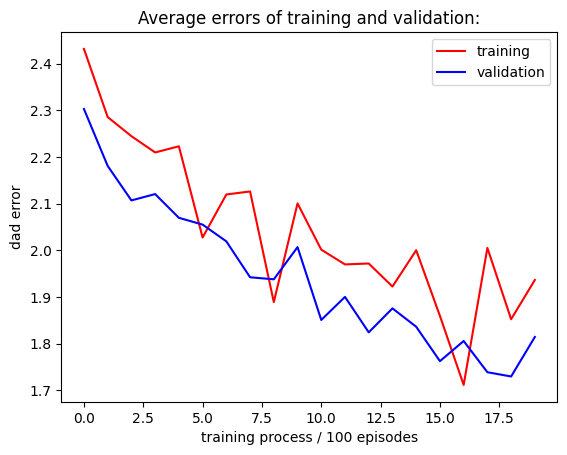

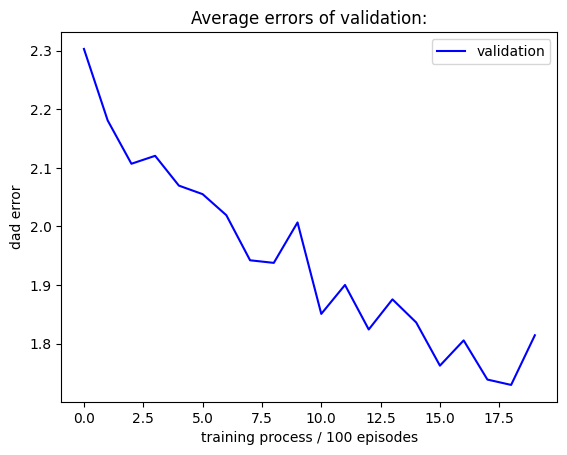

In [12]:
retrain(model_path='save_skip/42.764305274010006_ratio_0.1_ped/', traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='dad')

======loading train data======
It cost 5.731995582580566s.
training from last checkpoint save_skip/42.764305274010006_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save_skip/42.764305274010006_ratio_0.1_ped/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.22s/it]


round 0 episode 100: Training error: 8.792607163577957, Validation error: 8.918122208074275
Save model with error 8.918122208074275
==>current best model is 8.918122208074275 with ratio 0.1
It costs 245.52916502952576s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:53<00:00,  1.74s/it]


round 0 episode 200: Training error: 9.166829448071526, Validation error: 7.831414190201009
Save model with error 7.831414190201009
==>current best model is 7.831414190201009 with ratio 0.1
It costs 299.3728814125061s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.37s/it]


round 1 episode 100: Training error: 8.845888427378231, Validation error: 7.475890162849392
Save model with error 7.475890162849392
==>current best model is 7.475890162849392 with ratio 0.1
It costs 262.27127480506897s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]


round 1 episode 200: Training error: 7.469204796739213, Validation error: 8.456603761803658
==>current best model is 7.475890162849392 with ratio 0.1
It costs 286.4468185901642s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


round 2 episode 100: Training error: 10.267558282008524, Validation error: 6.768641028082022
Save model with error 6.768641028082022
==>current best model is 6.768641028082022 with ratio 0.1
It costs 279.3065962791443s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.46s/it]


round 2 episode 200: Training error: 8.720685348890418, Validation error: 7.164980701477004
==>current best model is 6.768641028082022 with ratio 0.1
It costs 273.3065357208252s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:51<00:00,  1.71s/it]


round 3 episode 100: Training error: 7.671808115762201, Validation error: 6.866375954866018
==>current best model is 6.768641028082022 with ratio 0.1
It costs 296.85014629364014s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.28s/it]


round 3 episode 200: Training error: 8.965359432735534, Validation error: 8.76890493920196
==>current best model is 6.768641028082022 with ratio 0.1
It costs 254.69499349594116s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.64s/it]


round 4 episode 100: Training error: 8.791041408879934, Validation error: 8.987126842636362
==>current best model is 6.768641028082022 with ratio 0.1
It costs 290.80730962753296s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.47s/it]


round 4 episode 200: Training error: 7.15381606572237, Validation error: 7.2970200870207504
==>current best model is 6.768641028082022 with ratio 0.1
It costs 273.1670653820038s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:05<00:00,  1.86s/it]


round 5 episode 100: Training error: 7.614074120614744, Validation error: 6.891658029530713
==>current best model is 6.768641028082022 with ratio 0.1
It costs 312.3159120082855s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]


round 5 episode 200: Training error: 8.084072913170425, Validation error: 6.752563132254498
Save model with error 6.752563132254498
==>current best model is 6.752563132254498 with ratio 0.1
It costs 244.45727610588074s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:06<00:00,  1.86s/it]


round 6 episode 100: Training error: 7.179886585512538, Validation error: 6.607497001044838
Save model with error 6.607497001044838
==>current best model is 6.607497001044838 with ratio 0.1
It costs 314.38917660713196s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.20s/it]


round 6 episode 200: Training error: 7.556495160033153, Validation error: 6.280467714304436
Save model with error 6.280467714304436
==>current best model is 6.280467714304436 with ratio 0.1
It costs 248.81378984451294s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.58s/it]


round 7 episode 100: Training error: 7.265017853273576, Validation error: 6.5998400140512254
==>current best model is 6.280467714304436 with ratio 0.1
It costs 284.59310269355774s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.50s/it]


round 7 episode 200: Training error: 7.086494101246478, Validation error: 6.455026033047864
==>current best model is 6.280467714304436 with ratio 0.1
It costs 276.4620666503906s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.57s/it]


round 8 episode 100: Training error: 6.4096008735720185, Validation error: 6.412987613739475
==>current best model is 6.280467714304436 with ratio 0.1
It costs 285.02819657325745s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.52s/it]


round 8 episode 200: Training error: 7.714632134626478, Validation error: 6.258997889155513
Save model with error 6.258997889155513
==>current best model is 6.258997889155513 with ratio 0.1
It costs 279.8757586479187s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.64s/it]


round 9 episode 100: Training error: 6.448647856180738, Validation error: 6.274617330731283
==>current best model is 6.258997889155513 with ratio 0.1
It costs 291.94804859161377s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.49s/it]


round 9 episode 200: Training error: 7.62505228413218, Validation error: 6.4188040441303755
==>current best model is 6.258997889155513 with ratio 0.1
It costs 276.534147977829s
Training elapsed time = %s 5576.172271966934


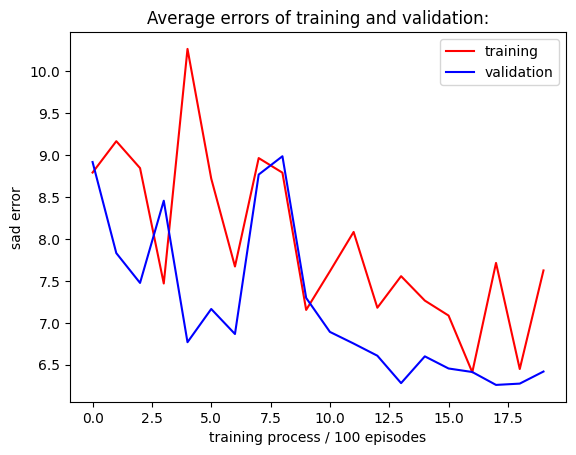

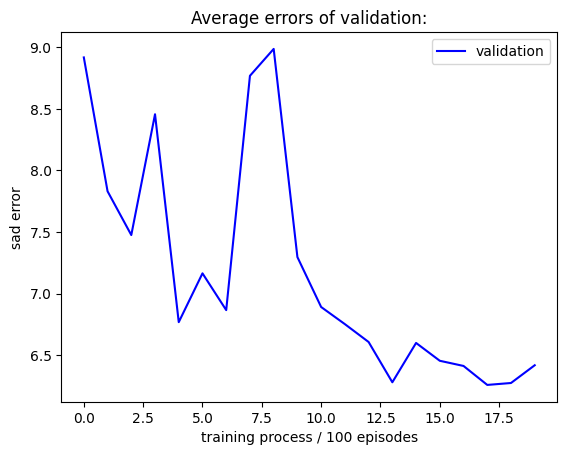

In [13]:
retrain(model_path='save_skip/42.764305274010006_ratio_0.1_ped/', traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='sad')

======loading train data======
It cost 5.545239210128784s.
training from last checkpoint save_skip/1.6362231449707547_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save_skip/1.6362231449707547_ratio_0.1_dad/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:53<00:00,  1.14s/it]


round 0 episode 100: Training error: 110.55159001883338, Validation error: 112.80248075413874
Save model with error 112.80248075413874
==>current best model is 112.80248075413874 with ratio 0.1
It costs 230.48604583740234s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.47s/it]


round 0 episode 200: Training error: 73.40524047242815, Validation error: 108.00024680484887
Save model with error 108.00024680484887
==>current best model is 108.00024680484887 with ratio 0.1
It costs 263.29206824302673s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.23s/it]


round 1 episode 100: Training error: 97.73541477189286, Validation error: 105.50378399437521
Save model with error 105.50378399437521
==>current best model is 105.50378399437521 with ratio 0.1
It costs 240.4130609035492s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


round 1 episode 200: Training error: 85.09627347111854, Validation error: 88.24054592675482
Save model with error 88.24054592675482
==>current best model is 88.24054592675482 with ratio 0.1
It costs 252.4019763469696s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


round 2 episode 100: Training error: 83.67310360346652, Validation error: 86.11787721787708
Save model with error 86.11787721787708
==>current best model is 86.11787721787708 with ratio 0.1
It costs 224.11302161216736s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.50s/it]


round 2 episode 200: Training error: 81.72856208563192, Validation error: 86.91444017329901
==>current best model is 86.11787721787708 with ratio 0.1
It costs 267.189879655838s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:01<00:00,  1.21s/it]


round 3 episode 100: Training error: 92.74867260488492, Validation error: 98.3340098653677
==>current best model is 86.11787721787708 with ratio 0.1
It costs 238.35833311080933s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.35s/it]


round 3 episode 200: Training error: 71.33655332038228, Validation error: 90.40018613557592
==>current best model is 86.11787721787708 with ratio 0.1
It costs 251.9910237789154s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


round 4 episode 100: Training error: 78.24088731783347, Validation error: 93.49786098937282
==>current best model is 86.11787721787708 with ratio 0.1
It costs 233.39625120162964s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.40s/it]


round 4 episode 200: Training error: 90.09094119860336, Validation error: 104.36345769157685
==>current best model is 86.11787721787708 with ratio 0.1
It costs 256.2191665172577s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.47s/it]


round 5 episode 100: Training error: 85.50675667309025, Validation error: 99.91766907946237
==>current best model is 86.11787721787708 with ratio 0.1
It costs 264.3152496814728s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.11s/it]


round 5 episode 200: Training error: 91.17205947211964, Validation error: 93.1849145129639
==>current best model is 86.11787721787708 with ratio 0.1
It costs 228.55250453948975s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.12s/it]


round 6 episode 100: Training error: 87.32877134135728, Validation error: 88.75677161548302
==>current best model is 86.11787721787708 with ratio 0.1
It costs 232.62701654434204s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.44s/it]


round 6 episode 200: Training error: 73.1830972796552, Validation error: 88.14546870952931
==>current best model is 86.11787721787708 with ratio 0.1
It costs 260.43015027046204s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.51s/it]


round 7 episode 100: Training error: 72.99908749875168, Validation error: 88.8425711874526
==>current best model is 86.11787721787708 with ratio 0.1
It costs 267.7075083255768s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


round 7 episode 200: Training error: 96.38525996056237, Validation error: 92.28549160111326
==>current best model is 86.11787721787708 with ratio 0.1
It costs 226.48226881027222s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.24s/it]


round 8 episode 100: Training error: 47.20741047482439, Validation error: 90.27885916881641
==>current best model is 86.11787721787708 with ratio 0.1
It costs 238.45186376571655s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:07<00:00,  1.27s/it]


round 8 episode 200: Training error: 116.99178313978044, Validation error: 82.51590753057037
Save model with error 82.51590753057037
==>current best model is 82.51590753057037 with ratio 0.1
It costs 241.99519419670105s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.28s/it]


round 9 episode 100: Training error: 97.36227565478194, Validation error: 83.71193997530963
==>current best model is 82.51590753057037 with ratio 0.1
It costs 258.9166634082794s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.33s/it]


round 9 episode 200: Training error: 57.848606988851934, Validation error: 88.05212257406569
==>current best model is 82.51590753057037 with ratio 0.1
It costs 259.17803406715393s
Training elapsed time = %s 4936.519332885742


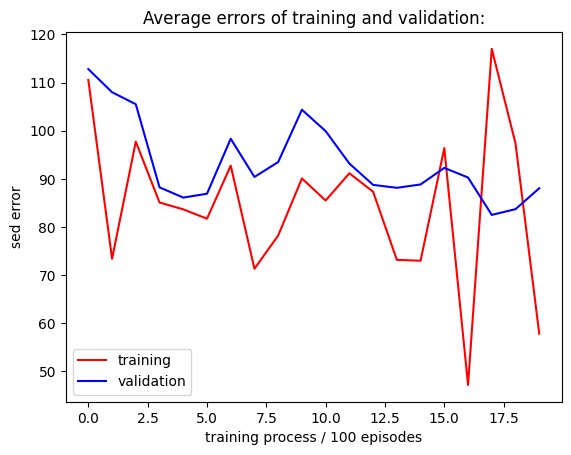

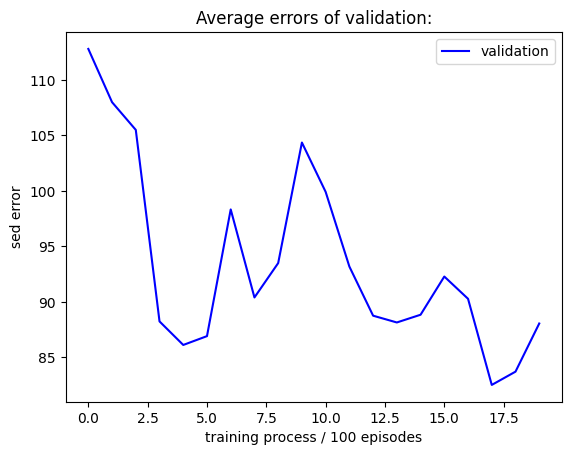

In [14]:
retrain(model_path='save_skip/1.6362231449707547_ratio_0.1_dad/', traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='sed')

======loading train data======
It cost 6.665572166442871s.
training from last checkpoint save_skip/1.6362231449707547_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save_skip/1.6362231449707547_ratio_0.1_dad/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.35s/it]


round 0 episode 100: Training error: 30.101716303908677, Validation error: 53.256604901043744
Save model with error 53.256604901043744
==>current best model is 53.256604901043744 with ratio 0.1
It costs 251.17518091201782s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.26s/it]


round 0 episode 200: Training error: 35.35873540201986, Validation error: 49.56451574328236
Save model with error 49.56451574328236
==>current best model is 49.56451574328236 with ratio 0.1
It costs 242.75327229499817s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


round 1 episode 100: Training error: 34.65226058517517, Validation error: 54.5402456678302
==>current best model is 49.56451574328236 with ratio 0.1
It costs 227.49749851226807s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.34s/it]


round 1 episode 200: Training error: 30.06255513047132, Validation error: 56.00237277369078
==>current best model is 49.56451574328236 with ratio 0.1
It costs 251.94884181022644s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.19s/it]


round 2 episode 100: Training error: 39.90582511068791, Validation error: 49.91363509490179
==>current best model is 49.56451574328236 with ratio 0.1
It costs 237.9387936592102s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


round 2 episode 200: Training error: 24.06375385133874, Validation error: 54.851288756299056
==>current best model is 49.56451574328236 with ratio 0.1
It costs 246.24327635765076s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]


round 3 episode 100: Training error: 27.92815671600399, Validation error: 52.75435603818327
==>current best model is 49.56451574328236 with ratio 0.1
It costs 227.93751978874207s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:01<00:00,  1.22s/it]


round 3 episode 200: Training error: 35.37135447968561, Validation error: 51.03039661466888
==>current best model is 49.56451574328236 with ratio 0.1
It costs 236.03572154045105s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


round 4 episode 100: Training error: 23.608934759312568, Validation error: 44.87525537746026
Save model with error 44.87525537746026
==>current best model is 44.87525537746026 with ratio 0.1
It costs 249.21502566337585s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.25s/it]


round 4 episode 200: Training error: 51.846447857233414, Validation error: 59.3738662731636
==>current best model is 44.87525537746026 with ratio 0.1
It costs 241.3818142414093s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.42s/it]


round 5 episode 100: Training error: 29.284352890335935, Validation error: 53.927027149897704
==>current best model is 44.87525537746026 with ratio 0.1
It costs 255.18996596336365s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.11s/it]


round 5 episode 200: Training error: 28.956296197502756, Validation error: 51.98256750441989
==>current best model is 44.87525537746026 with ratio 0.1
It costs 227.40685772895813s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.16s/it]


round 6 episode 100: Training error: 37.020063531218, Validation error: 49.7931326543122
==>current best model is 44.87525537746026 with ratio 0.1
It costs 234.99223065376282s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.29s/it]


round 6 episode 200: Training error: 25.858862930057704, Validation error: 53.1634567762928
==>current best model is 44.87525537746026 with ratio 0.1
It costs 243.29433798789978s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


round 7 episode 100: Training error: 24.6015262759019, Validation error: 44.21322406910624
Save model with error 44.21322406910624
==>current best model is 44.21322406910624 with ratio 0.1
It costs 223.14309287071228s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.38s/it]


round 7 episode 200: Training error: 41.193953713296, Validation error: 43.53681788792537
Save model with error 43.53681788792537
==>current best model is 43.53681788792537 with ratio 0.1
It costs 253.04959774017334s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


round 8 episode 100: Training error: 36.49785066224975, Validation error: 50.14807508921296
==>current best model is 43.53681788792537 with ratio 0.1
It costs 213.3545093536377s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.46s/it]


round 8 episode 200: Training error: 20.471640978741117, Validation error: 49.24626445560982
==>current best model is 43.53681788792537 with ratio 0.1
It costs 260.3015375137329s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


round 9 episode 100: Training error: 42.12054276767234, Validation error: 44.303390084582745
==>current best model is 43.53681788792537 with ratio 0.1
It costs 222.36658716201782s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.34s/it]


round 9 episode 200: Training error: 25.414808059368916, Validation error: 44.506097801620356
==>current best model is 43.53681788792537 with ratio 0.1
It costs 246.90287399291992s
Training elapsed time = %s 4792.130520820618


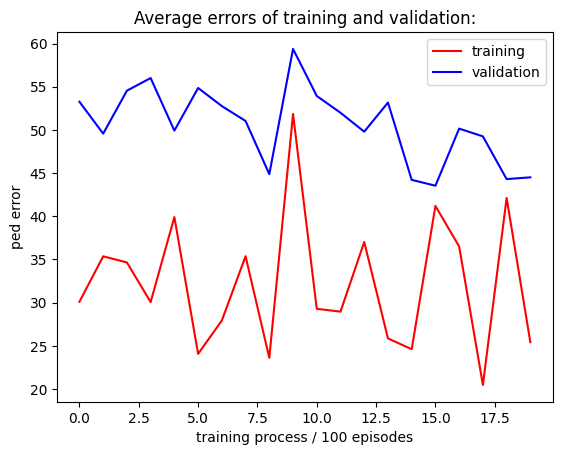

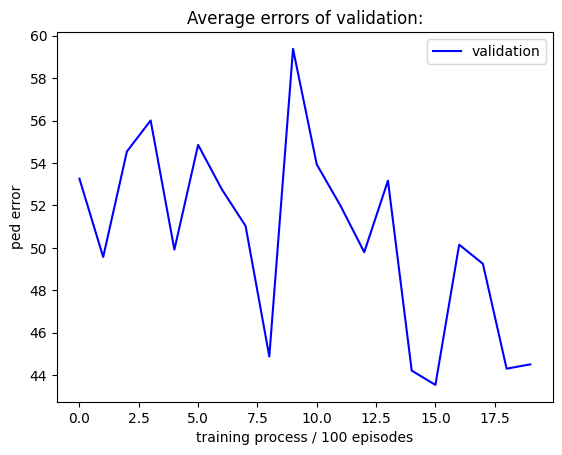

In [15]:
retrain(model_path='save_skip/1.6362231449707547_ratio_0.1_dad/', traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='ped')

======loading train data======
It cost 5.819144010543823s.
training from last checkpoint save_skip/1.6362231449707547_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save_skip/1.6362231449707547_ratio_0.1_dad/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.66s/it]


round 0 episode 100: Training error: 6.05147773022262, Validation error: 6.338435596974661
Save model with error 6.338435596974661
==>current best model is 6.338435596974661 with ratio 0.1
It costs 303.8668131828308s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.52s/it]


round 0 episode 200: Training error: 7.628102737027617, Validation error: 6.459484411410816
==>current best model is 6.338435596974661 with ratio 0.1
It costs 281.960608959198s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:51<00:00,  1.72s/it]


round 1 episode 100: Training error: 7.198278031807239, Validation error: 6.261773153000523
Save model with error 6.261773153000523
==>current best model is 6.261773153000523 with ratio 0.1
It costs 301.22118163108826s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.51s/it]


round 1 episode 200: Training error: 6.483382832015781, Validation error: 6.229591989112358
Save model with error 6.229591989112358
==>current best model is 6.229591989112358 with ratio 0.1
It costs 280.1312131881714s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.57s/it]


round 2 episode 100: Training error: 5.8195784018350825, Validation error: 6.280306330103393
==>current best model is 6.229591989112358 with ratio 0.1
It costs 286.0603322982788s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.57s/it]


round 2 episode 200: Training error: 7.947022553846173, Validation error: 6.406951162101322
==>current best model is 6.229591989112358 with ratio 0.1
It costs 286.8609757423401s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.37s/it]


round 3 episode 100: Training error: 7.807789872793987, Validation error: 6.268193598609986
==>current best model is 6.229591989112358 with ratio 0.1
It costs 268.95900893211365s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:07<00:00,  1.88s/it]


round 3 episode 200: Training error: 5.82891267247587, Validation error: 6.308617603962721
==>current best model is 6.229591989112358 with ratio 0.1
It costs 324.0496983528137s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.25s/it]


round 4 episode 100: Training error: 7.321417031797227, Validation error: 6.327807103525717
==>current best model is 6.229591989112358 with ratio 0.1
It costs 253.66243028640747s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:10<00:00,  1.91s/it]


round 4 episode 200: Training error: 6.371760933330405, Validation error: 6.341123490337015
==>current best model is 6.229591989112358 with ratio 0.1
It costs 319.23339891433716s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/it]


round 5 episode 100: Training error: 7.215969294004947, Validation error: 6.324218186167065
==>current best model is 6.229591989112358 with ratio 0.1
It costs 274.26309466362s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:52<00:00,  1.72s/it]


round 5 episode 200: Training error: 6.490544249749486, Validation error: 6.326671789646528
==>current best model is 6.229591989112358 with ratio 0.1
It costs 308.27960300445557s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.65s/it]


round 6 episode 100: Training error: 6.499594397916406, Validation error: 6.262423871221136
==>current best model is 6.229591989112358 with ratio 0.1
It costs 296.02313137054443s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:01<00:00,  1.81s/it]


round 6 episode 200: Training error: 7.18763922935074, Validation error: 6.292642466189704
==>current best model is 6.229591989112358 with ratio 0.1
It costs 312.7844018936157s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:54<00:00,  2.34s/it]


round 7 episode 100: Training error: 6.446875729236573, Validation error: 6.351153429362416
==>current best model is 6.229591989112358 with ratio 0.1
It costs 479.8133707046509s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [04:18<00:00,  2.58s/it]


round 7 episode 200: Training error: 7.2793928241786645, Validation error: 7.352613265916216
==>current best model is 6.229591989112358 with ratio 0.1
It costs 501.2303946018219s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [04:17<00:00,  2.57s/it]


round 8 episode 100: Training error: 6.513680531885597, Validation error: 6.3406943156344795
==>current best model is 6.229591989112358 with ratio 0.1
It costs 386.53320837020874s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


round 8 episode 200: Training error: 7.119567077383145, Validation error: 6.217648759527948
Save model with error 6.217648759527948
==>current best model is 6.217648759527948 with ratio 0.1
It costs 294.72419786453247s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/it]


round 9 episode 100: Training error: 6.531765969818618, Validation error: 6.323432667488518
==>current best model is 6.217648759527948 with ratio 0.1
It costs 274.8875181674957s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:52<00:00,  1.72s/it]


round 9 episode 200: Training error: 7.212276300140889, Validation error: 6.346695122247783
==>current best model is 6.217648759527948 with ratio 0.1
It costs 300.9079580307007s
Training elapsed time = %s 6335.45477771759


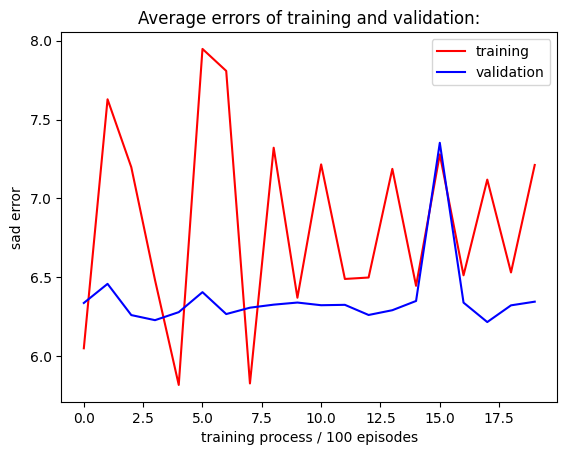

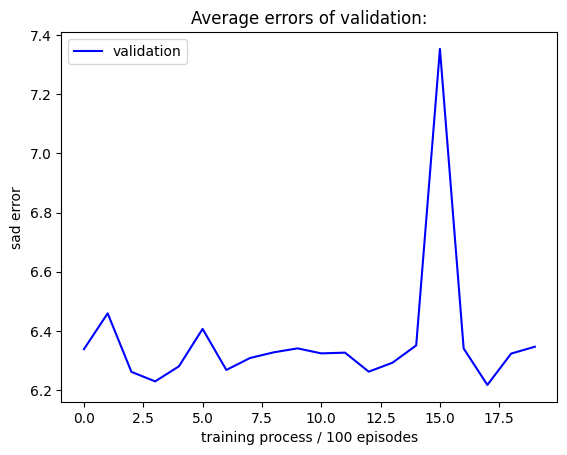

In [16]:
retrain(model_path='save_skip/1.6362231449707547_ratio_0.1_dad/', traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='sad')

======loading train data======
It cost 10.99260401725769s.
training from last checkpoint save_skip/6.220953541685593_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save_skip/6.220953541685593_ratio_0.1_sad/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.47s/it]


round 0 episode 100: Training error: 108.8128811220936, Validation error: 126.20031627819587
Save model with error 126.20031627819587
==>current best model is 126.20031627819587 with ratio 0.1
It costs 263.64786863327026s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


round 0 episode 200: Training error: 118.54533792410564, Validation error: 123.00346813725578
Save model with error 123.00346813725578
==>current best model is 123.00346813725578 with ratio 0.1
It costs 235.51536393165588s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:07<00:00,  1.27s/it]


round 1 episode 100: Training error: 122.57516340838188, Validation error: 123.72721274399862
==>current best model is 123.00346813725578 with ratio 0.1
It costs 244.28508925437927s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.40s/it]


round 1 episode 200: Training error: 106.7079428311995, Validation error: 126.2588245803793
==>current best model is 123.00346813725578 with ratio 0.1
It costs 255.77591514587402s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.15s/it]


round 2 episode 100: Training error: 135.12323954565133, Validation error: 118.70760419450097
Save model with error 118.70760419450097
==>current best model is 118.70760419450097 with ratio 0.1
It costs 232.713032245636s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.47s/it]


round 2 episode 200: Training error: 79.29971412093789, Validation error: 92.57342937037743
Save model with error 92.57342937037743
==>current best model is 92.57342937037743 with ratio 0.1
It costs 269.59521865844727s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:56<00:00,  1.17s/it]


round 3 episode 100: Training error: 72.41996782274967, Validation error: 93.06135464716934
==>current best model is 92.57342937037743 with ratio 0.1
It costs 235.06092405319214s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:20<00:00,  1.40s/it]


round 3 episode 200: Training error: 101.94144266236077, Validation error: 84.63310299187286
Save model with error 84.63310299187286
==>current best model is 84.63310299187286 with ratio 0.1
It costs 258.4127187728882s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.37s/it]


round 4 episode 100: Training error: 100.71171508511875, Validation error: 93.68398537976456
==>current best model is 84.63310299187286 with ratio 0.1
It costs 255.31792068481445s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.20s/it]


round 4 episode 200: Training error: 71.65130367573019, Validation error: 87.61715849681767
==>current best model is 84.63310299187286 with ratio 0.1
It costs 235.95412802696228s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


round 5 episode 100: Training error: 109.56690850735464, Validation error: 80.33238766066327
Save model with error 80.33238766066327
==>current best model is 80.33238766066327 with ratio 0.1
It costs 227.4485399723053s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.48s/it]


round 5 episode 200: Training error: 60.50813321008457, Validation error: 83.94281729635058
==>current best model is 80.33238766066327 with ratio 0.1
It costs 265.2212824821472s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.33s/it]


round 6 episode 100: Training error: 58.044107700822, Validation error: 89.34240830076726
==>current best model is 80.33238766066327 with ratio 0.1
It costs 248.94775366783142s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.24s/it]


round 6 episode 200: Training error: 109.93141023404283, Validation error: 92.14751023008318
==>current best model is 80.33238766066327 with ratio 0.1
It costs 241.50791597366333s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.37s/it]


round 7 episode 100: Training error: 59.11305341946314, Validation error: 86.05045842933588
==>current best model is 80.33238766066327 with ratio 0.1
It costs 253.05358052253723s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]


round 7 episode 200: Training error: 109.13639739075748, Validation error: 86.74131677664607
==>current best model is 80.33238766066327 with ratio 0.1
It costs 234.53202652931213s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.27s/it]


round 8 episode 100: Training error: 66.45343180709575, Validation error: 91.44649100412975
==>current best model is 80.33238766066327 with ratio 0.1
It costs 243.33235788345337s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.30s/it]


round 8 episode 200: Training error: 95.7291581498782, Validation error: 100.86863317573328
==>current best model is 80.33238766066327 with ratio 0.1
It costs 246.58701944351196s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


round 9 episode 100: Training error: 64.90095153932171, Validation error: 94.3251006671624
==>current best model is 80.33238766066327 with ratio 0.1
It costs 247.65956664085388s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.26s/it]


round 9 episode 200: Training error: 99.09883158926223, Validation error: 86.33749686252898
==>current best model is 80.33238766066327 with ratio 0.1
It costs 241.4989414215088s
Training elapsed time = %s 4936.069166660309


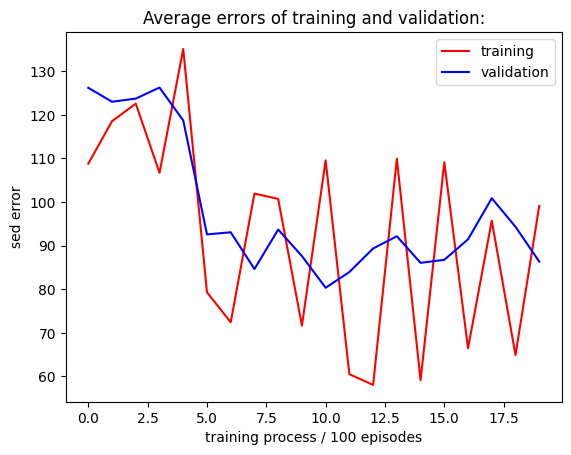

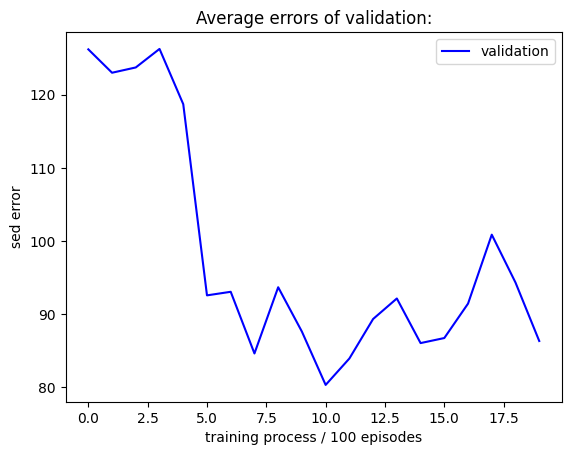

In [17]:
retrain(model_path='save_skip/6.220953541685593_ratio_0.1_sad/', traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='sed')

======loading train data======
It cost 5.973953008651733s.
training from last checkpoint save_skip/6.220953541685593_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save_skip/6.220953541685593_ratio_0.1_sad/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


round 0 episode 100: Training error: 32.56436149651469, Validation error: 54.47279859121421
Save model with error 54.47279859121421
==>current best model is 54.47279859121421 with ratio 0.1
It costs 224.5865454673767s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.28s/it]


round 0 episode 200: Training error: 33.253359495002556, Validation error: 52.702735536231145
Save model with error 52.702735536231145
==>current best model is 52.702735536231145 with ratio 0.1
It costs 238.65960836410522s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


round 1 episode 100: Training error: 26.56242842845865, Validation error: 54.68806909646493
==>current best model is 52.702735536231145 with ratio 0.1
It costs 241.06956934928894s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.07s/it]


round 1 episode 200: Training error: 39.09446898595369, Validation error: 49.07286629732071
Save model with error 49.07286629732071
==>current best model is 49.07286629732071 with ratio 0.1
It costs 217.59981846809387s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.34s/it]


round 2 episode 100: Training error: 36.48006625395717, Validation error: 52.33415288894991
==>current best model is 49.07286629732071 with ratio 0.1
It costs 243.17289304733276s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.03s/it]


round 2 episode 200: Training error: 28.754166707386013, Validation error: 52.42359076387961
==>current best model is 49.07286629732071 with ratio 0.1
It costs 212.72535157203674s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.12s/it]


round 3 episode 100: Training error: 31.0313170697456, Validation error: 59.29749709623007
==>current best model is 49.07286629732071 with ratio 0.1
It costs 221.47997903823853s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]


round 3 episode 200: Training error: 33.26452700037055, Validation error: 47.483672551714534
Save model with error 47.483672551714534
==>current best model is 47.483672551714534 with ratio 0.1
It costs 234.56279826164246s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:56<00:00,  1.17s/it]


round 4 episode 100: Training error: 29.766338535631608, Validation error: 54.79896589909445
==>current best model is 47.483672551714534 with ratio 0.1
It costs 226.24267721176147s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]


round 4 episode 200: Training error: 42.94583311028763, Validation error: 54.23382958712982
==>current best model is 47.483672551714534 with ratio 0.1
It costs 227.49549984931946s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.12s/it]


round 5 episode 100: Training error: 35.37411592785404, Validation error: 61.4012386655182
==>current best model is 47.483672551714534 with ratio 0.1
It costs 222.26457691192627s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.25s/it]


round 5 episode 200: Training error: 25.7324861338112, Validation error: 48.834176612439336
==>current best model is 47.483672551714534 with ratio 0.1
It costs 235.4060571193695s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.20s/it]


round 6 episode 100: Training error: 37.86365464040228, Validation error: 48.44213325165851
==>current best model is 47.483672551714534 with ratio 0.1
It costs 229.84704160690308s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.19s/it]


round 6 episode 200: Training error: 22.60253253404168, Validation error: 45.80588822063905
Save model with error 45.80588822063905
==>current best model is 45.80588822063905 with ratio 0.1
It costs 229.11251997947693s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.23s/it]


round 7 episode 100: Training error: 20.575117683465024, Validation error: 38.45383667748532
Save model with error 38.45383667748532
==>current best model is 38.45383667748532 with ratio 0.1
It costs 233.27980494499207s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


round 7 episode 200: Training error: 35.05156462936683, Validation error: 43.96561585157881
==>current best model is 38.45383667748532 with ratio 0.1
It costs 219.41325759887695s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.23s/it]


round 8 episode 100: Training error: 26.283807449164183, Validation error: 49.957103014511034
==>current best model is 38.45383667748532 with ratio 0.1
It costs 232.78715324401855s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.16s/it]


round 8 episode 200: Training error: 32.17494037038748, Validation error: 52.48672601320838
==>current best model is 38.45383667748532 with ratio 0.1
It costs 227.27272057533264s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]


round 9 episode 100: Training error: 26.114768181014355, Validation error: 42.76641973597547
==>current best model is 38.45383667748532 with ratio 0.1
It costs 227.75833415985107s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]


round 9 episode 200: Training error: 39.5598236403154, Validation error: 54.84100116775976
==>current best model is 38.45383667748532 with ratio 0.1
It costs 228.0644814968109s
Training elapsed time = %s 4572.801055192947


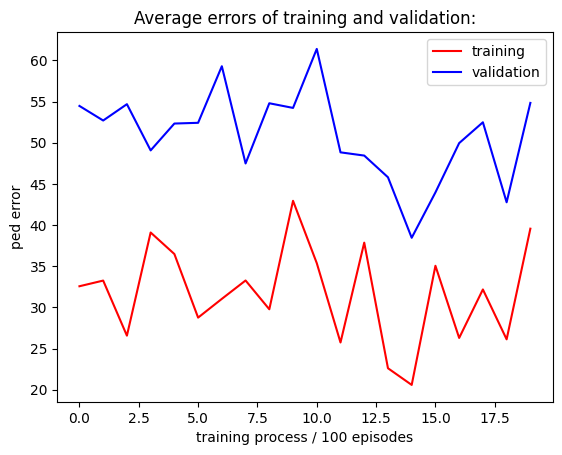

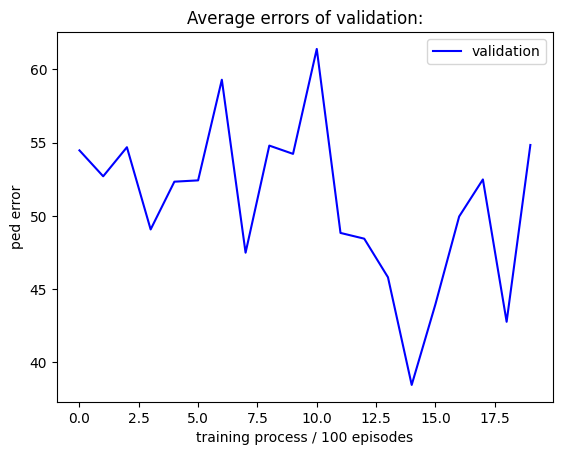

In [18]:
retrain(model_path='save_skip/6.220953541685593_ratio_0.1_sad/', traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='ped')

======loading train data======
It cost 13.281358003616333s.
training from last checkpoint save_skip/6.220953541685593_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save_skip/6.220953541685593_ratio_0.1_sad/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [04:17<00:00,  2.57s/it]


round 0 episode 100: Training error: 1.8377602890921494, Validation error: 1.744247118250874
Save model with error 1.744247118250874
==>current best model is 1.744247118250874 with ratio 0.1
It costs 461.6280024051666s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:56<00:00,  1.76s/it]


round 0 episode 200: Training error: 1.8304895535124068, Validation error: 1.724650711557327
Save model with error 1.724650711557327
==>current best model is 1.724650711557327 with ratio 0.1
It costs 379.22636675834656s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:50<00:00,  2.31s/it]


round 1 episode 100: Training error: 1.7117094631270584, Validation error: 1.7238890111995473
Save model with error 1.7238890111995473
==>current best model is 1.7238890111995473 with ratio 0.1
It costs 433.92372822761536s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:21<00:00,  2.01s/it]


round 1 episode 200: Training error: 1.925366080064223, Validation error: 1.722621682647627
Save model with error 1.722621682647627
==>current best model is 1.722621682647627 with ratio 0.1
It costs 411.8968937397003s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:21<00:00,  2.02s/it]


round 2 episode 100: Training error: 1.8392768735297083, Validation error: 1.6680153709167993
Save model with error 1.6680153709167993
==>current best model is 1.6680153709167993 with ratio 0.1
It costs 420.60374426841736s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [04:05<00:00,  2.45s/it]


round 2 episode 200: Training error: 1.7937198161092953, Validation error: 1.6517502500297774
Save model with error 1.6517502500297774
==>current best model is 1.6517502500297774 with ratio 0.1
It costs 461.2387897968292s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:38<00:00,  2.18s/it]


round 3 episode 100: Training error: 1.9296615834658561, Validation error: 1.65420510716381
==>current best model is 1.6517502500297774 with ratio 0.1
It costs 438.85803484916687s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [04:05<00:00,  2.45s/it]


round 3 episode 200: Training error: 1.6357046286634098, Validation error: 1.6710570968338632
==>current best model is 1.6517502500297774 with ratio 0.1
It costs 453.6626524925232s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:51<00:00,  2.32s/it]


round 4 episode 100: Training error: 1.7984969316896864, Validation error: 1.675075174728995
==>current best model is 1.6517502500297774 with ratio 0.1
It costs 450.5299141407013s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:49<00:00,  2.30s/it]


round 4 episode 200: Training error: 1.8238517913016228, Validation error: 1.6931036256279537
==>current best model is 1.6517502500297774 with ratio 0.1
It costs 446.01694917678833s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:24<00:00,  2.05s/it]


round 5 episode 100: Training error: 1.7783832096171013, Validation error: 1.6778764975423495
==>current best model is 1.6517502500297774 with ratio 0.1
It costs 418.68285155296326s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [04:04<00:00,  2.45s/it]


round 5 episode 200: Training error: 1.8244223605280059, Validation error: 1.6445971669532686
Save model with error 1.6445971669532686
==>current best model is 1.6445971669532686 with ratio 0.1
It costs 453.7624409198761s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:27<00:00,  2.08s/it]


round 6 episode 100: Training error: 1.830979872709941, Validation error: 1.6623522193854208
==>current best model is 1.6445971669532686 with ratio 0.1
It costs 413.31221318244934s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:54<00:00,  2.35s/it]


round 6 episode 200: Training error: 1.7719565279592138, Validation error: 1.6717719796168486
==>current best model is 1.6445971669532686 with ratio 0.1
It costs 441.48727464675903s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:24<00:00,  2.05s/it]


round 7 episode 100: Training error: 1.8075867681587503, Validation error: 1.6656486341335572
==>current best model is 1.6445971669532686 with ratio 0.1
It costs 411.82651829719543s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:59<00:00,  2.39s/it]


round 7 episode 200: Training error: 1.817471473195415, Validation error: 1.7105425213650465
==>current best model is 1.6445971669532686 with ratio 0.1
It costs 445.5082633495331s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:20<00:00,  2.01s/it]


round 8 episode 100: Training error: 1.6961011858640094, Validation error: 1.6813126051520726
==>current best model is 1.6445971669532686 with ratio 0.1
It costs 424.9393136501312s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [04:14<00:00,  2.55s/it]


round 8 episode 200: Training error: 1.8832989120822188, Validation error: 1.6364912154605304
Save model with error 1.6364912154605304
==>current best model is 1.6364912154605304 with ratio 0.1
It costs 479.51534962654114s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [04:18<00:00,  2.59s/it]


round 9 episode 100: Training error: 1.8106783859469038, Validation error: 1.6593304471344135
==>current best model is 1.6364912154605304 with ratio 0.1
It costs 474.97047901153564s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:32<00:00,  2.13s/it]


round 9 episode 200: Training error: 1.784517596837504, Validation error: 1.7125064809650032
==>current best model is 1.6364912154605304 with ratio 0.1
It costs 430.8380193710327s
Training elapsed time = %s 8752.430600643158


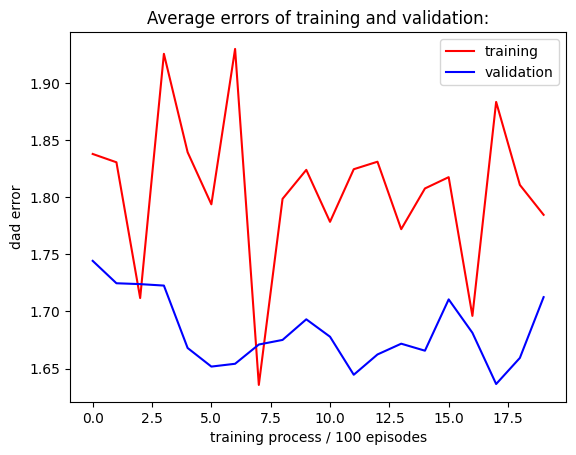

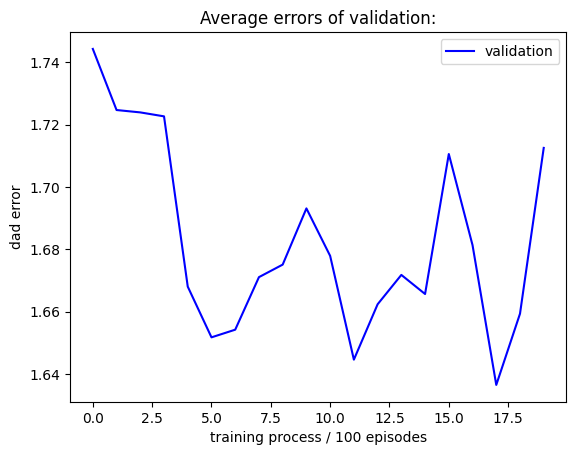

In [19]:
retrain(model_path='save_skip/6.220953541685593_ratio_0.1_sad/', traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='dad')

In [4]:
test_err(model_path='save_skip/96.36376516078319_ratio_0.1_sed/', amount=100, ratio=0.1, a_size=3, s_size=3, skip_size=2)

======Start testing the model at'save_skip/96.36376516078319_ratio_0.1_sed/======'
======loading test data======
It cost 5.548894166946411s

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.





training from last checkpoint save_skip/96.36376516078319_ratio_0.1_sed/
INFO:tensorflow:Restoring parameters from save_skip/96.36376516078319_ratio_0.1_sed/trained_model.ckpt
Effectiveness of different errors: sed:105.2781, ped:34.1580, dad:2.5429, sad:10.4925
Testing elapsed time = 35.4036s, 22.6911s, 24.9829s, 54.1714s
Effectiveness of different errors: sed:105.9360, ped:29.5563, dad:2.5475, sad:12.7535
Testing elapsed time = 36.8921s, 20.9580s, 21.4777s, 56.3783s
Effectiveness of different errors: sed:92.4549, ped:36.3348, dad:2.4869, sad:9.8685
Testing elapsed time = 38.1978s, 26.0520s, 31.7691s, 58.4297s


In [5]:
test_err(model_path='save_skip/42.764305274010006_ratio_0.1_ped/', amount=100, ratio=0.1, a_size=3, s_size=3, skip_size=2)

======Start testing the model at'save_skip/42.764305274010006_ratio_0.1_ped/======'
======loading test data======
It cost 5.421532869338989s
training from last checkpoint save_skip/42.764305274010006_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save_skip/42.764305274010006_ratio_0.1_ped/trained_model.ckpt
Effectiveness of different errors: sed:117.6519, ped:31.1589, dad:2.4355, sad:9.2433
Testing elapsed time = 33.5752s, 24.0281s, 27.5764s, 62.0765s
Effectiveness of different errors: sed:123.7912, ped:42.4737, dad:2.5498, sad:9.4978
Testing elapsed time = 37.6789s, 27.6197s, 26.7425s, 62.5350s
Effectiveness of different errors: sed:106.4817, ped:32.7484, dad:2.4609, sad:17.2207
Testing elapsed time = 38.6479s, 29.0055s, 31.7764s, 72.1696s


In [6]:
test_err(model_path='save_skip/1.6362231449707547_ratio_0.1_dad/', amount=100, ratio=0.1, a_size=3, s_size=3, skip_size=2)

======Start testing the model at'save_skip/1.6362231449707547_ratio_0.1_dad/======'
======loading test data======
It cost 0.8209457397460938s
training from last checkpoint save_skip/1.6362231449707547_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save_skip/1.6362231449707547_ratio_0.1_dad/trained_model.ckpt
Effectiveness of different errors: sed:113.2161, ped:36.2827, dad:1.9575, sad:6.9407
Testing elapsed time = 39.6983s, 28.0490s, 28.9429s, 60.9775s
Effectiveness of different errors: sed:106.8953, ped:34.8107, dad:1.9324, sad:6.9636
Testing elapsed time = 36.4099s, 26.7906s, 27.6922s, 59.9539s
Effectiveness of different errors: sed:110.4569, ped:32.4087, dad:1.9424, sad:6.9823
Testing elapsed time = 40.1332s, 37.3859s, 29.4460s, 86.3086s


In [7]:
test_err(model_path='save_skip/6.220953541685593_ratio_0.1_sad/', amount=100, ratio=0.1, a_size=3, s_size=3, skip_size=2)

======Start testing the model at'save_skip/6.220953541685593_ratio_0.1_sad/======'
======loading test data======
It cost 3.5623526573181152s
training from last checkpoint save_skip/6.220953541685593_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save_skip/6.220953541685593_ratio_0.1_sad/trained_model.ckpt
Effectiveness of different errors: sed:113.4748, ped:36.7485, dad:2.0466, sad:7.0343
Testing elapsed time = 53.6672s, 39.5983s, 40.6819s, 89.4189s
Effectiveness of different errors: sed:111.7496, ped:35.7468, dad:2.0339, sad:7.0658
Testing elapsed time = 47.0026s, 34.1808s, 26.7121s, 70.7546s
Effectiveness of different errors: sed:112.1520, ped:36.0612, dad:2.0108, sad:7.0965
Testing elapsed time = 38.5248s, 27.5449s, 28.9569s, 64.6961s


In [7]:
test(model_path='save_skip/44.19909936991496_ratio_0.1_ped/', amount=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='ped')

======Start testing the model at'save_skip/44.19909936991496_ratio_0.1_ped/======'
======loading test data======
It cost 0.8592097759246826s

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.





training from last checkpoint save_skip/44.19909936991496_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save_skip/44.19909936991496_ratio_0.1_ped/trained_model.ckpt
Effectiveness: 33.8515
Training elapsed time = 28.9138s
Effectiveness: 33.3227
Training elapsed time = 29.8993s
Effectiveness: 31.7428
Training elapsed time = 29.5912s


In [8]:
test(model_path='save_skip/1.692514236672618_ratio_0.1_dad/', amount=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='dad')

======Start testing the model at'save_skip/1.692514236672618_ratio_0.1_dad/======'
======loading test data======
It cost 0.8929848670959473s
training from last checkpoint save_skip/1.692514236672618_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save_skip/1.692514236672618_ratio_0.1_dad/trained_model.ckpt
Effectiveness: 2.0222
Training elapsed time = 31.1029s
Effectiveness: 1.9812
Training elapsed time = 29.2642s
Effectiveness: 1.9820
Training elapsed time = 29.2364s


In [9]:
test(model_path='save_skip/6.205896143777977_ratio_0.1_sad/', amount=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='sad')

======Start testing the model at'save_skip/6.205896143777977_ratio_0.1_sad/======'
======loading test data======
It cost 0.8847370147705078s
training from last checkpoint save_skip/6.205896143777977_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save_skip/6.205896143777977_ratio_0.1_sad/trained_model.ckpt
Effectiveness: 7.0245
Training elapsed time = 64.1590s
Effectiveness: 6.8729
Training elapsed time = 64.1535s
Effectiveness: 7.1737
Training elapsed time = 64.8215s


In [10]:
test(model_path='save_skip/85.49724994009317_ratio_0.1_sed/', amount=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='sed')

======Start testing the model at'save_skip/85.49724994009317_ratio_0.1_sed/======'
======loading test data======
It cost 0.8054087162017822s
training from last checkpoint save_skip/85.49724994009317_ratio_0.1_sed/
INFO:tensorflow:Restoring parameters from save_skip/85.49724994009317_ratio_0.1_sed/trained_model.ckpt
Effectiveness: 80.6049
Training elapsed time = 39.1671s
Effectiveness: 78.6538
Training elapsed time = 39.6811s
Effectiveness: 79.0446
Training elapsed time = 38.9343s


In [11]:
test(model_path='save_skip/1.7293385360112359_ratio_0.1_dad/', amount=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='dad')

======Start testing the model at'save_skip/1.7293385360112359_ratio_0.1_dad/======'
======loading test data======
It cost 0.8174417018890381s
training from last checkpoint save_skip/1.7293385360112359_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save_skip/1.7293385360112359_ratio_0.1_dad/trained_model.ckpt
Effectiveness: 2.0257
Training elapsed time = 29.3249s
Effectiveness: 2.1169
Training elapsed time = 28.9398s
Effectiveness: 2.0491
Training elapsed time = 29.0223s


In [12]:
test(model_path='save_skip/6.258997889155513_ratio_0.1_sad/', amount=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='sad')

======Start testing the model at'save_skip/6.258997889155513_ratio_0.1_sad/======'
======loading test data======
It cost 0.9220631122589111s
training from last checkpoint save_skip/6.258997889155513_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save_skip/6.258997889155513_ratio_0.1_sad/trained_model.ckpt
Effectiveness: 8.1029
Training elapsed time = 62.4207s
Effectiveness: 7.9119
Training elapsed time = 64.1115s
Effectiveness: 8.4854
Training elapsed time = 64.0336s


In [13]:
test(model_path='save_skip/82.51590753057037_ratio_0.1_sed/', amount=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='sed')

======Start testing the model at'save_skip/82.51590753057037_ratio_0.1_sed/======'
======loading test data======
It cost 0.8884682655334473s
training from last checkpoint save_skip/82.51590753057037_ratio_0.1_sed/
INFO:tensorflow:Restoring parameters from save_skip/82.51590753057037_ratio_0.1_sed/trained_model.ckpt
Effectiveness: 70.7067
Training elapsed time = 39.1785s
Effectiveness: 67.7903
Training elapsed time = 38.8972s
Effectiveness: 88.5451
Training elapsed time = 37.6737s


In [14]:
test(model_path='save_skip/43.53681788792537_ratio_0.1_ped/', amount=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='ped')

======Start testing the model at'save_skip/43.53681788792537_ratio_0.1_ped/======'
======loading test data======
It cost 0.5651969909667969s
training from last checkpoint save_skip/43.53681788792537_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save_skip/43.53681788792537_ratio_0.1_ped/trained_model.ckpt
Effectiveness: 34.3831
Training elapsed time = 28.2959s
Effectiveness: 29.1588
Training elapsed time = 27.2260s
Effectiveness: 31.4524
Training elapsed time = 28.4989s


In [15]:
test(model_path='save_skip/6.217648759527948_ratio_0.1_sad/', amount=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='sad')

======Start testing the model at'save_skip/6.217648759527948_ratio_0.1_sad/======'
======loading test data======
It cost 0.7562754154205322s
training from last checkpoint save_skip/6.217648759527948_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save_skip/6.217648759527948_ratio_0.1_sad/trained_model.ckpt
Effectiveness: 6.9236
Training elapsed time = 63.9495s
Effectiveness: 6.9138
Training elapsed time = 63.9816s
Effectiveness: 6.9772
Training elapsed time = 66.5904s


In [16]:
test(model_path='save_skip/80.33238766066327_ratio_0.1_sed/', amount=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='sed')

======Start testing the model at'save_skip/80.33238766066327_ratio_0.1_sed/======'
======loading test data======
It cost 0.8584847450256348s
training from last checkpoint save_skip/80.33238766066327_ratio_0.1_sed/
INFO:tensorflow:Restoring parameters from save_skip/80.33238766066327_ratio_0.1_sed/trained_model.ckpt
Effectiveness: 79.5098
Training elapsed time = 41.5733s
Effectiveness: 78.5385
Training elapsed time = 39.8867s
Effectiveness: 72.3413
Training elapsed time = 39.0662s


In [17]:
test(model_path='save_skip/38.45383667748532_ratio_0.1_ped/', amount=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='ped')

======Start testing the model at'save_skip/38.45383667748532_ratio_0.1_ped/======'
======loading test data======
It cost 0.8914051055908203s
training from last checkpoint save_skip/38.45383667748532_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save_skip/38.45383667748532_ratio_0.1_ped/trained_model.ckpt
Effectiveness: 28.2678
Training elapsed time = 28.8876s
Effectiveness: 27.2604
Training elapsed time = 30.3003s
Effectiveness: 27.7266
Training elapsed time = 29.9990s


In [18]:
test(model_path='save_skip/1.6362231449707547_ratio_0.1_dad/', amount=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='dad')

======Start testing the model at'save_skip/1.6362231449707547_ratio_0.1_dad/======'
======loading test data======
It cost 3.657052993774414s
training from last checkpoint save_skip/1.6362231449707547_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save_skip/1.6362231449707547_ratio_0.1_dad/trained_model.ckpt
Effectiveness: 1.9379
Training elapsed time = 28.2971s
Effectiveness: 1.9427
Training elapsed time = 30.5075s
Effectiveness: 1.9605
Training elapsed time = 29.3578s


In [4]:
test(model_path='save_skip/1.6364912154605304_ratio_0.1_dad/', amount=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='dad')

======Start testing the model at'save_skip/1.6364912154605304_ratio_0.1_dad/======'
======loading test data======
It cost 4.702431678771973s

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.





training from last checkpoint save_skip/1.6364912154605304_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save_skip/1.6364912154605304_ratio_0.1_dad/trained_model.ckpt
Effectiveness: 1.9274
Training elapsed time = 26.3399s
Effectiveness: 1.9326
Training elapsed time = 26.0913s
Effectiveness: 1.9761
Training elapsed time = 27.4267s


======loading train data======
It cost 12.700266361236572s.
training from last checkpoint save_skip/6.220953541685593_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save_skip/6.220953541685593_ratio_0.1_sad/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:46<00:00,  2.27s/it]


round 0 episode 100: Training error: 6.591844845531233, Validation error: 6.369346408277821
Save model with error 6.369346408277821
==>current best model is 6.369346408277821 with ratio 0.1
It costs 384.86306166648865s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.11s/it]


round 0 episode 200: Training error: 7.273191741398279, Validation error: 6.255790639710177
Save model with error 6.255790639710177
==>current best model is 6.255790639710177 with ratio 0.1
It costs 381.24214792251587s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:39<00:00,  2.20s/it]


round 1 episode 100: Training error: 6.583543383330873, Validation error: 6.268235359958693
==>current best model is 6.255790639710177 with ratio 0.1
It costs 389.95554208755493s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:39<00:00,  2.19s/it]


round 1 episode 200: Training error: 7.106059790851482, Validation error: 6.386894314364711
==>current best model is 6.255790639710177 with ratio 0.1
It costs 384.7653760910034s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:53<00:00,  2.33s/it]


round 2 episode 100: Training error: 6.965674988831879, Validation error: 6.540226242509398
==>current best model is 6.255790639710177 with ratio 0.1
It costs 419.3654820919037s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:33<00:00,  2.14s/it]


round 2 episode 200: Training error: 6.671043481153669, Validation error: 6.321086889720863
==>current best model is 6.255790639710177 with ratio 0.1
It costs 399.69158911705017s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:47<00:00,  2.27s/it]


round 3 episode 100: Training error: 7.730948796458847, Validation error: 6.436497004719661
==>current best model is 6.255790639710177 with ratio 0.1
It costs 418.6979134082794s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [04:13<00:00,  2.53s/it]


round 3 episode 200: Training error: 5.961242331709485, Validation error: 6.320922388071812
==>current best model is 6.255790639710177 with ratio 0.1
It costs 443.4602243900299s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [04:10<00:00,  2.51s/it]


round 4 episode 100: Training error: 7.543471083248297, Validation error: 6.277117612926241
==>current best model is 6.255790639710177 with ratio 0.1
It costs 441.0083611011505s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:51<00:00,  2.31s/it]


round 4 episode 200: Training error: 6.164874352872241, Validation error: 6.303553247460423
==>current best model is 6.255790639710177 with ratio 0.1
It costs 423.0189037322998s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [04:07<00:00,  2.47s/it]


round 5 episode 100: Training error: 7.184551607660632, Validation error: 6.2932976695469005
==>current best model is 6.255790639710177 with ratio 0.1
It costs 437.27547430992126s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:51<00:00,  2.31s/it]


round 5 episode 200: Training error: 6.865557017265809, Validation error: 6.2910350576400855
==>current best model is 6.255790639710177 with ratio 0.1
It costs 422.07015109062195s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:39<00:00,  2.19s/it]


round 6 episode 100: Training error: 6.475093423809147, Validation error: 6.290583603899958
==>current best model is 6.255790639710177 with ratio 0.1
It costs 410.2128703594208s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [04:16<00:00,  2.57s/it]


round 6 episode 200: Training error: 7.280423843989146, Validation error: 6.323702588015915
==>current best model is 6.255790639710177 with ratio 0.1
It costs 447.10875964164734s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [04:07<00:00,  2.47s/it]


round 7 episode 100: Training error: 6.718804721907628, Validation error: 6.297120895876713
==>current best model is 6.255790639710177 with ratio 0.1
It costs 437.5344638824463s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:48<00:00,  2.29s/it]


round 7 episode 200: Training error: 6.946037686769571, Validation error: 6.312946564665128
==>current best model is 6.255790639710177 with ratio 0.1
It costs 408.013995885849s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:53<00:00,  2.33s/it]


round 8 episode 100: Training error: 7.197204243622176, Validation error: 6.510538247128859
==>current best model is 6.255790639710177 with ratio 0.1
It costs 419.97512769699097s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:49<00:00,  2.29s/it]


round 8 episode 200: Training error: 6.460478166356508, Validation error: 6.328373539395117
==>current best model is 6.255790639710177 with ratio 0.1
It costs 412.7723157405853s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:42<00:00,  2.23s/it]


round 9 episode 100: Training error: 7.343438572963366, Validation error: 6.387119584606094
==>current best model is 6.255790639710177 with ratio 0.1
It costs 404.2768120765686s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:58<00:00,  2.39s/it]


round 9 episode 200: Training error: 6.388464600583838, Validation error: 6.247958113400181
Save model with error 6.247958113400181
==>current best model is 6.247958113400181 with ratio 0.1
It costs 423.71204233169556s
Training elapsed time = %s 8309.023620605469


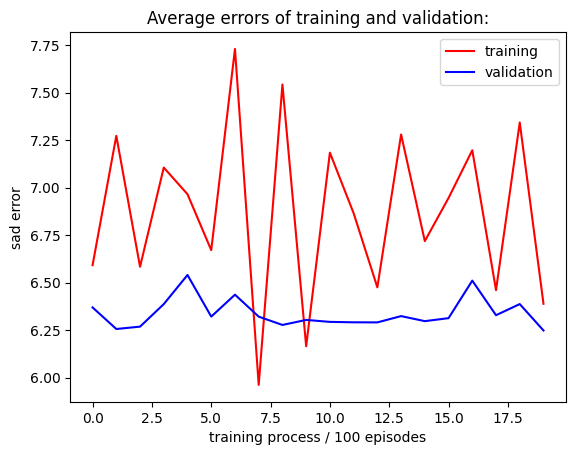

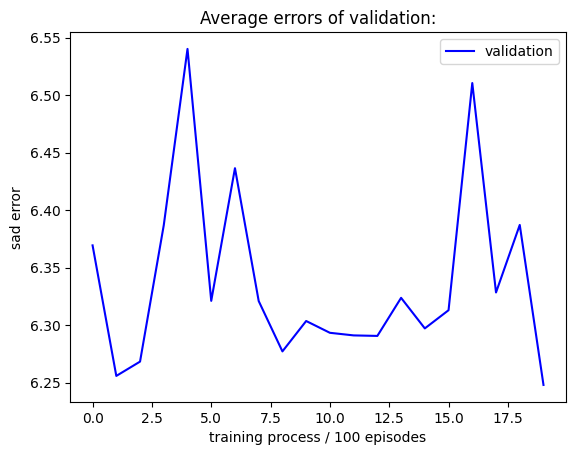

In [5]:
retrain(model_path='save_skip/6.220953541685593_ratio_0.1_sad/', traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='sad')

======loading train data======
It cost 12.511478424072266s.
training from last checkpoint save_skip/1.6362231449707547_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save_skip/1.6362231449707547_ratio_0.1_dad/trained_model.ckpt


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:02<00:00,  1.82s/it]


round 0 episode 100: Training error: 1.8656210254889138, Validation error: 1.703787699465839
Save model with error 1.703787699465839
==>current best model is 1.703787699465839 with ratio 0.1
It costs 337.49702620506287s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.42s/it]


round 0 episode 200: Training error: 1.6997036316728187, Validation error: 1.6954753949300532
Save model with error 1.6954753949300532
==>current best model is 1.6954753949300532 with ratio 0.1
It costs 286.46053862571716s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:55<00:00,  1.76s/it]


round 1 episode 100: Training error: 1.7303614694934129, Validation error: 1.6632463634619359
Save model with error 1.6632463634619359
==>current best model is 1.6632463634619359 with ratio 0.1
It costs 323.86476492881775s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


round 1 episode 200: Training error: 1.8401761186675174, Validation error: 1.6689655747135417
==>current best model is 1.6632463634619359 with ratio 0.1
It costs 314.9242742061615s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:14<00:00,  1.95s/it]


round 2 episode 100: Training error: 1.8170517289449006, Validation error: 1.7206782132741243
==>current best model is 1.6632463634619359 with ratio 0.1
It costs 351.3416244983673s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.43s/it]


round 2 episode 200: Training error: 1.8611557202350428, Validation error: 1.650340963453176
Save model with error 1.650340963453176
==>current best model is 1.650340963453176 with ratio 0.1
It costs 300.692085981369s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:53<00:00,  1.74s/it]


round 3 episode 100: Training error: 1.691645582873336, Validation error: 1.6757905014380388
==>current best model is 1.650340963453176 with ratio 0.1
It costs 328.99395775794983s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.62s/it]


round 3 episode 200: Training error: 1.9204520111282761, Validation error: 1.7081213101136263
==>current best model is 1.650340963453176 with ratio 0.1
It costs 317.4383623600006s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:56<00:00,  1.77s/it]


round 4 episode 100: Training error: 1.749586970964967, Validation error: 1.6663129858243297
==>current best model is 1.650340963453176 with ratio 0.1
It costs 331.28755497932434s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


round 4 episode 200: Training error: 1.8366437753606755, Validation error: 1.6628296924209196
==>current best model is 1.650340963453176 with ratio 0.1
It costs 316.37840461730957s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:39<00:00,  2.20s/it]


round 5 episode 100: Training error: 1.7248282613169252, Validation error: 1.6429732234697711
Save model with error 1.6429732234697711
==>current best model is 1.6429732234697711 with ratio 0.1
It costs 377.4746811389923s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [01:56<00:00,  1.17s/it]


round 5 episode 200: Training error: 1.8455236313878376, Validation error: 1.6661952247168048
==>current best model is 1.6429732234697711 with ratio 0.1
It costs 273.82789850234985s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:57<00:00,  1.78s/it]


round 6 episode 100: Training error: 1.7783846291027652, Validation error: 1.649993174370258
==>current best model is 1.6429732234697711 with ratio 0.1
It costs 334.1918706893921s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


round 6 episode 200: Training error: 1.8235279188984166, Validation error: 1.6566933447133925
==>current best model is 1.6429732234697711 with ratio 0.1
It costs 315.9593014717102s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.49s/it]


round 7 episode 100: Training error: 1.7649279459996297, Validation error: 1.64714175237916
==>current best model is 1.6429732234697711 with ratio 0.1
It costs 306.37507152557373s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:08<00:00,  1.89s/it]


round 7 episode 200: Training error: 1.8266358251580241, Validation error: 1.6487156205800346
==>current best model is 1.6429732234697711 with ratio 0.1
It costs 345.1866807937622s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:50<00:00,  1.70s/it]


round 8 episode 100: Training error: 1.6734476927050799, Validation error: 1.647676044894175
==>current best model is 1.6429732234697711 with ratio 0.1
It costs 327.3384301662445s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.66s/it]


round 8 episode 200: Training error: 1.8932874749495527, Validation error: 1.6586331872114384
==>current best model is 1.6429732234697711 with ratio 0.1
It costs 322.8089725971222s


[100/200]: 100%|██████████████████████████████████████████████████| 100/100 [03:06<00:00,  1.86s/it]


round 9 episode 100: Training error: 1.752325104767205, Validation error: 1.643489244030694
==>current best model is 1.6429732234697711 with ratio 0.1
It costs 342.2936272621155s


[200/200]: 100%|██████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.50s/it]


round 9 episode 200: Training error: 1.8056772150417124, Validation error: 1.6762863736621498
==>current best model is 1.6429732234697711 with ratio 0.1
It costs 305.92390608787537s
Training elapsed time = %s 6460.260268211365


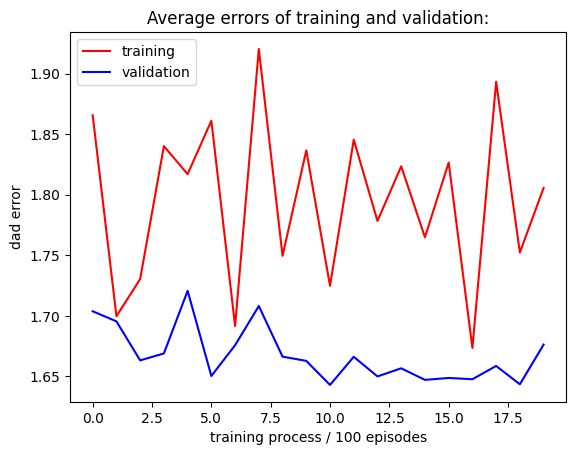

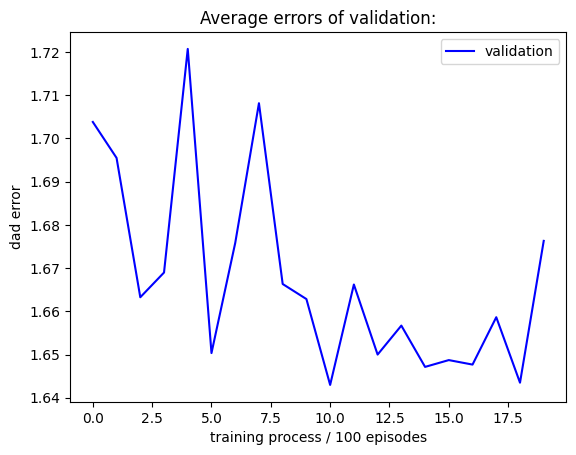

In [6]:
retrain(model_path='save_skip/1.6362231449707547_ratio_0.1_dad/', traj_amount=200, valid_amount=70, Round=10, show_time=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='dad')

In [7]:
test(model_path='save_skip/6.247958113400181_ratio_0.1_sad/', amount=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='sad')

======Start testing the model at'save_skip/6.247958113400181_ratio_0.1_sad/======'
======loading test data======
It cost 5.009283065795898s
training from last checkpoint save_skip/6.247958113400181_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save_skip/6.247958113400181_ratio_0.1_sad/trained_model.ckpt
Effectiveness: 6.9377
Training elapsed time = 64.5052s
Effectiveness: 6.9808
Training elapsed time = 66.5137s
Effectiveness: 6.9754
Training elapsed time = 65.1968s


In [8]:
test(model_path='save_skip/1.6429732234697711_ratio_0.1_dad/', amount=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='dad')

======Start testing the model at'save_skip/1.6429732234697711_ratio_0.1_dad/======'
======loading test data======
It cost 0.8279538154602051s
training from last checkpoint save_skip/1.6429732234697711_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save_skip/1.6429732234697711_ratio_0.1_dad/trained_model.ckpt
Effectiveness: 1.9549
Training elapsed time = 26.2870s
Effectiveness: 1.9367
Training elapsed time = 25.8618s
Effectiveness: 1.9377
Training elapsed time = 26.2411s


In [9]:
test(model_path='save_skip/6.247958113400181_ratio_0.1_sad/', amount=100, ratio=0.1, a_size=3, s_size=3, skip_size=2, label='sad')

======Start testing the model at'save_skip/6.247958113400181_ratio_0.1_sad/======'
======loading test data======
It cost 0.7160086631774902s
training from last checkpoint save_skip/6.247958113400181_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save_skip/6.247958113400181_ratio_0.1_sad/trained_model.ckpt
Effectiveness: 6.9578
Training elapsed time = 59.3132s
Effectiveness: 7.0310
Training elapsed time = 60.9296s
Effectiveness: 6.8771
Training elapsed time = 59.8808s
